# Homeworks - Big Data and Public Policy Class

*Name*: Andreas Eckmann

*E-Mail*: eckmanna@ethz.ch

In [2]:
from IPython.display import display
import pandas as pd
pd.options.display.max_columns = None # Display all columns of a dataframe
pd.options.display.max_rows = 700
from pprint import pprint

import tweepy
from tweepy import OAuthHandler
import time
import datetime
import os
import numpy as np
import pandas as pd
import yfinance as yf
import re
from bs4 import BeautifulSoup
import sklearn

In [3]:
# To plot pretty figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
#%matplotlib notebook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

# to make this notebook's output identical at every run
np.random.seed(42)

## **Step 1a: `X` variables** [week 2]
- Fetch the data using the **twitter API** or any other API or website that you are interested in.
- Beware of the rate limits and organize your program so as to overcome them if needed
- The data should include some text, but might also have other interesting variables (retweets, favorites...)
- Create some (non-text based) `X_num` variables that you will use for the prediction

In [4]:
#this you get when you make create an application on twitter as a dev
consumer_key="7X8q1LteL1qOLRg4DSoiI0lyk"
consumer_secret="Bb08vV5XoxDEP4SGLJfkvEpuwvxEDvzVSRGTptzQCjC9XVmquP"
access_token="1230145588659998721-EQb8DoMYnorBtqAuEPMZtZcXumzuAe"
access_token_secret="mzurpOu1LWhj0NU9pctgYZ6OBzhQvyqw8hvRNpe3yI4Qc"

## Accessing the Twitter API using `tweepy`

Twitter requires all requests to use `OAuth` for authentication

In [5]:
# Authenticate to Twitter
auth = OAuthHandler(consumer_key, consumer_secret) #creating an OAuthHandler instance
auth.set_access_token(access_token, access_token_secret)

# We specify wait_on_rate_limit_notify==True & wait_on_rate_limit=True. The API method will wait once you’ve reached your rate limit and prints out a message
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
# test authentication
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [7]:
# most recent tweets about Beyond Meat
tweets = api.search(q="Beyond Meat", lang="en") # TODO: How is it set to recent tweets?
for tweet in tweets:
    print(tweet.text) # printing the first tweet

After not eating v healthy today, do I eat the other beyond meat burger that's in the freezer, or do I be good n have a stir fry???
RT @vegan: Such encouraging news! https://t.co/zrUw1OoMx5
I feel like adding a beyond meat patty to a sandwich with EGGS and CHEESE defeats the purpose?? @StarbucksCanada
@blogTO Meat is becoming difficult to find in the bigger cities.  
Beyond Meat which is not
Organic is the agenda of the green agenda.
RT @vegan: Such encouraging news! https://t.co/zrUw1OoMx5
RT @imperialmarkeat: #Brunch + #burger = The best #breakfast burger you’ve ever had! The Good Morning Burger is made w/ beef patty (or Beyo…
RT @dtortorici: “The safest communities don’t have the most cops; they have the most resources” —Manju Rajendran, Durham Beyond Policing…
After walking 7 miles, he deserved a night out.
Proud because he chose a healthier dinner option.
My dish was delis… https://t.co/2gF1HvlJ9W
RT @TeslaInTheUK: I’m not vegan, but have just seen some Beyond burgers in Tesco. I’

In [8]:
target='BeyondMeat' #'BeyondMeat'
user = api.get_user(target) # argument = id, user_id, screen_name
pprint(user._json)

{'contributors_enabled': False,
 'created_at': 'Thu May 03 05:40:43 +0000 2012',
 'default_profile': False,
 'default_profile_image': False,
 'description': "Meat that's made from plants, made for meat lovers. \n"
                '#GoBeyond',
 'entities': {'description': {'urls': []},
              'url': {'urls': [{'display_url': 'beyondmeat.com',
                                'expanded_url': 'http://www.beyondmeat.com',
                                'indices': [0, 22],
                                'url': 'http://t.co/4ZbzGc2iMf'}]}},
 'favourites_count': 18433,
 'follow_request_sent': False,
 'followers_count': 110644,
 'following': True,
 'friends_count': 693,
 'geo_enabled': True,
 'has_extended_profile': False,
 'id': 569714177,
 'id_str': '569714177',
 'is_translation_enabled': False,
 'is_translator': False,
 'lang': None,
 'listed_count': 1092,
 'location': 'El Segundo, CA',
 'name': 'Beyond Meat',
 'notifications': False,
 'profile_background_color': 'FAF5E2',
 'profile

In [9]:
# Some attributes of the `user` object:
print("Name:", user.name)
print("Screen name:", user.screen_name)
print("Number of followers:" ,  user.followers_count)
pprint("description: " + user.description)
pprint("Number of tweets published: " + str(user.statuses_count))
pprint("friends_count: " + str(user.friends_count))

Name: Beyond Meat
Screen name: BeyondMeat
Number of followers: 110644
"description: Meat that's made from plants, made for meat lovers. \n#GoBeyond"
'Number of tweets published: 24073'
'friends_count: 693'


In [10]:
# Note: This code (cell) was written with the help of Gian-Luca and Felix 
def fetch_tweets(account, n_tweets):
    """Fetch data from Beyond Meat twitter account"""
    df_out = pd.DataFrame()
    
    try:   
        # Put the tweets into a data frame object
        tweet_count = 0
        for tweet in tweepy.Cursor(api.user_timeline, 
                                   screen_name=target, 
                                   tweet_mode ='extended',
                                   include_rts = False).items(n_tweets):
    
                    # Transform the json into a dataframe
                    df_tweet = pd.DataFrame.from_dict(tweet._json, orient='index', 
                                                      columns=[tweet_count]) # , sleep_on_rate_limit=True
      
                    # Concatenate the tweet dataframe to the df_tweets dataframe
                    df_out = pd.concat([df_tweet, df_out], axis=1)
    
                    # count the number of tweets fetched
                    tweet_count += 1 
    
        time.sleep(1)
    
    # except if TweepError arises
    except tweepy.TweepError: #the error arises when the user has protected tweets
        print("Failed to run the command "
              "on user {}, Skipping...".format(account))
    
    # except if RateLimitError arises
    except tweepy.RateLimitError:
        print("resource usage limit: {} skipped".format(account))
        time.sleep(15 * 60) # wait 15 mins
        
    return df_out

In [11]:
# Calling the function

df_tweets = fetch_tweets(target,2000)
print(df_tweets.columns)

Int64Index([1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990,
            ...
               9,    8,    7,    6,    5,    4,    3,    2,    1,    0],
           dtype='int64', length=2000)


In [12]:
# Transpose the data set
df_tweets = df_tweets.transpose() # Transpose the dataset
print(df_tweets.columns)
print(df_tweets.shape)
df_tweets.head()

Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status',
       'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'lang',
       'extended_entities', 'possibly_sensitive', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status_permalink', 'quoted_status'],
      dtype='object')
(2000, 30)


created_at                   id  \
1999  Thu Aug 23 19:19:45 +0000 2018  1032708995000229889   
1998  Fri Aug 24 00:30:06 +0000 2018  1032787096820502528   
1997  Sat Aug 25 00:31:55 +0000 2018  1033149939923206144   
1996  Mon Aug 27 18:00:17 +0000 2018  1034138546968219648   
1995  Wed Aug 29 20:44:01 +0000 2018  1034904528842194945   

                   id_str                                          full_text  \
1999  1032708995000229889  @6thMan_Miller @KyrieIrving @celtics We can't ...   
1998  1032787096820502528  Weekend forecast: Sunny with a chance of South...   
1997  1033149939923206144  College football, we are ready for you! Tackle...   
1996  1034138546968219648  Tyson Foods is making strides to transition fr...   
1995  1034904528842194945  "That's a meaty burger... I am BEYOND excited!...   

     truncated display_text_range  \
1999     False           [37, 71]   
1998     False           [0, 163]   
1997     False           [0, 214]   
1996     False           [0, 245]   
1995     False           [0, 189]   

                                               entities  \
1999  {'hashtags': [], 'symbols': [], 'user_mentions...   
1998  {'hashtags': [], 'symbols': [], 'user_mentions...   
1997  {'hashtags': [], 'symbols': [], 'user_mentions...   
1996  {'hashtags': [], 'symbols': [], 'user_mentions...   
1995  {'hashtags': [{'text': 'BeyondBurger', 'indice...   

                                                 source in_reply_to_status_id  \
1999  <a href="https://sproutsocial.com" rel="nofoll...   1032423210351046656   
1998  <a href="https://sproutsocial.com" rel="nofoll...                  None   
1997  <a href="https://sproutsocial.com" rel="nofoll...                  None   
1996  <a href="http://twitter.com/download/iphone" r...                  None   
1995  <a href="http://twitter.com" rel="nofollow">Tw...                  None   

     in_reply_to_status_id_str in_reply_to_user_id in_reply_to_user_id_str  \
1999       1032423210351046656  954760920445669381      954760920445669381   
1998                      None                None                    None   
1997                      None                None                    None   
1996                      None                None                    None   
1995                      None                None                    None   

     in_reply_to_screen_name  \
1999                 hawgtie   
1998                    None   
1997                    None   
1996                    None   
1995                    None   

                                                   user   geo coordinates  \
1999  {'id': 569714177, 'id_str': '569714177', 'name...  None        None   
1998  {'id': 569714177, 'id_str': '569714177', 'name...  None        None   
1997  {'id': 569714177, 'id_str': '569714177', 'name...  None        None   
1996  {'id': 569714177, 'id_str': '569714177', 'name...  None        None   
1995  {'id': 569714177, 'id_str': '569714177', 'name...  None        None   

     place contributors is_quote_status retweet_count favorite_count  \
1999  None         None           False             0              1   
1998  None         None           False            12             44   
1997  None         None           False            13             52   
1996  None         None           False            53            199   
1995  None         None            True            14            124   

     favorited retweeted lang  \
1999     False     False   en   
1998     False     False   en   
1997     False     False   en   
1996     False     False   en   
1995     False     False   en   

                                      extended_entities possibly_sensitive  \
1999                                                NaN                NaN   
1998  {'media': [{'id': 1032787095218257925, 'id_str...              False   
1997  {'media': [{'id': 1033149853772251136, 'id_str...              False   
1996  {'media': [{'id': 1034138542836830208,

In [13]:
# Reduce data set and save the data in a csv file
df_tweets_small = df_tweets[['full_text', 'created_at', 'retweet_count', 'favorite_count']] # 'user'
df_tweets_small.head()

full_text  \
1999  @6thMan_Miller @KyrieIrving @celtics We can't ...   
1998  Weekend forecast: Sunny with a chance of South...   
1997  College football, we are ready for you! Tackle...   
1996  Tyson Foods is making strides to transition fr...   
1995  "That's a meaty burger... I am BEYOND excited!...   

                          created_at retweet_count favorite_count  
1999  Thu Aug 23 19:19:45 +0000 2018             0              1  
1998  Fri Aug 24 00:30:06 +0000 2018            12             44  
1997  Sat Aug 25 00:31:55 +0000 2018            13             52  
1996  Mon Aug 27 18:00:17 +0000 2018            53            199  
1995  Wed Aug 29 20:44:01 +0000 2018            14            124

In [14]:
# IMPORTANT NOTE: This part of the code is commented out, so that the data obtained from twitter remains the same and does not change with the date (2020-05-02)
"""
# Get path to save the file on my computer (local)
parent_path = os.path.dirname(os.getcwd()) # os.getcwd() fetchs the current path, 
data_path = os.path.join(parent_path, 'data')
print(data_path)

# Saving fetched tweets as CSV file (uncomment to run)
df_tweets_small.to_csv(data_path+'/Beyond_Meat_tweets_{}.csv'.format(np.datetime64('today','D')), sep= ';')
print("{} tweets fetched.\n".format(df_tweets.shape[0]))
"""

'\n# Get path to save the file on my computer (local)\nparent_path = os.path.dirname(os.getcwd()) # os.getcwd() fetchs the current path, \ndata_path = os.path.join(parent_path, \'data\')\nprint(data_path)\n\n# Saving fetched tweets as CSV file (uncomment to run)\ndf_tweets_small.to_csv(data_path+\'/Beyond_Meat_tweets_{}.csv\'.format(np.datetime64(\'today\',\'D\')), sep= \';\')\nprint("{} tweets fetched.\n".format(df_tweets.shape[0]))\n'

In [18]:
# Load the csv data from my online repository
df_raw = pd.read_csv('https://raw.githubusercontent.com/eckmanna/big_data_policy_2020/master/data/Beyond_Meat_tweets_2020-05-02.csv', sep=';')
print(df_raw)

      Unnamed: 0                                          full_text  \
0           1999  @AaronMinogueUSA @Vegicano @FollowYourHeart A+...   
1           1998  @BellaMarieCt1 Check out our store-locator to ...   
2           1997  @BoomChickaWow1 Thank you for you patience and...   
3           1996  @Captain_Quench @AWCanada We are working on ex...   
4           1995  @paulasulllivan @WholeFoods Hey Paula! We are ...   
...          ...                                                ...   
1995           4  @jeramiedreyfuss @catnamedcatteri @WSJ Thank y...   
1996           3                            @ShaniasmithCo @xmxcc 😋   
1997           2                         @thefawz Looks delicious 😋   
1998           1              @jamietworkowski @ImpossibleFoods 🌱💚🌎   
1999           0         #PlantBasedParty 🥳 https://t.co/UBL0h0DXwp   

                          created_at  retweet_count  favorite_count  
0     Fri Aug 17 00:40:22 +0000 2018              0               1  
1     F

In [19]:
# Or from my local folder: (uncomment to run)
"""
# Load the data from csv file (date 2020-05-02)
df_raw = pd.read_csv(data_path+'/Beyond_Meat_tweets_{}.csv'.format(np.datetime64('2020-05-02')), sep=';')
print(df_raw.shape,
      df_raw.head())
"""

"\n# Load the data from csv file (date 2020-05-02)\ndf_raw = pd.read_csv(data_path+'/Beyond_Meat_tweets_{}.csv'.format(np.datetime64('2020-05-02')), sep=';')\nprint(df_raw.shape,\n      df_raw.head())\n"

In [20]:
# Note: This code (cell) was written with the help of Gian-Luca 
# obtain tweets as list
all_texts = list(df_raw['full_text'])

# search for hashtags and remove special characters
# and separate each word in the tweets --> important for keyword search afterwards
ats = []
hashtags = []
texts = []
for i in all_texts:
    a = []
    tex = []
    hashs = []
    for word in i.split():
        hashtag = re.search(r'(?<=#)\w+', word)
        at = re.search(r'(?<=@)\w+', word)
        if hashtag != None:
            hashs.append(hashtag.group().lower())
        if at != None:
            a.append(at.group().lower())
        else:
            text = re.search(r'\w+', word)
            if text != None:
                tex.append(text.group().lower())
    ats.append(a)
    texts.append(tex)
    hashtags.append(hashs)

In [21]:
#create data frame for overview:
dict1 = {'all_texts':all_texts, 'ats':ats, 'texts':texts, 'hashtags':hashtags}
df_ov =pd.DataFrame(dict1)
df_ov.head()

all_texts  \
0  @AaronMinogueUSA @Vegicano @FollowYourHeart A+...   
1  @BellaMarieCt1 Check out our store-locator to ...   
2  @BoomChickaWow1 Thank you for you patience and...   
3  @Captain_Quench @AWCanada We are working on ex...   
4  @paulasulllivan @WholeFoods Hey Paula! We are ...   

                                            ats  \
0  [aaronminogueusa, vegicano, followyourheart]   
1                               [bellamariect1]   
2                              [boomchickawow1]   
3                    [captain_quench, awcanada]   
4                  [paulasulllivan, wholefoods]   

                                               texts hashtags  
0                        [a, with, the, gif, choice]       []  
1  [check, out, our, store, to, find, a, store, n...       []  
2  [thank, you, for, you, patience, and, support,...       []  
3  [we, are, working, on, expanding, internationa...       []  
4  [hey, paula, we, are, currently, experiencing,...       []

In [22]:
# NOTE: This part of the code is commented out, so that the data obtained from twitter remains the same and does not change with the date (2020-05-02)
"""
# Save as CSV file (uncomment to run code)
df_ov.to_csv(data_path+'/Beyond_Meat_tweets_overview_{}.csv'.format(np.datetime64('today','D')), sep= ';')
"""

"\n# Save as CSV file (uncomment to run code)\ndf_ov.to_csv(data_path+'/Beyond_Meat_tweets_overview_{}.csv'.format(np.datetime64('today','D')), sep= ';')\n"

In [23]:
# define list of search strings:
hashtag_search_strings = ['stock','BYND','Nasdaq', 'vegan', 'beyondburger','GoBeyond', 'plantbased', 'plantbasedparty', 'eathealthy', 'WorldHealthDay',
                          'TheGreatAmericanTakeout', 'BeyondBeef', 'GoBeyondBreakfast', 'BeyondAmbassador', 'WorldKindnessDay']
text_search_strings = ['stock exchange', 'carbon', 'environment', 'meat', 'animals', 'climate', 'green', 'planet', 'health', 'healthy', 'food',
                       'stock','BYND','Nasdaq', 'vegan', 'beyondburger','GoBeyond', 'plantbased', 'plantbasedparty', 'eathealthy', 'WorldHealthDay',
                          'TheGreatAmericanTakeout', 'BeyondBeef', 'GoBeyondBreakfast', 'BeyondAmbassador', 'WorldKindnessDay']

In [24]:
#loop over hashtags and texts
hash_occ = []
for i in hashtags:
    hashs = []
    for j in i:
        if j in hashtag_search_strings:
            hashs.append(j)
    hash_occ.append(hashs)
        
text_occ = []
for i in texts:
    tex = []
    for j in i:
        if j in text_search_strings:
            tex.append(j)
    text_occ.append(tex)

In [25]:
#count keyword and key hastags per tweet 
key_count = []
for i in text_occ:
    if i != None:
        key_count.append(len(i))
    else:
        key_count.append(0)
        
key_hash_count = []
for i in hash_occ:
    if i != None:
        key_hash_count.append(len(i))
    else:
        key_hash_count.append(0)


In [26]:
#get columns on time, retweets, and favourite counts from df_raw file as lists
created_at = df_raw['created_at']
retweet_count = df_raw['retweet_count']
favorite_count = df_raw['favorite_count']

# deal with date format issue and change format to yfinance default setting:
change_date = []
for i in created_at:
    convert_date = datetime.datetime.strptime(i, '%a %b %d %H:%M:%S +0000 %Y')
    change_date.append(convert_date.strftime('%Y-%m-%d'))


#create dict with all the relevant informations:
dict2 = {'tweet':all_texts, 'created at':change_date, 'favorite count':favorite_count, 'retweet count':retweet_count,
         'key hashtag count':key_hash_count,'key hashtag':hash_occ, 'keyword count':key_count ,'keywords':text_occ }

# Create data frame of all the numeric values needed for the stock predictions:
X_num_raw = pd.DataFrame(dict2)
X_num_raw.head()

tweet  created at  \
0  @AaronMinogueUSA @Vegicano @FollowYourHeart A+...  2018-08-17   
1  @BellaMarieCt1 Check out our store-locator to ...  2018-08-17   
2  @BoomChickaWow1 Thank you for you patience and...  2018-08-17   
3  @Captain_Quench @AWCanada We are working on ex...  2018-08-17   
4  @paulasulllivan @WholeFoods Hey Paula! We are ...  2018-08-17   

   favorite count  retweet count  key hashtag count key hashtag  \
0               1              0                  0          []   
1               1              0                  0          []   
2               1              0                  0          []   
3               1              0                  0          []   
4               2              1                  0          []   

   keyword count keywords  
0              0       []  
1              0       []  
2              0       []  
3              0       []  
4              0       []

In [27]:
# remove all the brackets in the data frame X_num
X_num_raw['keywords'] = X_num_raw['keywords'].str[0]
X_num_raw['key hashtag'] = X_num_raw['key hashtag'].str[0]
X_num_raw

tweet  created at  \
0     @AaronMinogueUSA @Vegicano @FollowYourHeart A+...  2018-08-17   
1     @BellaMarieCt1 Check out our store-locator to ...  2018-08-17   
2     @BoomChickaWow1 Thank you for you patience and...  2018-08-17   
3     @Captain_Quench @AWCanada We are working on ex...  2018-08-17   
4     @paulasulllivan @WholeFoods Hey Paula! We are ...  2018-08-17   
...                                                 ...         ...   
1995  @jeramiedreyfuss @catnamedcatteri @WSJ Thank y...  2020-05-01   
1996                            @ShaniasmithCo @xmxcc 😋  2020-05-01   
1997                         @thefawz Looks delicious 😋  2020-05-01   
1998              @jamietworkowski @ImpossibleFoods 🌱💚🌎  2020-05-01   
1999         #PlantBasedParty 🥳 https://t.co/UBL0h0DXwp  2020-05-02   

      favorite count  retweet count  key hashtag count      key hashtag  \
0                  1              0                  0              NaN   
1                  1              0                  0              NaN   
2                  1              0                  0              NaN   
3                  1              0                  0              NaN   
4                  2              1                  0              NaN   
...              ...            ...                ...              ...   
1995               1              0                  0              NaN   
1996               1              0                  0              NaN   
1997               3              0                  0              NaN   
1998               3              0                  0              NaN   
1999             102              8                  1  plantbasedparty   

      keyword count         keywords  
0                 0              NaN  
1                 0              NaN  
2                 0              NaN  
3                 0              NaN  
4                 0              NaN  
...             ...              ...  
1995              0              NaN  
1996              0              NaN  
1997              0              NaN  
1998              0              NaN  
1999              1  plantbasedparty  

[2000 rows x 8 columns]

**Now:** Lets have a look at what the most popular keywords and hashtags are:

In [28]:
# most popular keyword
keyword_counts = X_num_raw['keywords'].value_counts().rename_axis('unique_values').reset_index(name='counts')
keyword_counts

unique_values  counts
0              meat     180
1      beyondburger     143
2              food      23
3             vegan      16
4             stock      13
5        plantbased       6
6           climate       5
7            health       4
8   plantbasedparty       3
9       environment       2
10          animals       2
11            green       1
12           planet       1

In [29]:
# most popular key hashtags
key_hashtag_counts = X_num_raw['key hashtag'].value_counts().rename_axis('unique_values').reset_index(name='counts')
key_hashtag_counts

unique_values  counts
0     beyondburger     153
1       plantbased       6
2  plantbasedparty       3

In [30]:
# Now look for the numerical variables of the tweets that were tweeted
# within a day and sum them up to one value per day:
    
addition = []
set_created = set(change_date)
for k in set_created: 
    index_doppelt = [] 
    for ind,i in enumerate(change_date):
        if i == k: # put toghether all tweets per day
            index_doppelt.append(ind)
    # sum up all counts and keywords, and so on into one date        
    addition.append([k,sum(X_num_raw.iloc[index_doppelt]['retweet count']),
                     sum(X_num_raw.iloc[index_doppelt]['favorite count']),
                     sum(X_num_raw.iloc[index_doppelt]['key hashtag count']),
                     sum(X_num_raw.iloc[index_doppelt]['keyword count'])])


In [31]:
# create Data Frame X_num, wich contains all necessary numeric Variables
X_num = pd.DataFrame(addition)
X_num.head()

0   1    2  3  4
0  2019-03-27   5   36  0  0
1  2018-12-31  23  249  0  1
2  2019-01-21  61  197  0  1
3  2019-09-30   0   33  0  1
4  2018-09-13  32  217  0  3

In [32]:
# Name Columns
X_num.columns = ['Date','retweet count', 'favorite count','key hashtag count', 'keyword count']
X_num.head()

Date  retweet count  favorite count  key hashtag count  keyword count
0  2019-03-27              5              36                  0              0
1  2018-12-31             23             249                  0              1
2  2019-01-21             61             197                  0              1
3  2019-09-30              0              33                  0              1
4  2018-09-13             32             217                  0              3

In [33]:
# Sort now by Date
X_num['Date'] =pd.to_datetime(X_num.Date)
X_num = X_num.sort_values('Date')
# Reset Index
X_num = X_num.reset_index(drop=True)
X_num.head()

Date  retweet count  favorite count  key hashtag count  keyword count
0 2018-08-17             34             189                  0              1
1 2018-08-18             69             290                  0              0
2 2018-08-19             15              62                  0              0
3 2018-08-20             56             230                  2              2
4 2018-08-21              6              41                  1              2

## **Step 1b: continuous `y` variables** [week 2]
- Fetching the data: 
    - if you work on the suggested idea, you can easily access daily stock prices using the [`yfinance` package](https://pypi.org/project/yfinance/)  (see below)
    - otherwise, you can find some interesting data listed in the syllabus

In [34]:
bynd = yf.Ticker("BYND")
# get stock info
bynd.info

{'zip': '90245',
 'sector': 'Consumer Defensive',
 'fullTimeEmployees': 472,
 'longBusinessSummary': 'Beyond Meat, Inc., a food company, engages in the provision of revolutionary plant-based meats in the United States and internationally. It offers its products in plant-based platforms of beef, pork, and poultry in ready-to-cook and ready-to-heat formats. The company sells its products through grocery, mass merchandiser, club and convenience store, and natural retailer channels, as well as direct to consumer and various food-away-from-home channels under the Beyond Meat, Beyond Burger, Beyond Beef, Beyond Sausage, Beyond Breakfast Sausage, Beyond Chicken, Beyond Fried Chicken, Beyond Meatball, the Caped Steer Logo, GO BEYOND, Eat What You Love, The Cookout Classic, The Future of Protein, and The Future of Protein Beyond Meat brand names. The company was formerly known as Savage River, Inc. and changed its name to Beyond Meat, Inc. in September 2018. Beyond Meat, Inc. was founded in 200

In [35]:
# get historical market data
hist = bynd.history(period="max")
hist.head()

Open   High    Low  Close    Volume  Dividends  Stock Splits
Date                                                                     
2019-05-02  46.00  72.95  45.00  65.75  23119000          0             0
2019-05-03  72.00  74.00  65.66  66.79  13139400          0             0
2019-05-06  62.73  74.84  62.50  74.79   8746200          0             0
2019-05-07  77.14  85.45  75.00  79.17  16532100          0             0
2019-05-08  83.61  85.38  70.79  72.25  14696300          0             0

In [36]:
# fetch stock prices from Beyond Meat
# Take same dates as for the tweets (stock data starts at 2019-05-02)
bynd_stock_df = yf.download('BYND',
                      start='2018-08-17', 
                      end='2020-05-02',
                      interval= '1d',
                      progress=False)

In [37]:
# show actions (dividends, splits)
bynd.actions

Empty DataFrame
Columns: [Dividends, Stock Splits]
Index: []

In [38]:
# show earnings
bynd.earnings
bynd.quarterly_earnings

Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []

In [39]:
bynd_stock_df.head()

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2019-05-02  46.000000  72.949997  45.000000  65.750000  65.750000  23119000
2019-05-03  72.000000  74.000000  65.660004  66.790001  66.790001  13139400
2019-05-06  62.730000  74.839996  62.500000  74.790001  74.790001   8746200
2019-05-07  77.139999  85.449997  75.000000  79.169998  79.169998  16532100
2019-05-08  83.610001  85.379997  70.785004  72.250000  72.250000  14696300

## **Step 1c: merge `X_num` and `y`** [week 2]
- Beware of the temporality: in the case of the proposed study on stock market prices, you will have to deal with the fact that the X is at the tweet level while `y` is daily. 


In [40]:
# merge 
# use option, how = 'inner' to deal with temporality issue 
y = bynd_stock_df['High']
df1 = pd.merge(X_num, y, how='inner', on=['Date'])
df1.head()

Date  retweet count  favorite count  key hashtag count  keyword count  \
0 2019-05-02            908            3261                  0              2   
1 2019-05-03            144             379                  1              2   
2 2019-05-06            117             606                  1              1   
3 2019-05-07              3              66                  0              0   
4 2019-05-08             26             159                  0              0   

        High  
0  72.949997  
1  74.000000  
2  74.839996  
3  85.449997  
4  85.379997

In [41]:
# NOTE: This part of the code is commented out, so that the data obtained from twitter remains the same and does not change with the date (2020-05-02)
# save it as csv file (uncomment to run code)
# df1.to_csv(data_path +'/X_num_y_merged.csv')

In [44]:
# Load the csv data from my online repository
df1 = pd.read_csv('https://raw.githubusercontent.com/eckmanna/big_data_policy_2020/master/data/X_num_y_merged.csv').iloc[:, 1:] #avoiding "unnamed"-row

print(df1.shape,
      df1.head())

(226, 6)          Date  retweet count  favorite count  key hashtag count  \
0  2019-05-02            908            3261                  0   
1  2019-05-03            144             379                  1   
2  2019-05-06            117             606                  1   
3  2019-05-07              3              66                  0   
4  2019-05-08             26             159                  0   

   keyword count       High  
0              2  72.949997  
1              2  74.000000  
2              1  74.839996  
3              0  85.449997  
4              0  85.379997  


In [45]:
# Or from my local folder: (uncomment to run)
"""
# load data from csv file X_num_y_merged
df1 = pd.read_csv(data_path +'/X_num_y_merged.csv').iloc[:, 1:] #avoiding "unnamed"-row

print(df1.shape,
      df1.head())
"""

'\n# load data from csv file X_num_y_merged\ndf1 = pd.read_csv(data_path +\'/X_num_y_merged.csv\').iloc[:, 1:] #avoiding "unnamed"-row\n\nprint(df1.shape,\n      df1.head())\n'

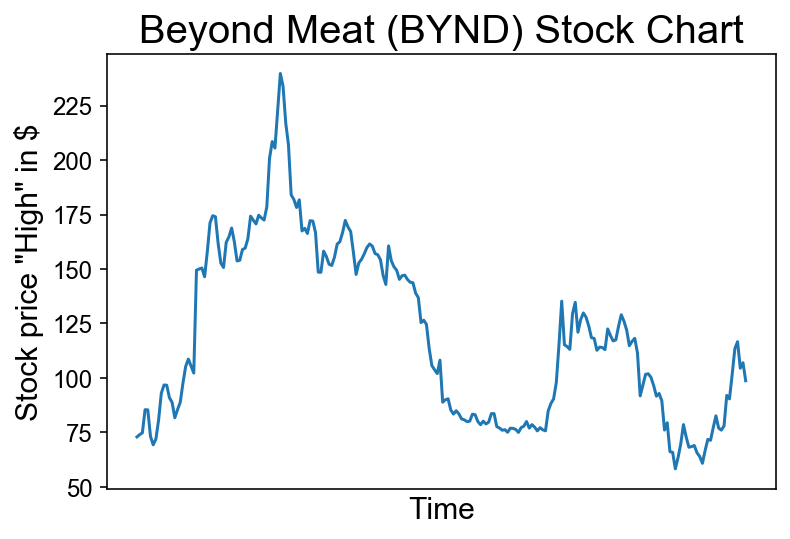

In [46]:
# Plotting stock data
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

y = df1['High']
x = df1['Date']

#df = df1.as_matrix(columns=df1.columns[1:7])

fig, ax = plt.subplots()
ax.plot('Date', 'High', data=df1)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel("Time", size=15)
plt.ylabel('Stock price "High" in $', size=15)
plt.title('Beyond Meat (BYND) Stock Chart', size=20)

plt.show()

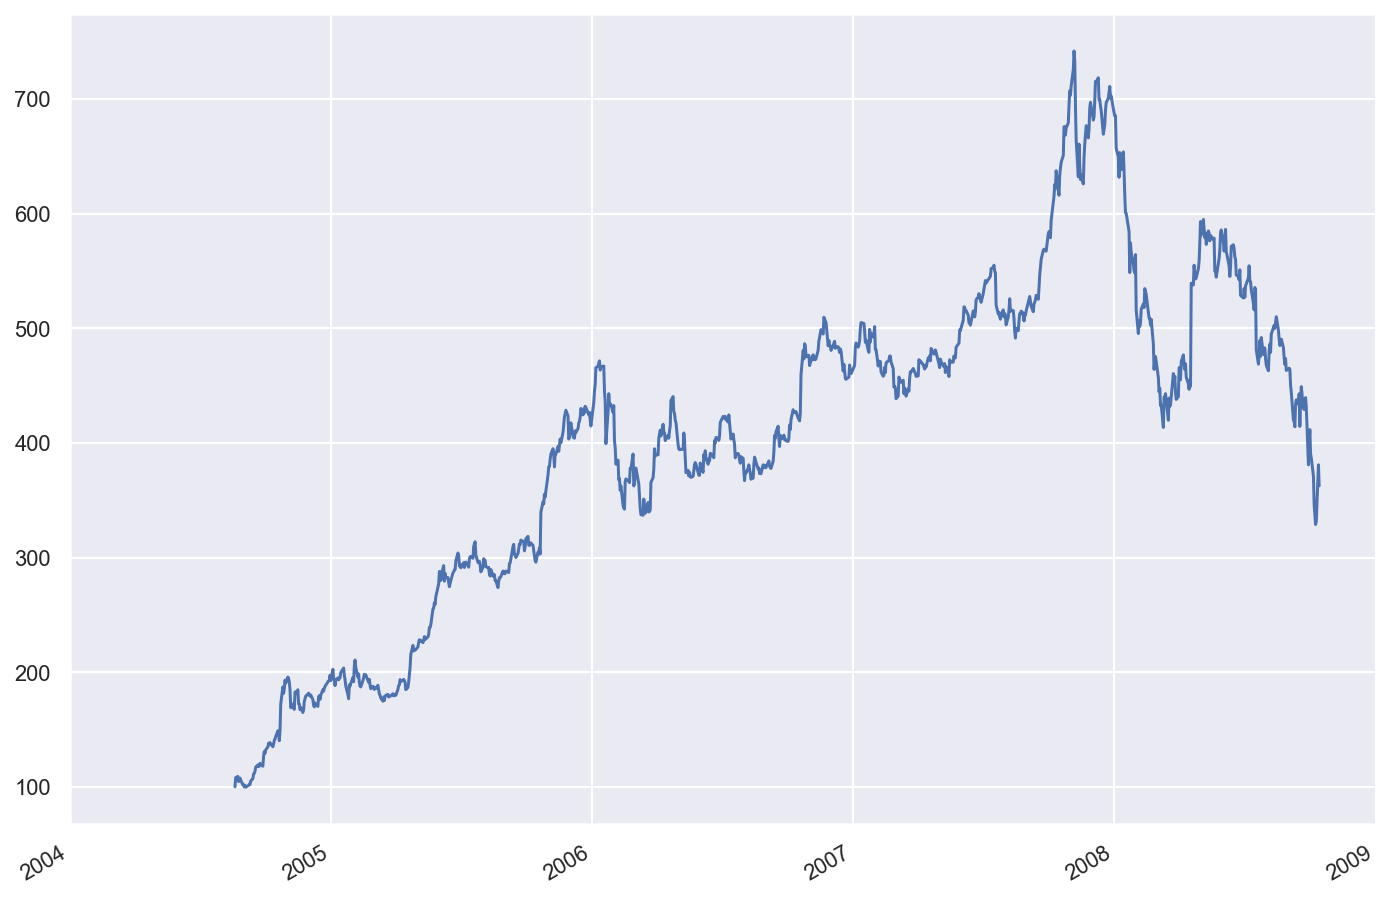

In [47]:
# Example found online -> that's how it should look like!
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# Load a numpy structured array from yahoo csv data with fields date, open,
# close, volume, adj_close from the mpl-data/example directory.  This array
# stores the date as an np.datetime64 with a day unit ('D') in the 'date'
# column.
with cbook.get_sample_data('goog.npz') as datafile:
    data = np.load(datafile)['price_data']

fig, ax = plt.subplots()
ax.plot('date', 'adj_close', data=data)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(data['date'][0], 'Y')
datemax = np.datetime64(data['date'][-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.show()

In [48]:
# Sort now by Date
df1['Date'] =pd.to_datetime(df1.Date)
df1 = df1.sort_values('Date')

# Reset Index
#df1 = df1.reset_index(drop=True)

df1.head()

Date  retweet count  favorite count  key hashtag count  keyword count  \
0 2019-05-02            908            3261                  0              2   
1 2019-05-03            144             379                  1              2   
2 2019-05-06            117             606                  1              1   
3 2019-05-07              3              66                  0              0   
4 2019-05-08             26             159                  0              0   

        High  
0  72.949997  
1  74.000000  
2  74.839996  
3  85.449997  
4  85.379997

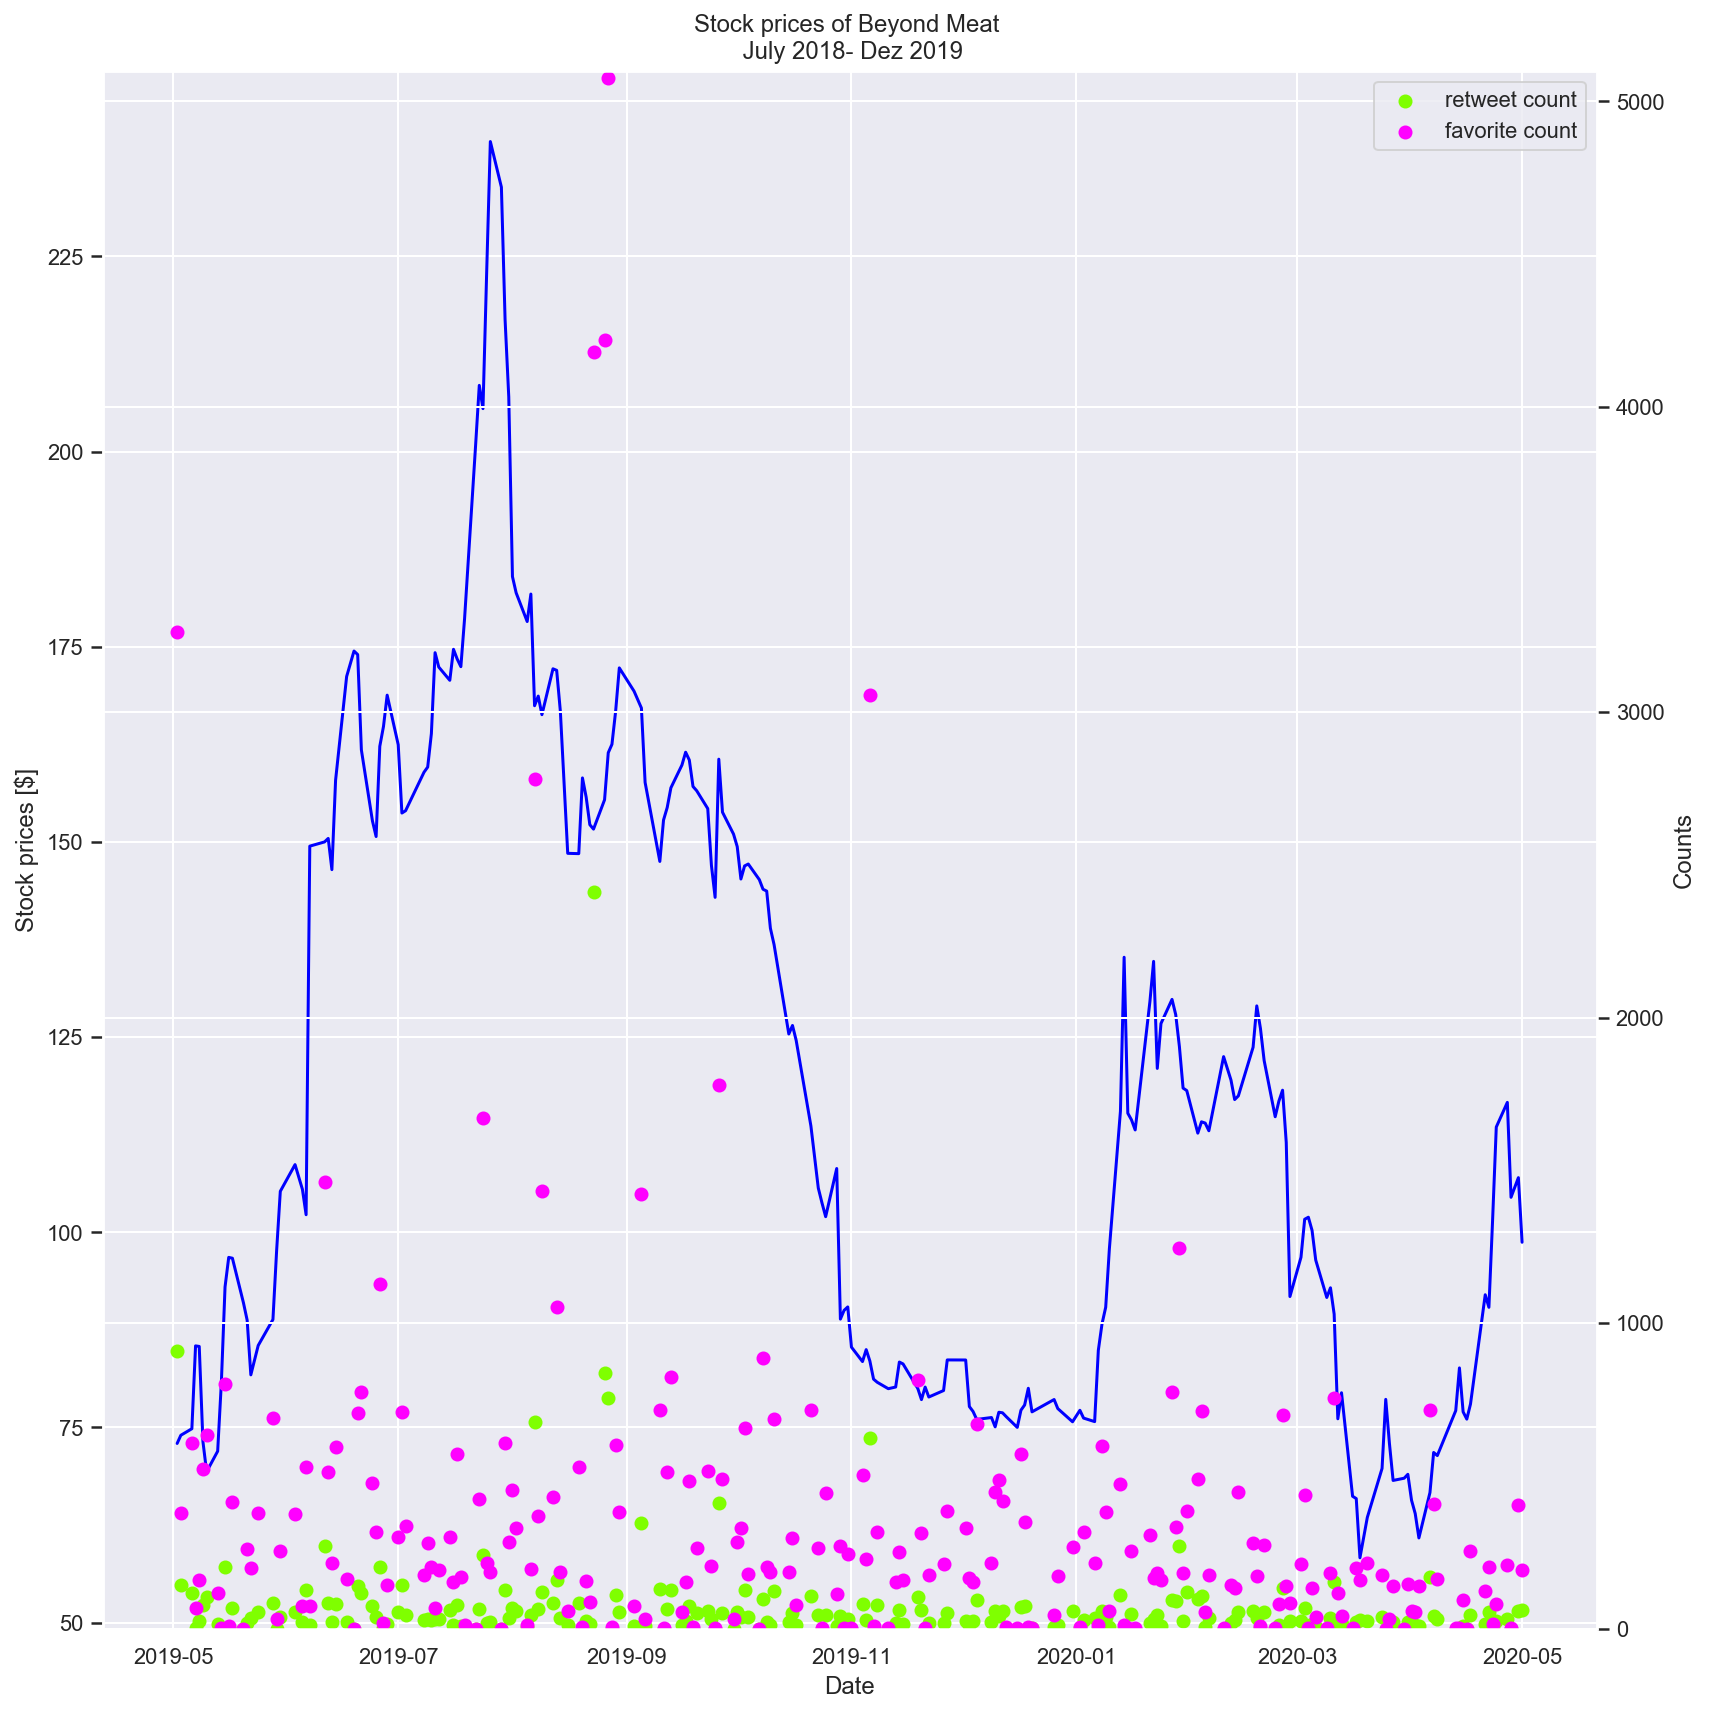

In [49]:
# plot X_num over time period of interest

fig, ax1 = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis for ax1
ax1.plot("Date", "High", data = df1, color= "blue")


# Set title and labels for axes
ax1.set(xlabel="Date",
       ylabel="Stock prices [$]",
       title="Stock prices of Beyond Meat \n July 2018- Dez 2019")

# Define the date format
date_form = DateFormatter("%Y-%m")
ax1.xaxis.set_major_formatter(date_form)

# Ensure a major tick for eg. each month using (interval=1) 
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()

#add x-axise for ax2
ax2.set(ylabel = "Counts", ylim =(0, 5100))
ax2.scatter("Date", "retweet count", data = df1, color = "chartreuse")
ax2.scatter("Date", "favorite count", data = df1, color = "fuchsia")
ax2.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

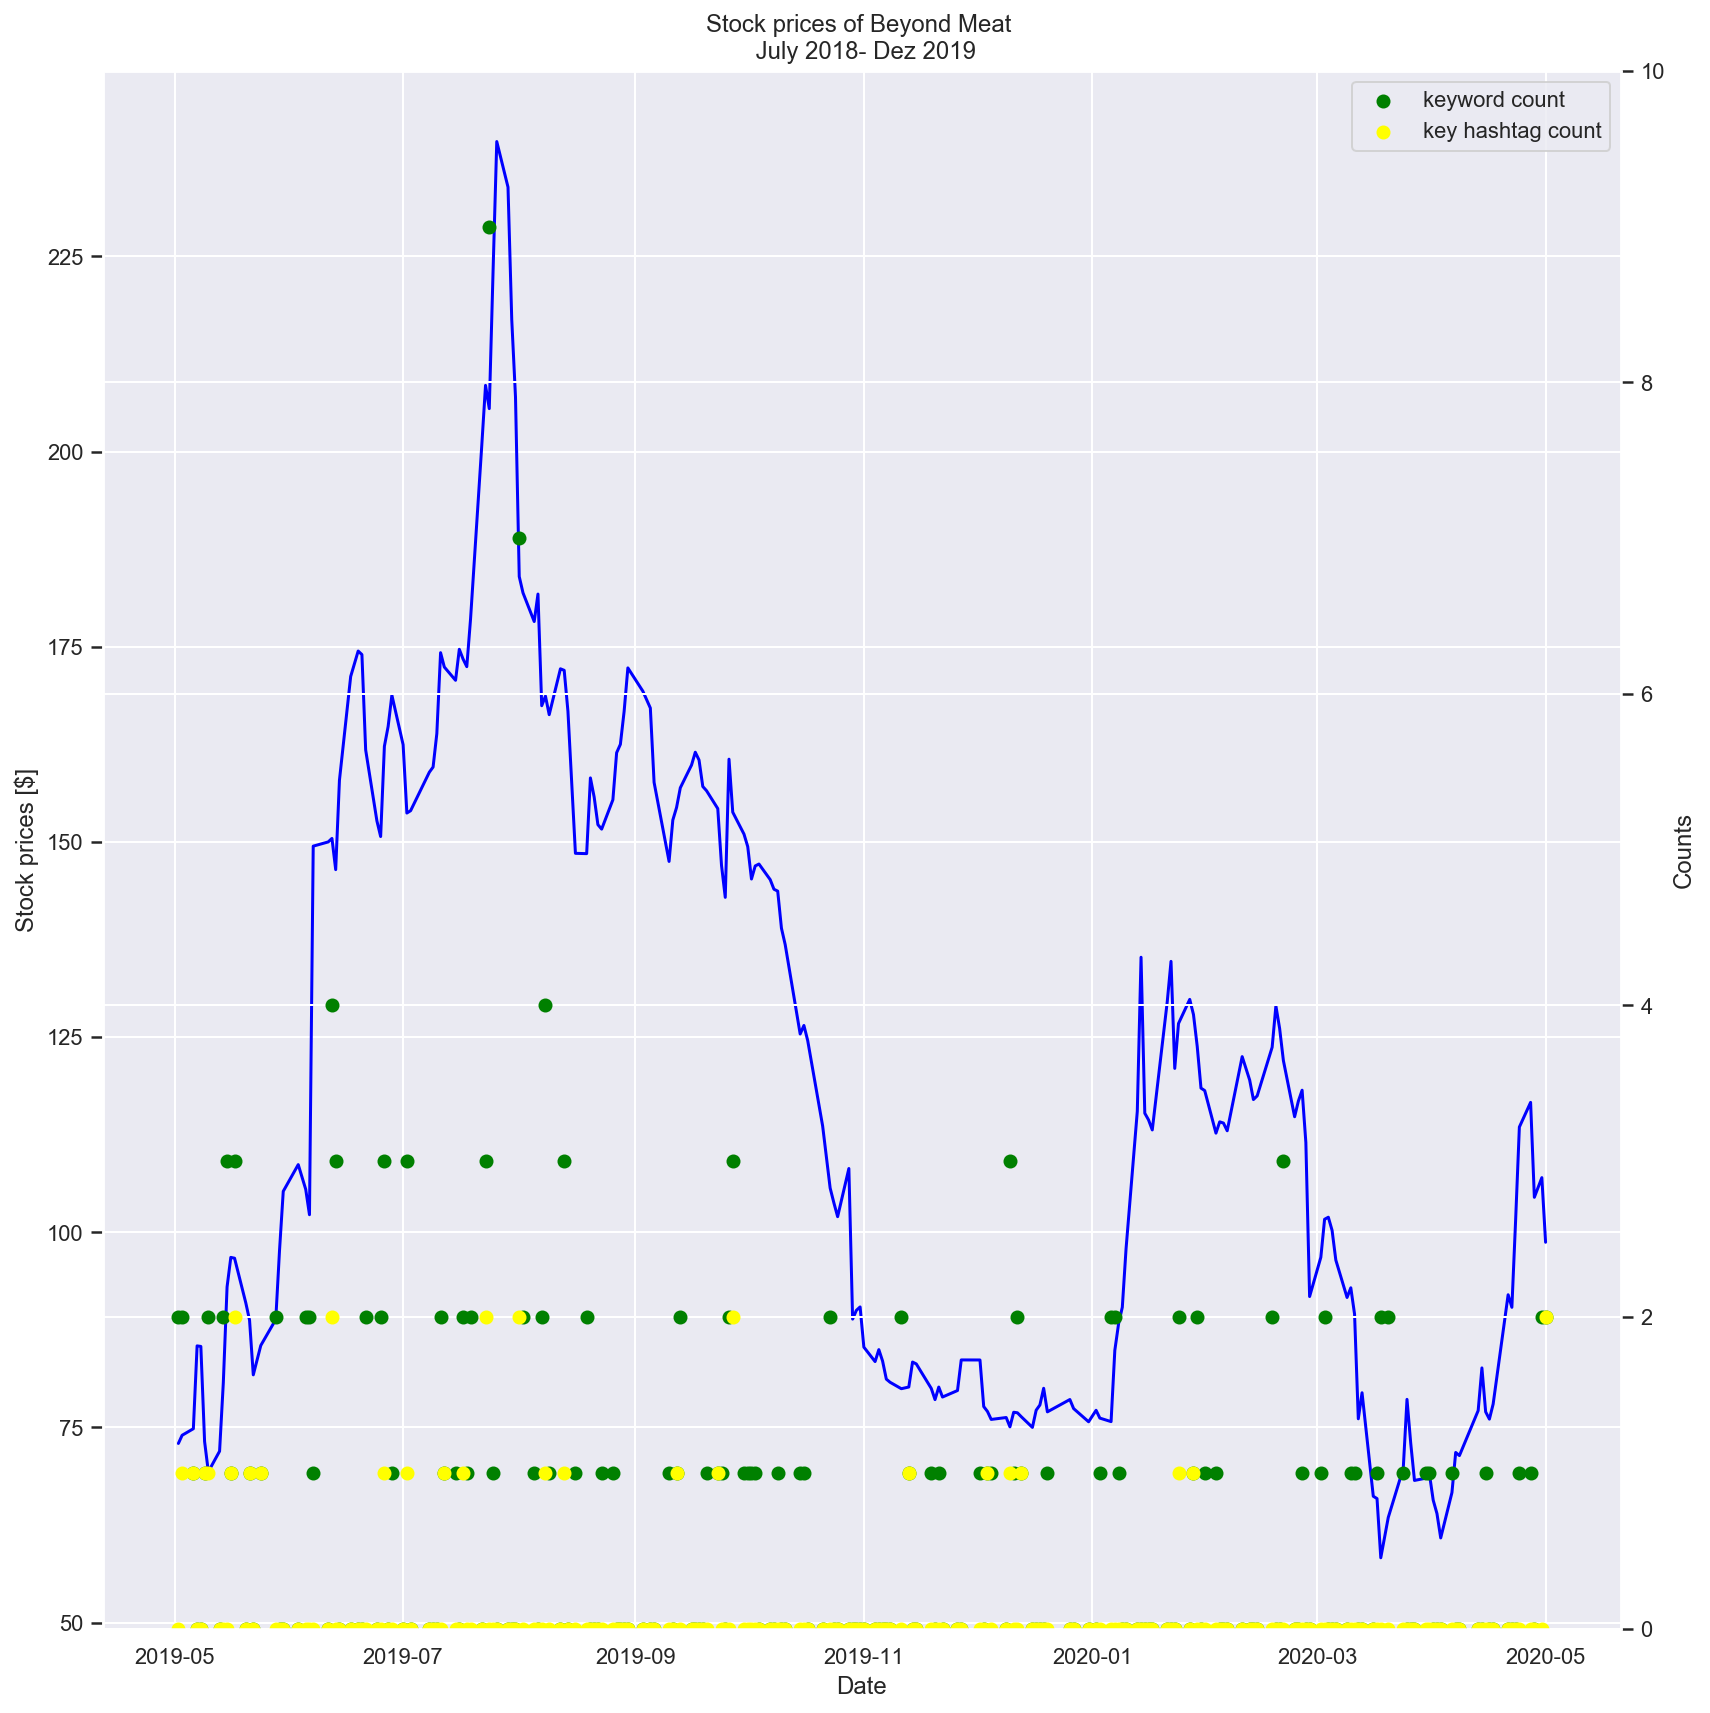

In [50]:
# plot X_num over time period of interest

fig, ax1 = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis for ax1
ax1.plot("Date", "High", data = df1, color= "blue")


# Set title and labels for axes
ax1.set(xlabel="Date",
       ylabel="Stock prices [$]",
       title="Stock prices of Beyond Meat \n July 2018- Dez 2019")

# Define the date format
date_form = DateFormatter("%Y-%m")
ax1.xaxis.set_major_formatter(date_form)

# Ensure a major tick for eg. each month using (interval=1) 
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()

#add x-axise for ax2
ax2.set(ylabel = "Counts", ylim = (0,10))
ax2.scatter("Date", "keyword count", data = df1, color = "green")
ax2.scatter("Date", "key hashtag count", data = df1, color = "yellow")
ax2.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## **Step 2a: estimate different regression models using `X_num` and `y`** [week 3]

**Sample split.** Do the standard 80% / 20% training/test split using all days in the data. In addition, do a separate temporal split where the training set is the first 80% of days in the time series.
**For all machine learning models**, report performance measure in test and train samples.

In [51]:
df1.head()

Date  retweet count  favorite count  key hashtag count  keyword count  \
0 2019-05-02            908            3261                  0              2   
1 2019-05-03            144             379                  1              2   
2 2019-05-06            117             606                  1              1   
3 2019-05-07              3              66                  0              0   
4 2019-05-08             26             159                  0              0   

        High  
0  72.949997  
1  74.000000  
2  74.839996  
3  85.449997  
4  85.379997

In [52]:
# from datafram to array (w/d "Date" column)
X_full = df1[['retweet count','favorite count','key hashtag count','keyword count']].to_numpy()
X_full.shape

(226, 4)

In [53]:
# from datafram to array
Y_full = df1['High'].to_numpy()
Y_full.shape

(226,)

In [54]:
X_df=pd.DataFrame(X_full, columns=['retweet count','favorite count','key hashtag count','keyword count'])
X_df.head()

retweet count  favorite count  key hashtag count  keyword count
0            908            3261                  0              2
1            144             379                  1              2
2            117             606                  1              1
3              3              66                  0              0
4             26             159                  0              0

In [55]:
X_df.isnull().sum()

retweet count        0
favorite count       0
key hashtag count    0
keyword count        0
dtype: int64

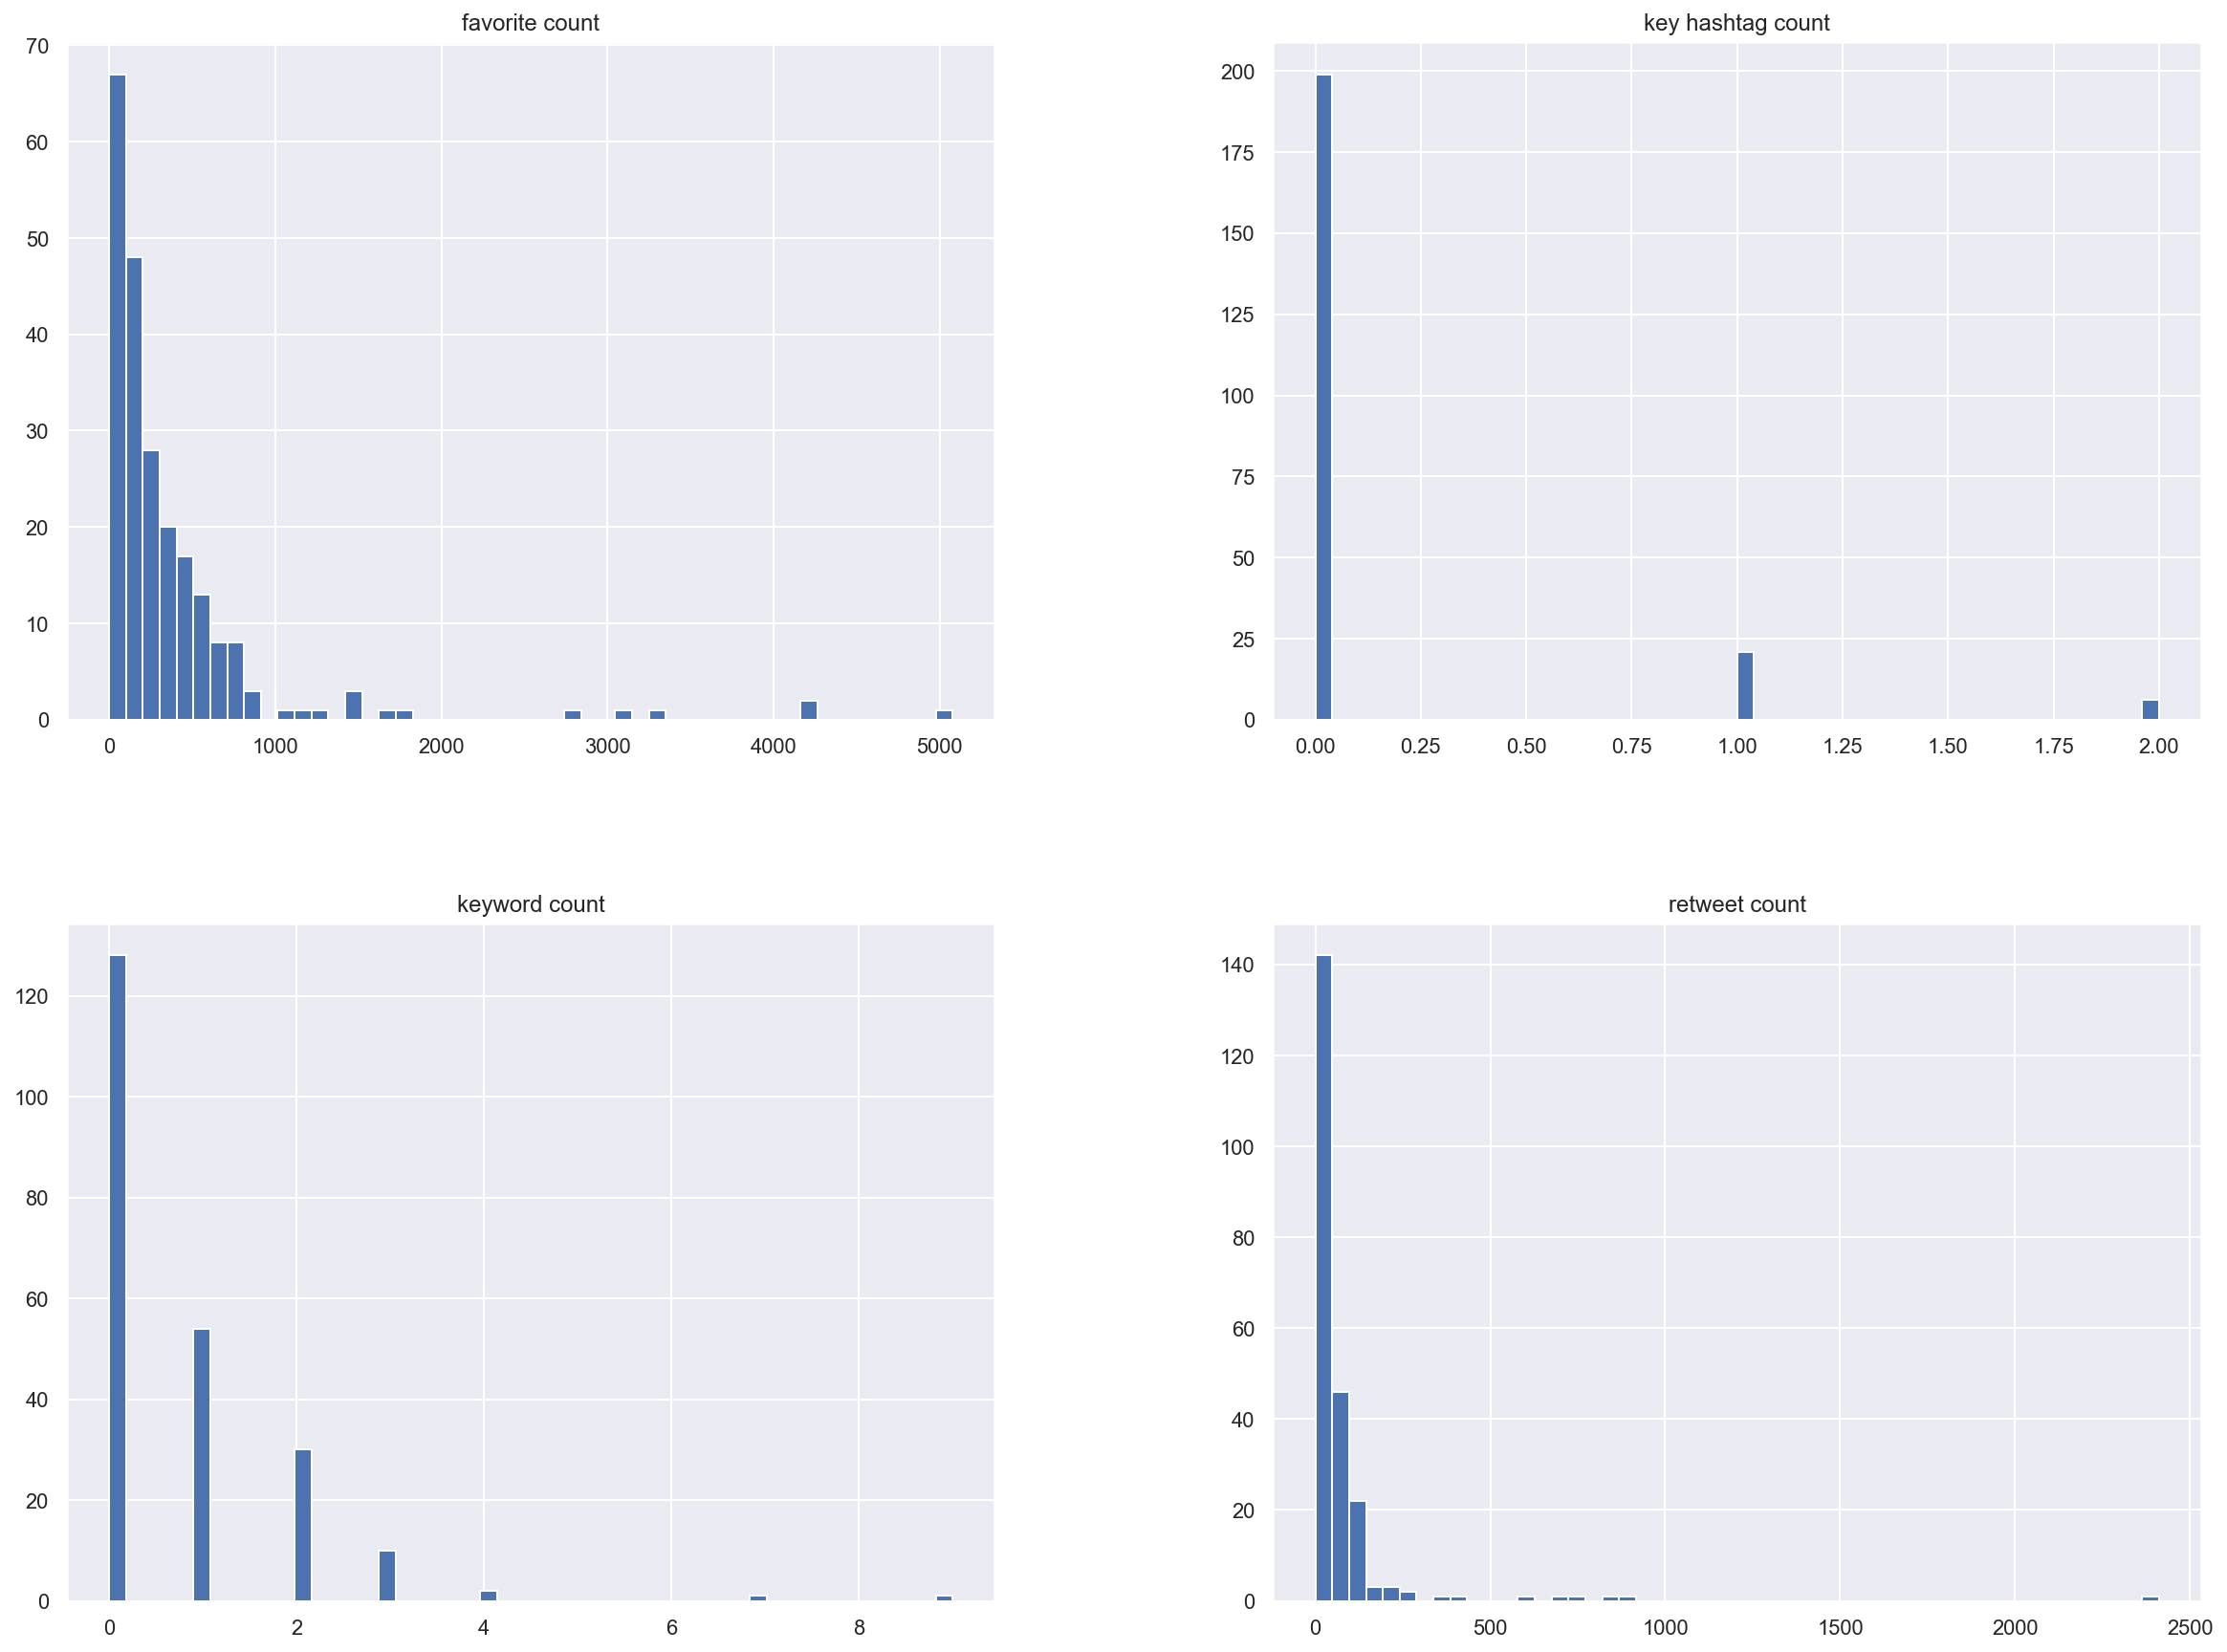

In [56]:
X_df.hist(bins=50, figsize=(20,15))
plt.show()

In [57]:
# top retweet counts
print(X_df.sort_values('retweet count', ascending=False).head(10))

     retweet count  favorite count  key hashtag count  keyword count
72            2411            4179                  0              1
0              908            3261                  0              2
73             838            4217                  0              1
74             756            5077                  0              0
61             677            2780                  0              2
119            623            3057                  0              0
93             412            1781                  0              2
79             345            1422                  0              0
23             272            1461                  0              0
167            271            1247                  0              2


In [58]:
# top favorite counts
print(X_df.sort_values('favorite count', ascending=False).head(10))

     retweet count  favorite count  key hashtag count  keyword count
74             756            5077                  0              0
73             838            4217                  0              1
72            2411            4179                  0              1
0              908            3261                  0              2
119            623            3057                  0              0
61             677            2780                  0              2
93             412            1781                  0              2
51             240            1671                  0              9
23             272            1461                  0              0
63             121            1433                  0              1


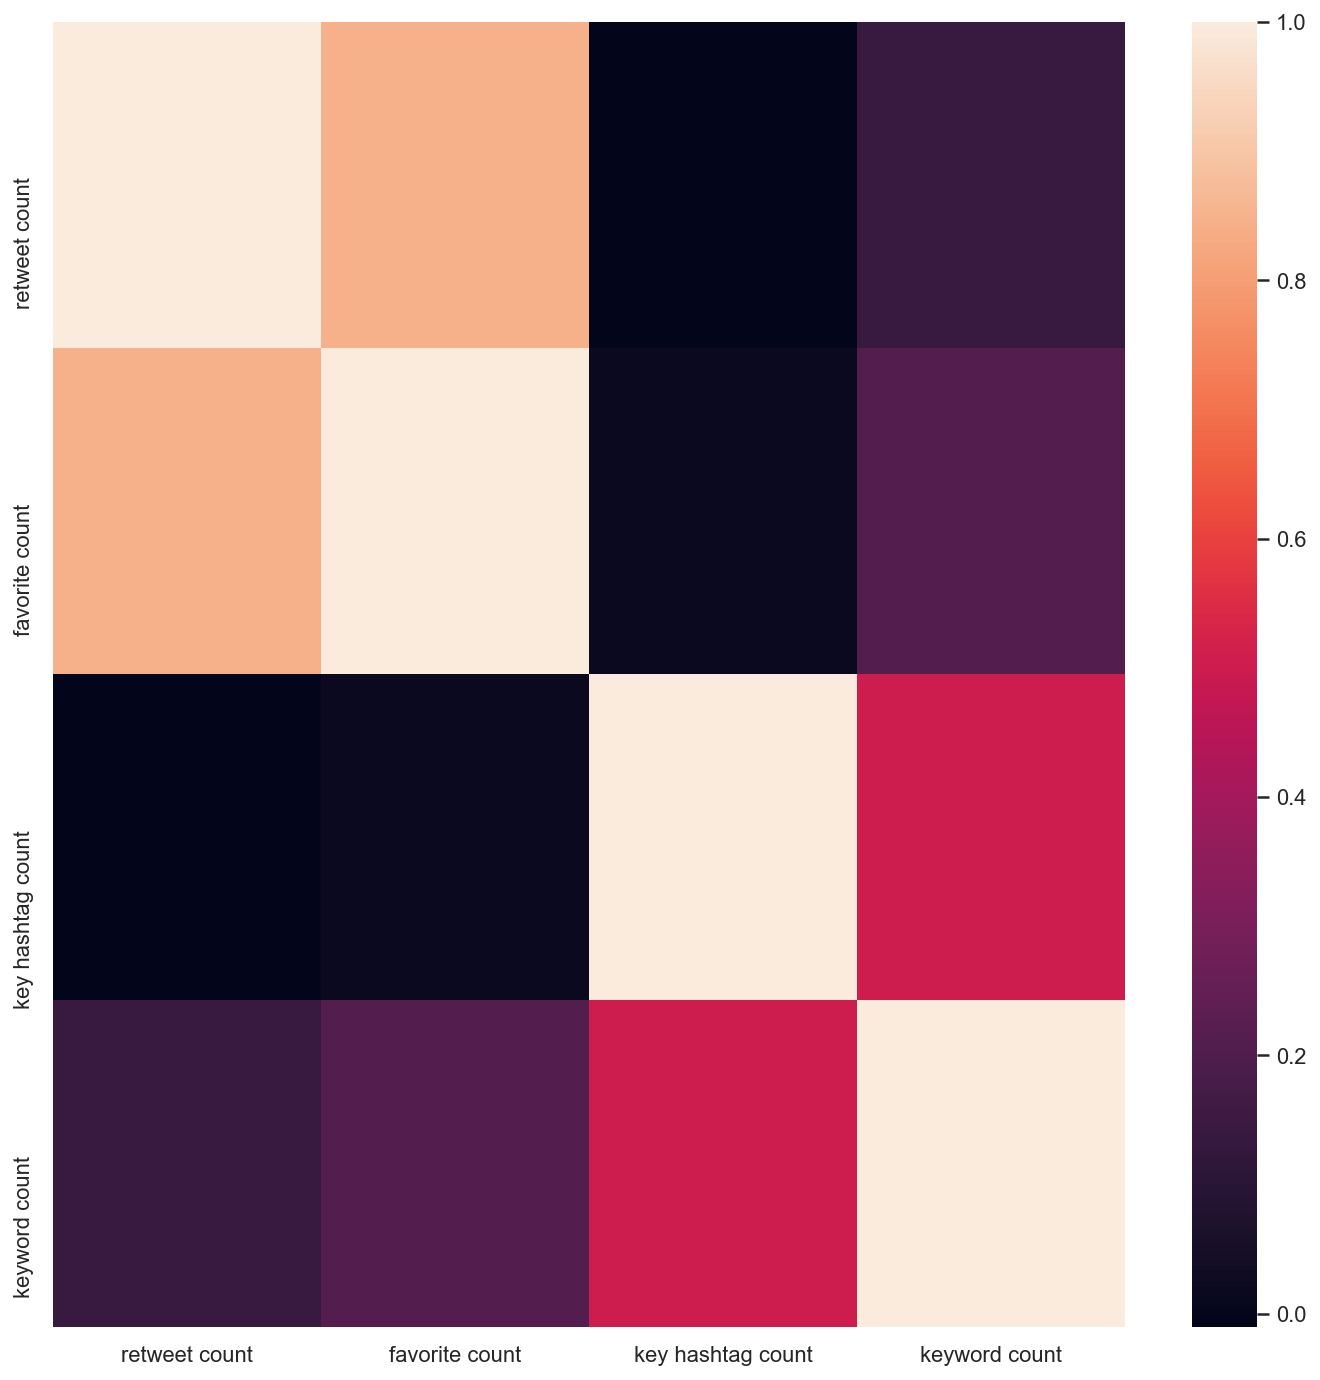

In [59]:
sns.set(rc={'figure.figsize':(12,12)})
correlation_matrix = X_df.corr().round(2)
sns.heatmap(correlation_matrix) #annot=True
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018F29BB2AC8>,
      dtype=object)

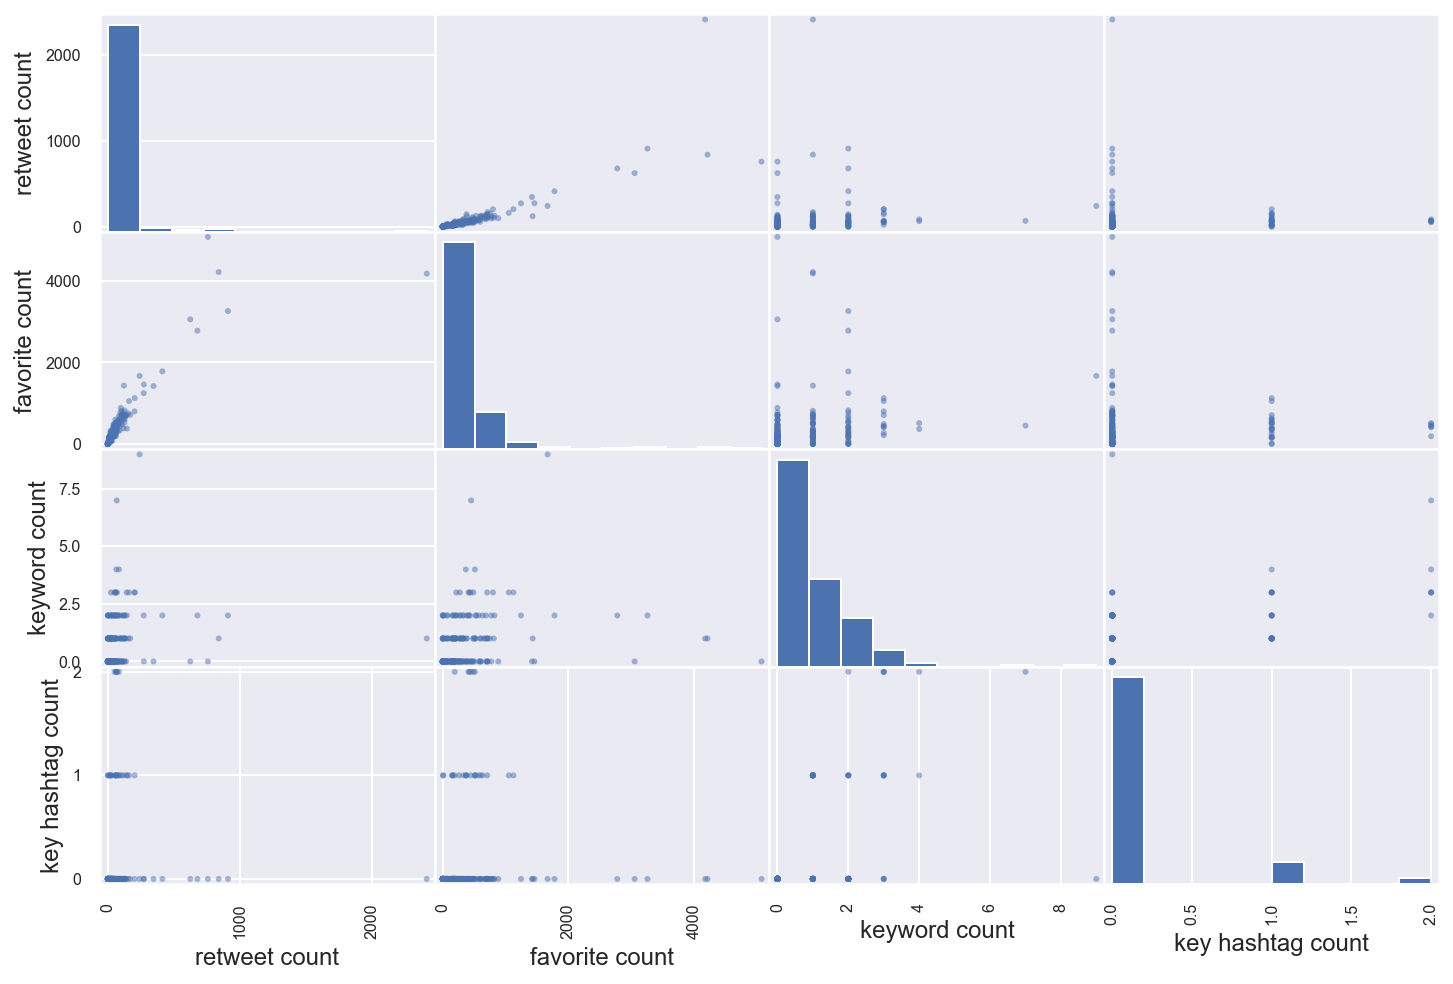

In [60]:
# correlation plots
from pandas.plotting import scatter_matrix
scatter_matrix(X_df[['retweet count', 'favorite count','keyword count', 'key hashtag count']], figsize=(12, 8))

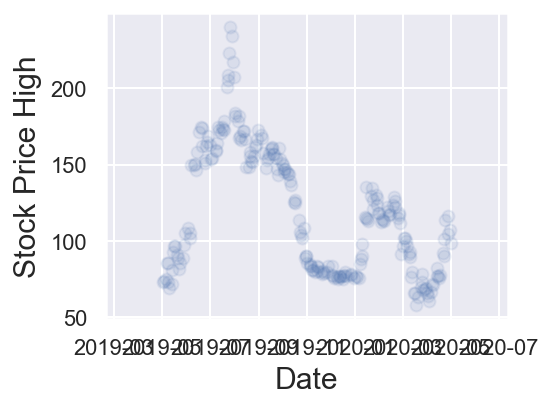

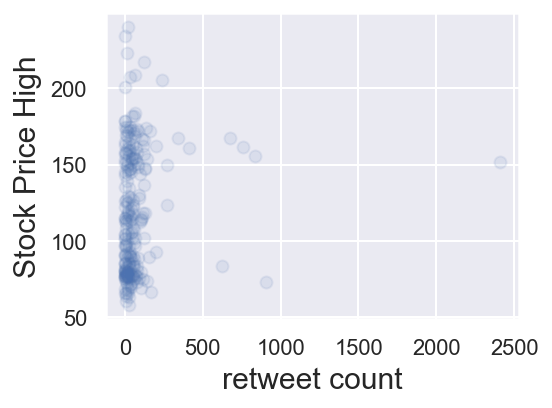

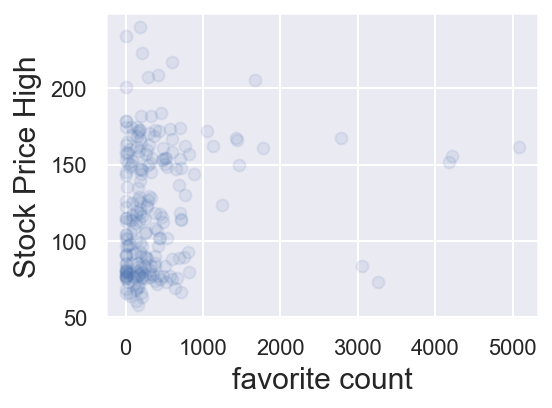

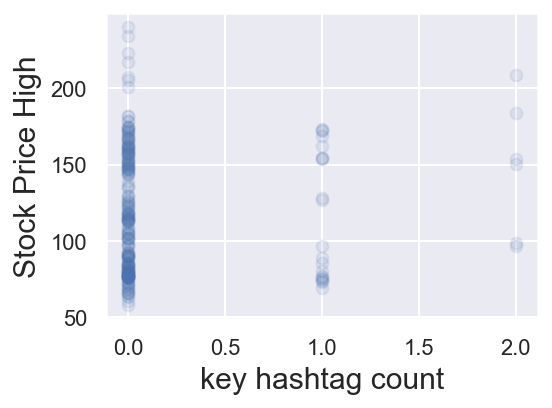

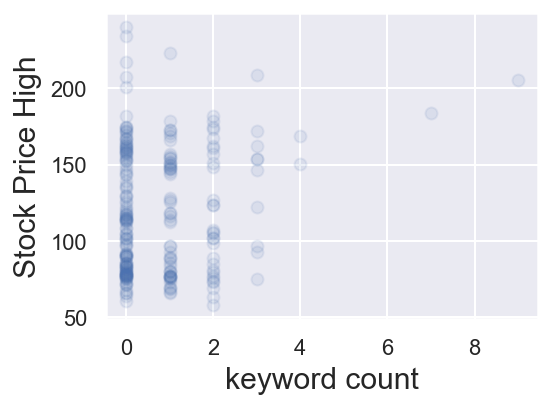

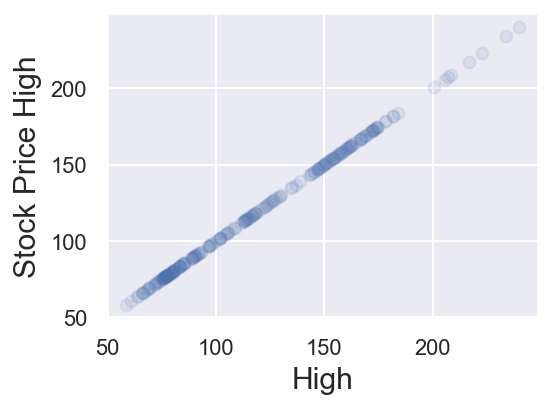

In [61]:
# scatter plot relative to the target (stock price)
for feature_name in df1.columns:
    plt.figure(figsize=(4, 3))
    plt.scatter(df1[feature_name], y, alpha=0.1)
    plt.ylabel('Stock Price High', size=15)
    plt.xlabel(feature_name, size=15)
    plt.tight_layout()

In [62]:
df1.head()

Date  retweet count  favorite count  key hashtag count  keyword count  \
0 2019-05-02            908            3261                  0              2   
1 2019-05-03            144             379                  1              2   
2 2019-05-06            117             606                  1              1   
3 2019-05-07              3              66                  0              0   
4 2019-05-08             26             159                  0              0   

        High  
0  72.949997  
1  74.000000  
2  74.839996  
3  85.449997  
4  85.379997

In [63]:
df1.shape

(226, 6)

To have a better fit of the models, let's remove some outliners and do some data cleaning.

#### Data cleaning:

In [64]:
mask = np.logical_or.reduce((X_full[:,0]>300, # MIN retweet count 300 or 
                             X_full[:,1]>300, # MIN favorite count 300 or
                             X_full[:,2]>1, # MIN key hashtag count 2 or 
                             X_full[:,3]>1)) # MIN keyword count 2

# Drop the observations 
Y_full=Y_full[mask==True]
X_full=X_full[mask==True]
X_df=X_df[mask==True]
X_full.shape

(99, 4)

In [65]:
# Removing outliner
mask1 = X_full[:,0]<800 # MAX retweet count <800
Y_full=Y_full[mask1==True]
X_full=X_full[mask1==True]
X_df=X_df[mask1==True]
X_full.shape

(96, 4)

In [66]:
# Removing outliner
mask2 = X_full[:,1]<1400 # MAX favorite count <1400
Y_full=Y_full[mask2==True]
X_full=X_full[mask2==True]
X_df=X_df[mask2==True]
X_full.shape

(88, 4)

In [67]:
# Removing outliner
mask3 = X_full[:,2]<3 # MAX key hashtag count 2
Y_full=Y_full[mask3==True]
X_full=X_full[mask3==True]
X_df=X_df[mask3==True]
X_full.shape

(88, 4)

In [68]:
# Removing outliner
mask4 = X_full[:,3]<5 # MAX keyword count 4
Y_full=Y_full[mask4==True]
X_full=X_full[mask4==True]
X_df=X_df[mask4==True]
X_full.shape

(87, 4)

### Split train test sets 

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full, Y_full, test_size=0.2, random_state=1)

In [70]:
print("train data", X_train.shape, y_train.shape)
print("test data", X_test.shape,  y_test.shape)

train data (69, 4) (69,)
test data (18, 4) (18,)


In addition, do a separate temporal split where the training set is the first 80% of days in the time series

In [71]:
# create benchmark
bench = int(len(Y_full)*0.8) # 80% of the data

# for the Y_full variable
y_train2 = Y_full[:bench]
y_test2 = Y_full[bench:]

# for the X_full variable
X_train2 = X_full[:bench]
X_test2 = X_full[bench:]

In [72]:
print("temporal train data", X_train2.shape, y_train2.shape)
print("temporal test data", X_test2.shape,  y_test2.shape)

temporal train data (69, 4) (69,)
temporal test data (18, 4) (18,)


#### Feature Scaling
Most common scaling methods: 
- **standardization**= normalization by substracting the mean and dividing by the standard deviation (values are not bounded)
- **Min-max scaling**= normalization by substracting the minimum and dividing by the maximum (values between `0` and `1`)

In [73]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# for random splitting
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# for temporal split
scaler2 = StandardScaler().fit(X_train2)
X_train2_scaled = scaler.transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

## Linear regression

### Linear Regression - Randomized Splitting

In [74]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

In [75]:
# randomized splitting
# use non-standardized data for randomized splitting:
lin_reg.fit(X_train, y_train)
print("R-squared for training dataset:{}".
      format(np.round(lin_reg.score(X_train, y_train), 2)))

R-squared for training dataset:0.07


In [76]:
# randomized splitting
# use standardized data for randomized splitting: 
lin_reg.fit(X_train_scaled, y_train)
print("R-squared for training dataset & scaled features:{}".
      format(np.round(lin_reg.score(X_train_scaled, y_train), 2)))

R-squared for training dataset & scaled features:0.07


In [77]:
features = list(X_df.columns)

print('The coefficients of the features from the linear model:')
print(dict(zip(features, [round(x, 2) for x in lin_reg.coef_])))

The coefficients of the features from the linear model:
{'retweet count': -6.38, 'favorite count': 9.07, 'key hashtag count': 5.03, 'keyword count': 4.99}


#### Mean squared log error

In [78]:
from sklearn.metrics import mean_squared_error
# randomized splitting
# in-sample performance (train data)
y_train_pred = lin_reg.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
print("RMS: %s" % train_rmse) # = np.sqrt(np.mean((predicted - expected) ** 2))

RMS: 4366.183666508694


In [79]:
# randomized splitting
# out-of-sample performance (test data)
y_test_pred = lin_reg.predict(X_test)        
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("RMS: %s" % test_rmse) 

RMS: 3872.0673075329614


#### Explained variance and $r^2$-score:

In [80]:
from sklearn.metrics import r2_score
# randomized splitting
r2 = round(r2_score(y_test, y_test_pred), 2)
print("R2: %s" % r2)

R2: -9587.24


In [81]:
from sklearn.metrics import explained_variance_score
exp_var = round(explained_variance_score(y_test,y_test_pred),2)
print("Explained variance: %s" % exp_var)

Explained variance: -1697.16


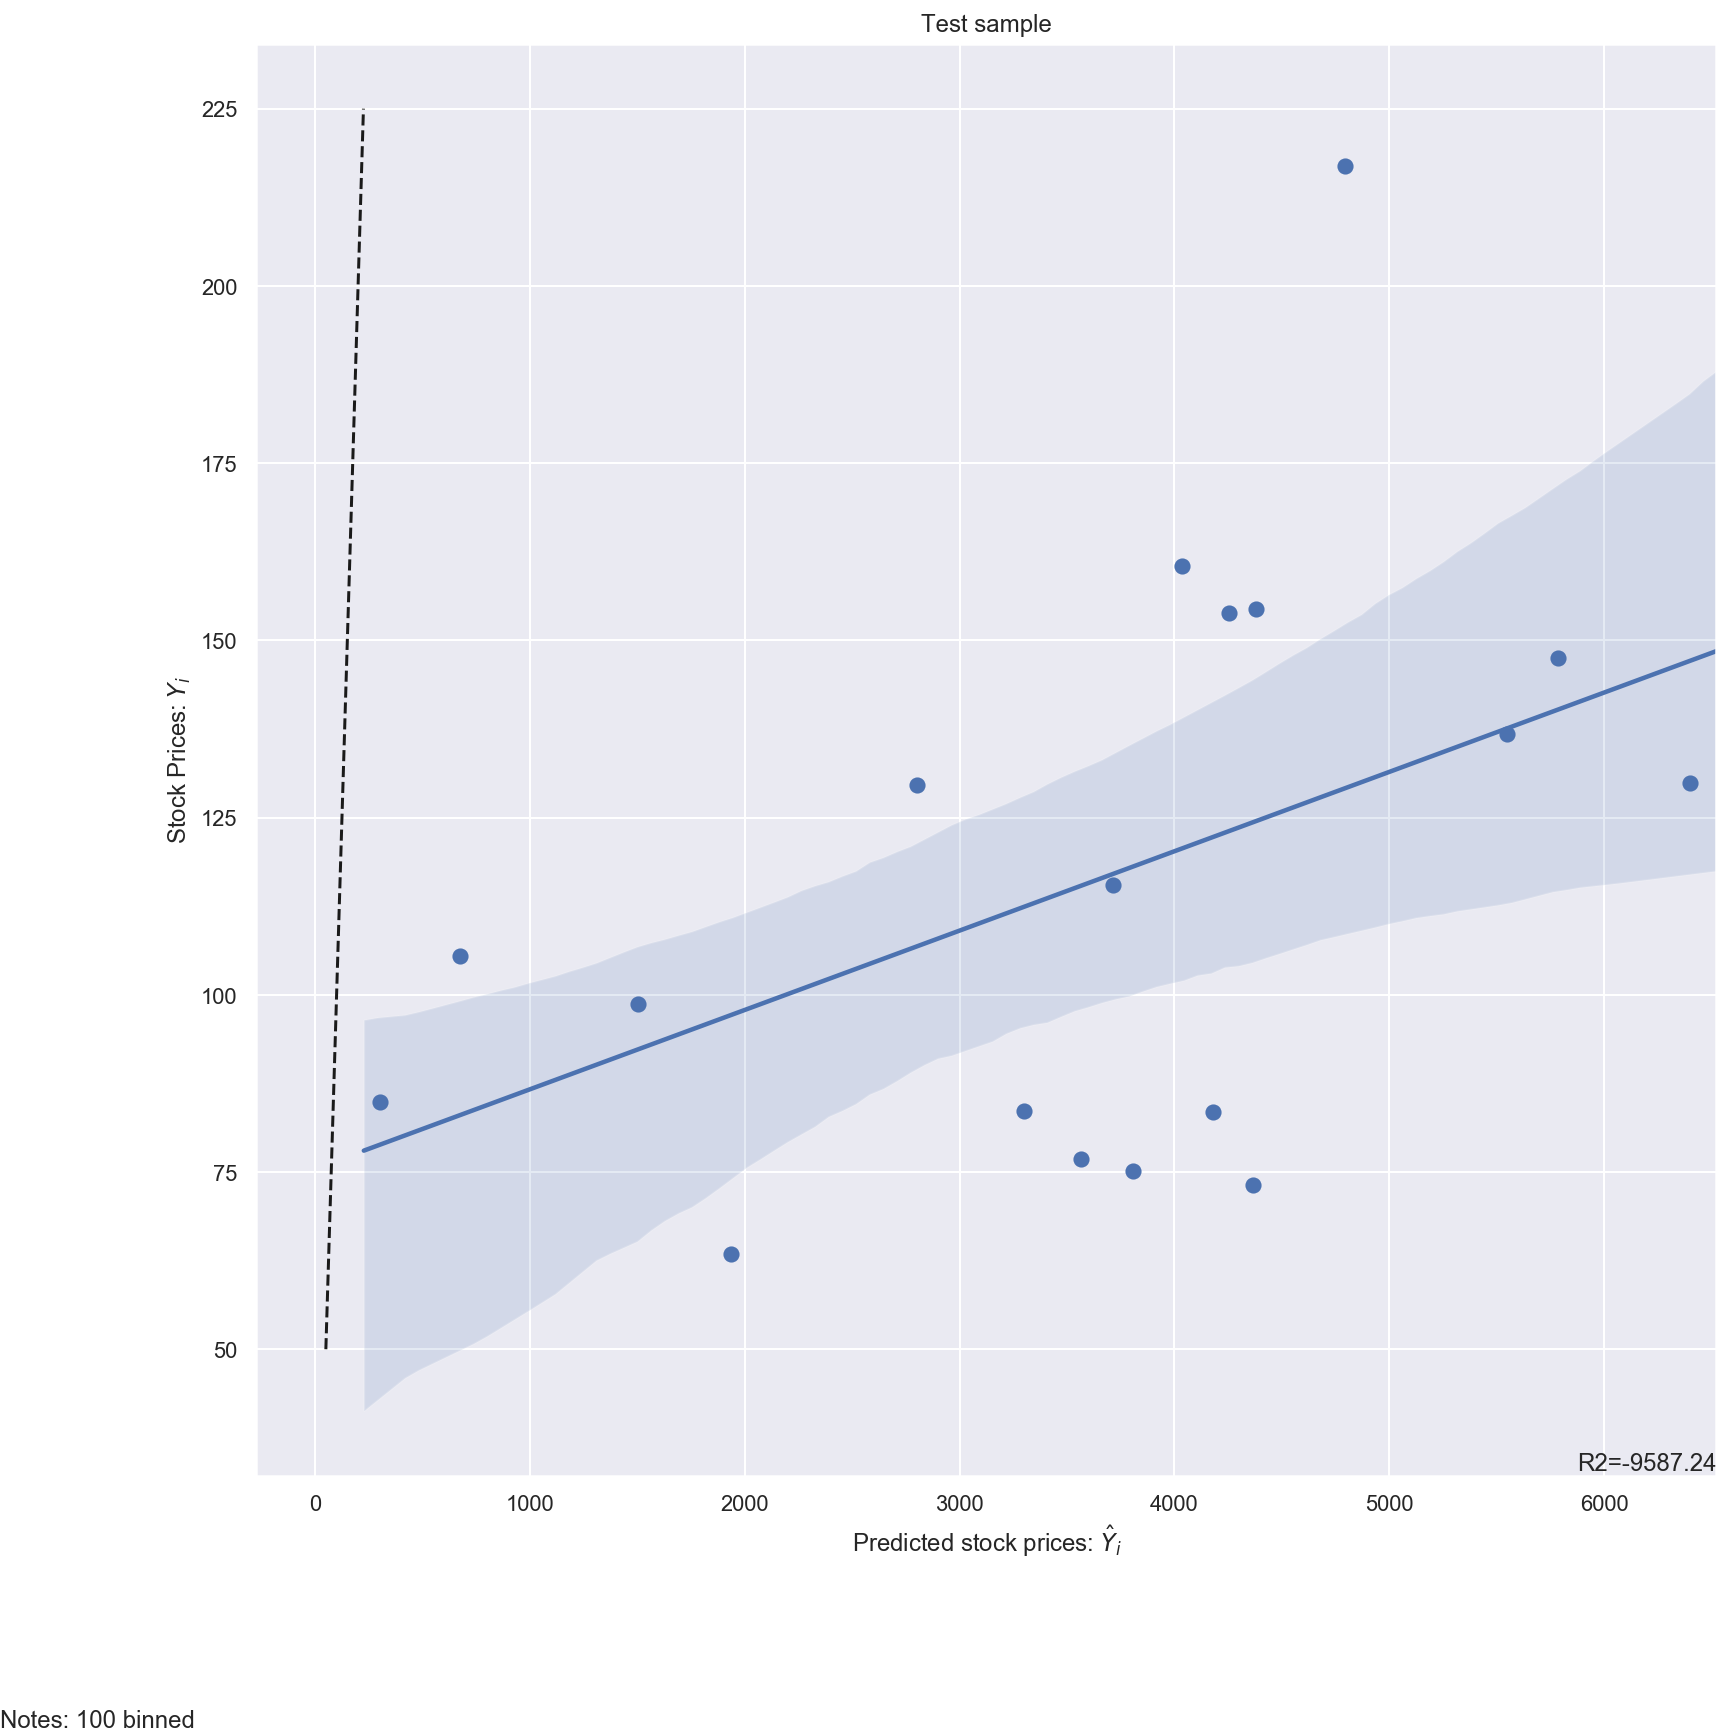

In [82]:
# Regplot
g=sns.regplot(x= y_test_pred, y=y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([50, 225], [50, 225], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

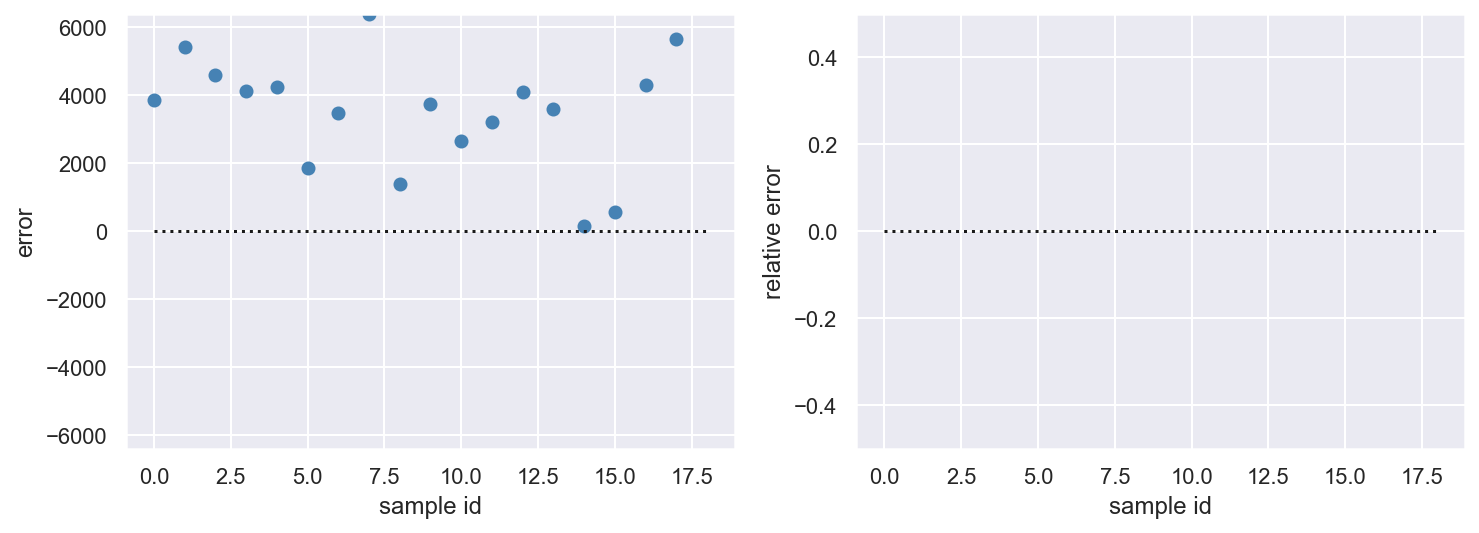

In [83]:
#Let us plot how good given and predicted values match on the training data set
def plot_fit_quality(values_test, predicted):
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)

    x = np.arange(len(predicted))
    plt.scatter(x, predicted - values_test, color='steelblue', marker='o') 

    plt.plot([0, len(predicted)], [0, 0], "k:")
    
    max_diff = np.max(np.abs(predicted - values_test))
    plt.ylim([-max_diff, max_diff])
    
    plt.ylabel("error")
    plt.xlabel("sample id")

    plt.subplot(1, 2, 2)

    plt.scatter(x, (predicted - values_test) / values_test, color='steelblue', marker='o') 
    plt.plot([0, len(predicted)], [0, 0], "k:")
    plt.ylim([-.5, .5])
      
    plt.ylabel("relative error")
    plt.xlabel("sample id")

plot_fit_quality(y_test, y_test_pred)

### Linear Regression - Temporal Splitting

In [84]:
# temporal splitting
# use non-standardized data for temporal split:
lin_reg.fit(X_train2, y_train2)
print("R-squared for training dataset:{}".
      format(np.round(lin_reg.score(X_train2, y_train2), 2)))

R-squared for training dataset:0.05


In [85]:
# temporal splitting
# use standardized data for temporal split:
lin_reg.fit(X_train2_scaled, y_train2)
print("R-squared for training dataset:{}".
      format(np.round(lin_reg.score(X_train2_scaled, y_train2), 2)))

R-squared for training dataset:0.05


In [86]:
features = list(X_df.columns)

print('The coefficients of the features from the linear model:')
print(dict(zip(features, [round(x, 2) for x in lin_reg.coef_])))

The coefficients of the features from the linear model:
{'retweet count': 3.94, 'favorite count': 4.17, 'key hashtag count': 3.13, 'keyword count': 1.38}


#### Mean squared log error

In [87]:
# temporal splitting
# in-sample performance (train data)
y_train2_pred = lin_reg.predict(X_train2)
train2_mse = mean_squared_error(y_train2, y_train2_pred)
train2_rmse = np.sqrt(train2_mse)
print("RMS: %s" % train2_rmse) # = np.sqrt(np.mean((predicted - expected) ** 2))

RMS: 2516.087434927308


In [88]:
# temporal splitting
# out-of-sample performance (test data)
y_test2_pred = lin_reg.predict(X_test2)        
test2_mse = mean_squared_error(y_test2, y_test2_pred)
test2_rmse = np.sqrt(test2_mse)
print("RMS: %s" % test2_rmse) 

RMS: 2788.474386350209


#### Explained variance and $r^2$-score:

In [89]:
# temporal splitting
r2=round(r2_score(y_test2, y_test2_pred), 2)
print("R2: %s" % r2)

R2: -14709.98


In [90]:
exp_var = round(explained_variance_score(y_test2,y_test2_pred),2)
print("Explained variance: %s" % exp_var)

Explained variance: -3291.15


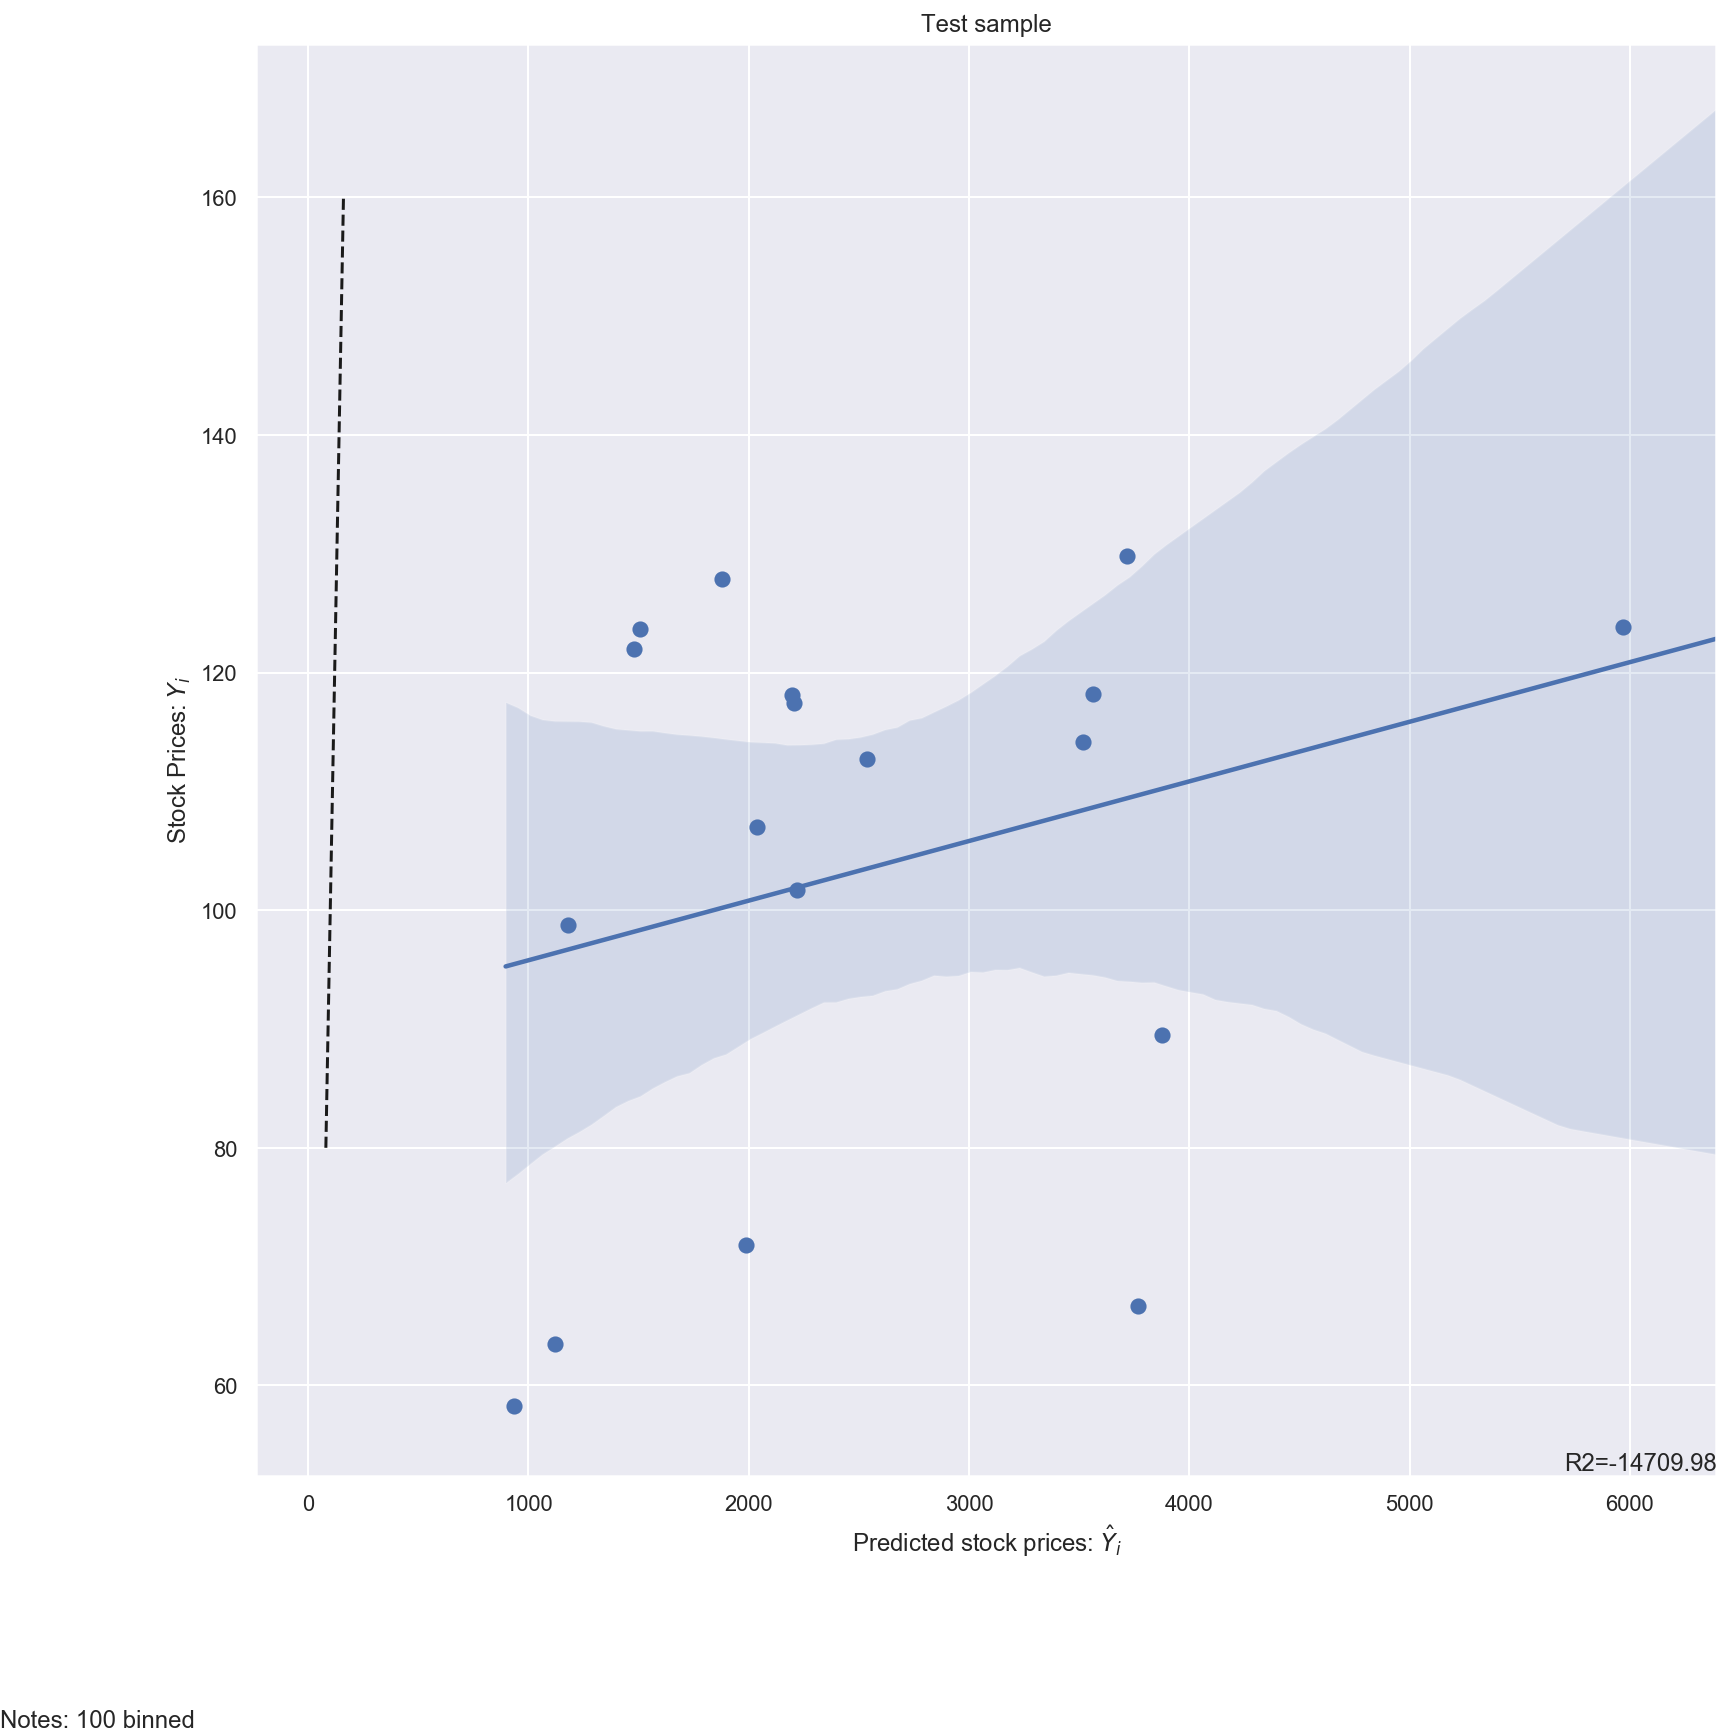

In [91]:
# Regplot
g=sns.regplot(x= y_test2_pred, y=y_test2, x_bins= 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([80, 160], [80, 160], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

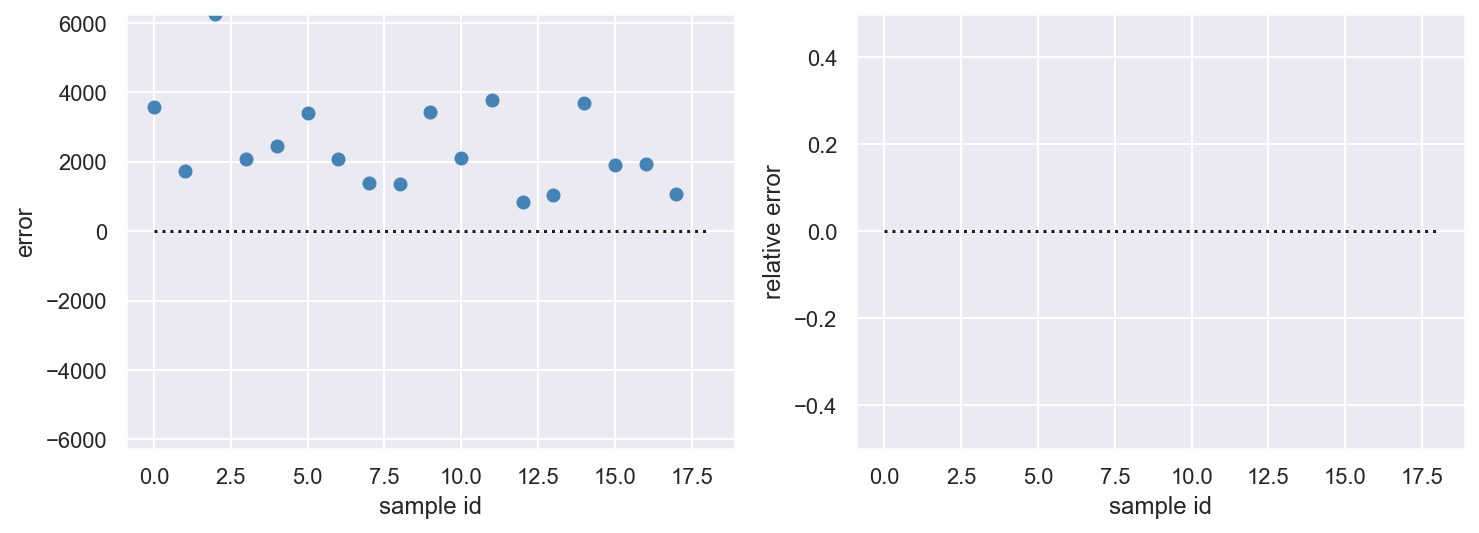

In [92]:
#Let us plot how good given and predicted values match on the training data set 
plot_fit_quality(y_test2, y_test2_pred)

As one can expect, the linear regression model does not yield useful results. But this makes sense, since the relationship (if there is one) between twitter data and the stock price can hardly be linear. Even if there is no twitter activity, stock prices might fluctuate. On the other hand, abnormal high stock prices will probably stimulate disproportionate twitter activity.
So let's have a look how other models handle this:

## Ridge Regression

### Ridge Regression - Randomized Splitting

In [93]:
from sklearn.linear_model import Ridge
# randomized splitting
ridge_reg = Ridge(alpha=1)       
ridge_reg.fit(X_train, y_train)

y_train_pred = ridge_reg.predict(X_train)
y_test_pred = ridge_reg.predict(X_test) 

train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 4)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 4)) 

train RMS: 36.576816620998734
test RMS: 41.714912316238845
train R2: 0.0653
test R2: -0.1128


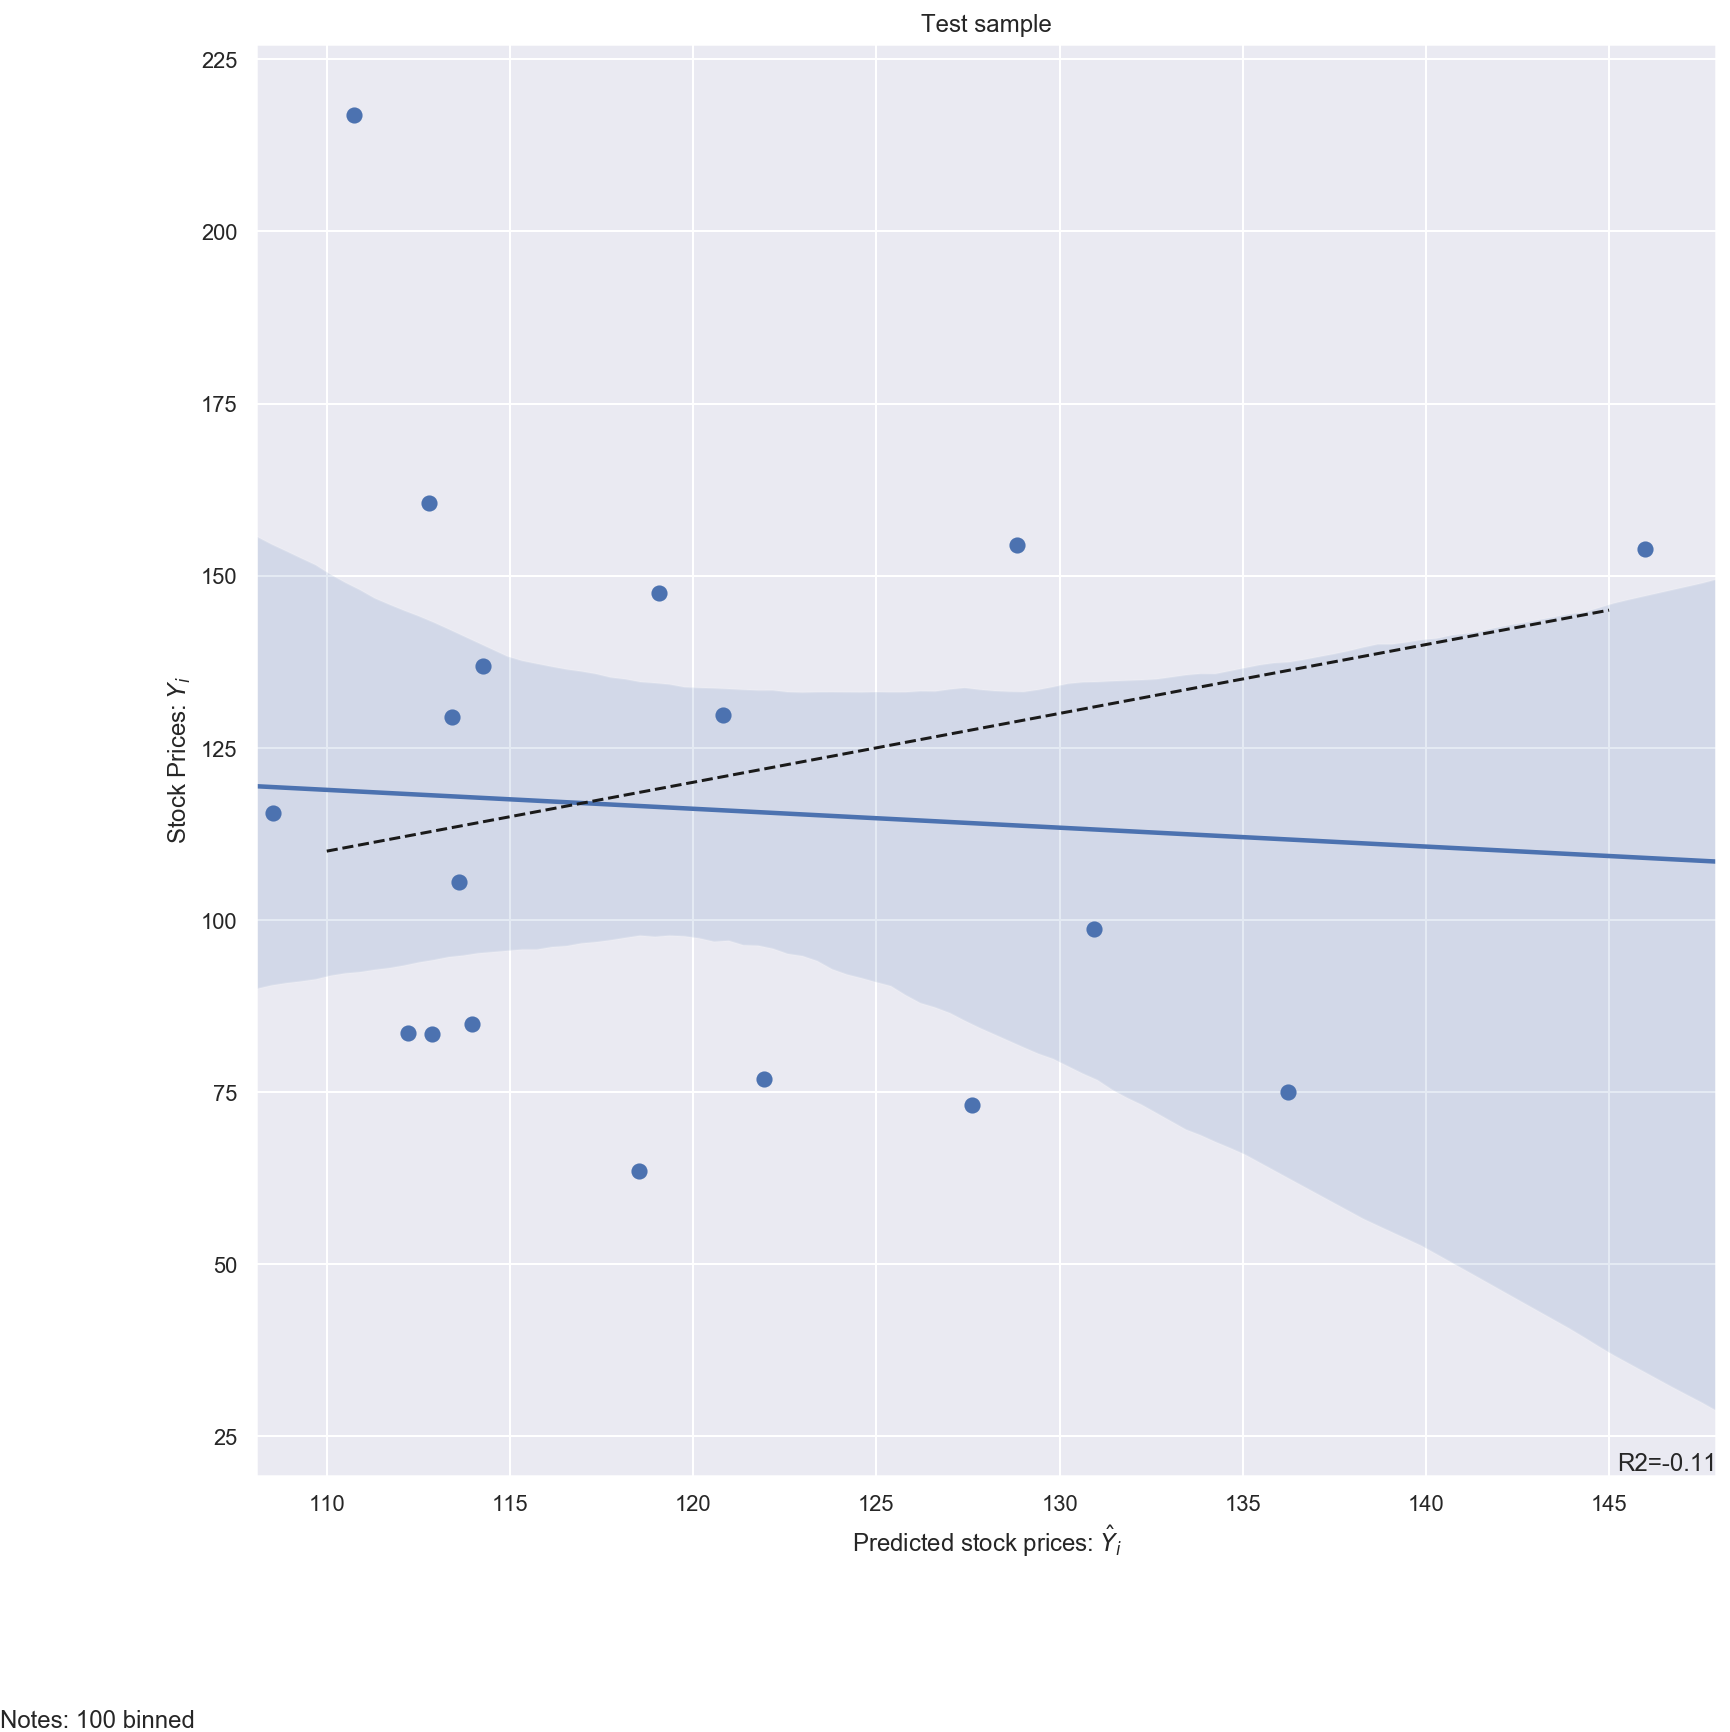

In [94]:
# randomized splitting
r2 = r2=round(r2_score(y_test, y_test_pred), 2)

# Regplot (code taken from the lecture Notebook W3)
g=sns.regplot(x= y_test_pred, y=y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([110, 145], [110, 145], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

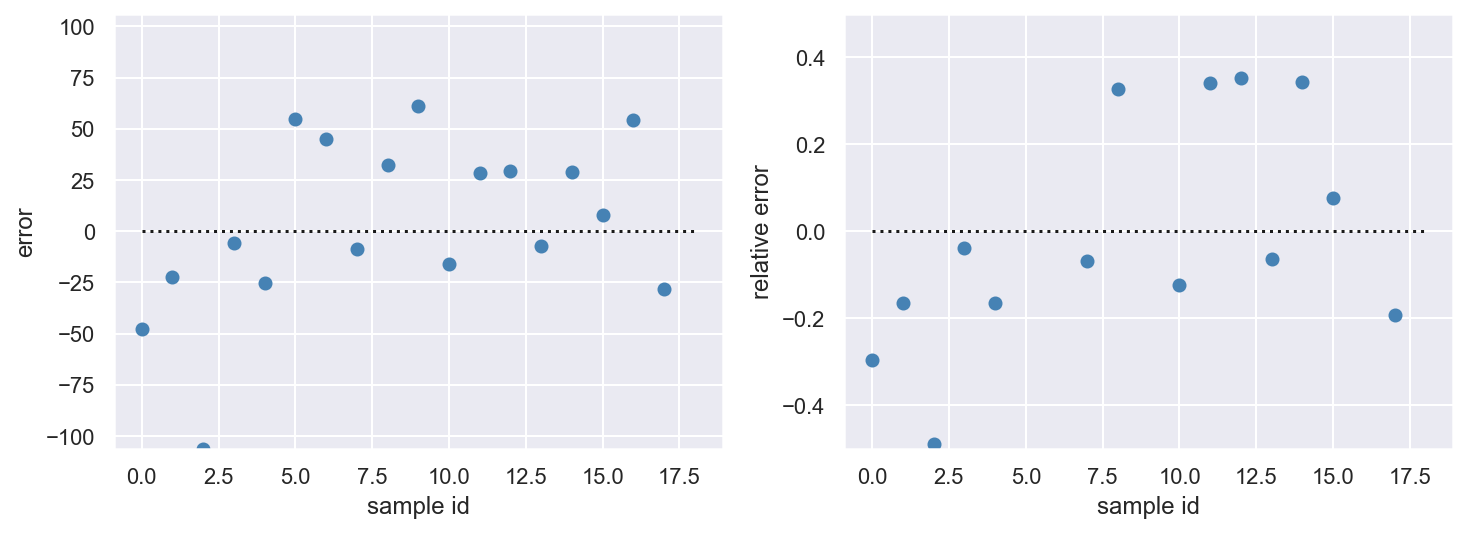

In [95]:
#Let us plot how good given and predicted values match on the training data set (code taken from the lecture Notebook W3)
plot_fit_quality(y_test, y_test_pred)

### Ridge Regression - Temporal Splitting

In [96]:
# temporal splitting
ridge_reg.fit(X_train2, y_train2)

y_train2_pred=ridge_reg.predict(X_train2)
y_test2_pred = ridge_reg.predict(X_test2)

train2_mse = mean_squared_error(y_train2, y_train2_pred)
train2_rmse = np.sqrt(train2_mse)

test2_mse = mean_squared_error(y_test2, y_test2_pred)
test2_rmse = np.sqrt(test2_mse)

print("train RMS: %s" % train2_rmse) 
print("test RMS: %s" % test2_rmse) 
print("train R2: %s" % round(r2_score(y_train2, y_train2_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test2, y_test2_pred), 2)) 

train RMS: 39.280296671311
test RMS: 30.616100096402825
train R2: 0.05
test R2: -0.77


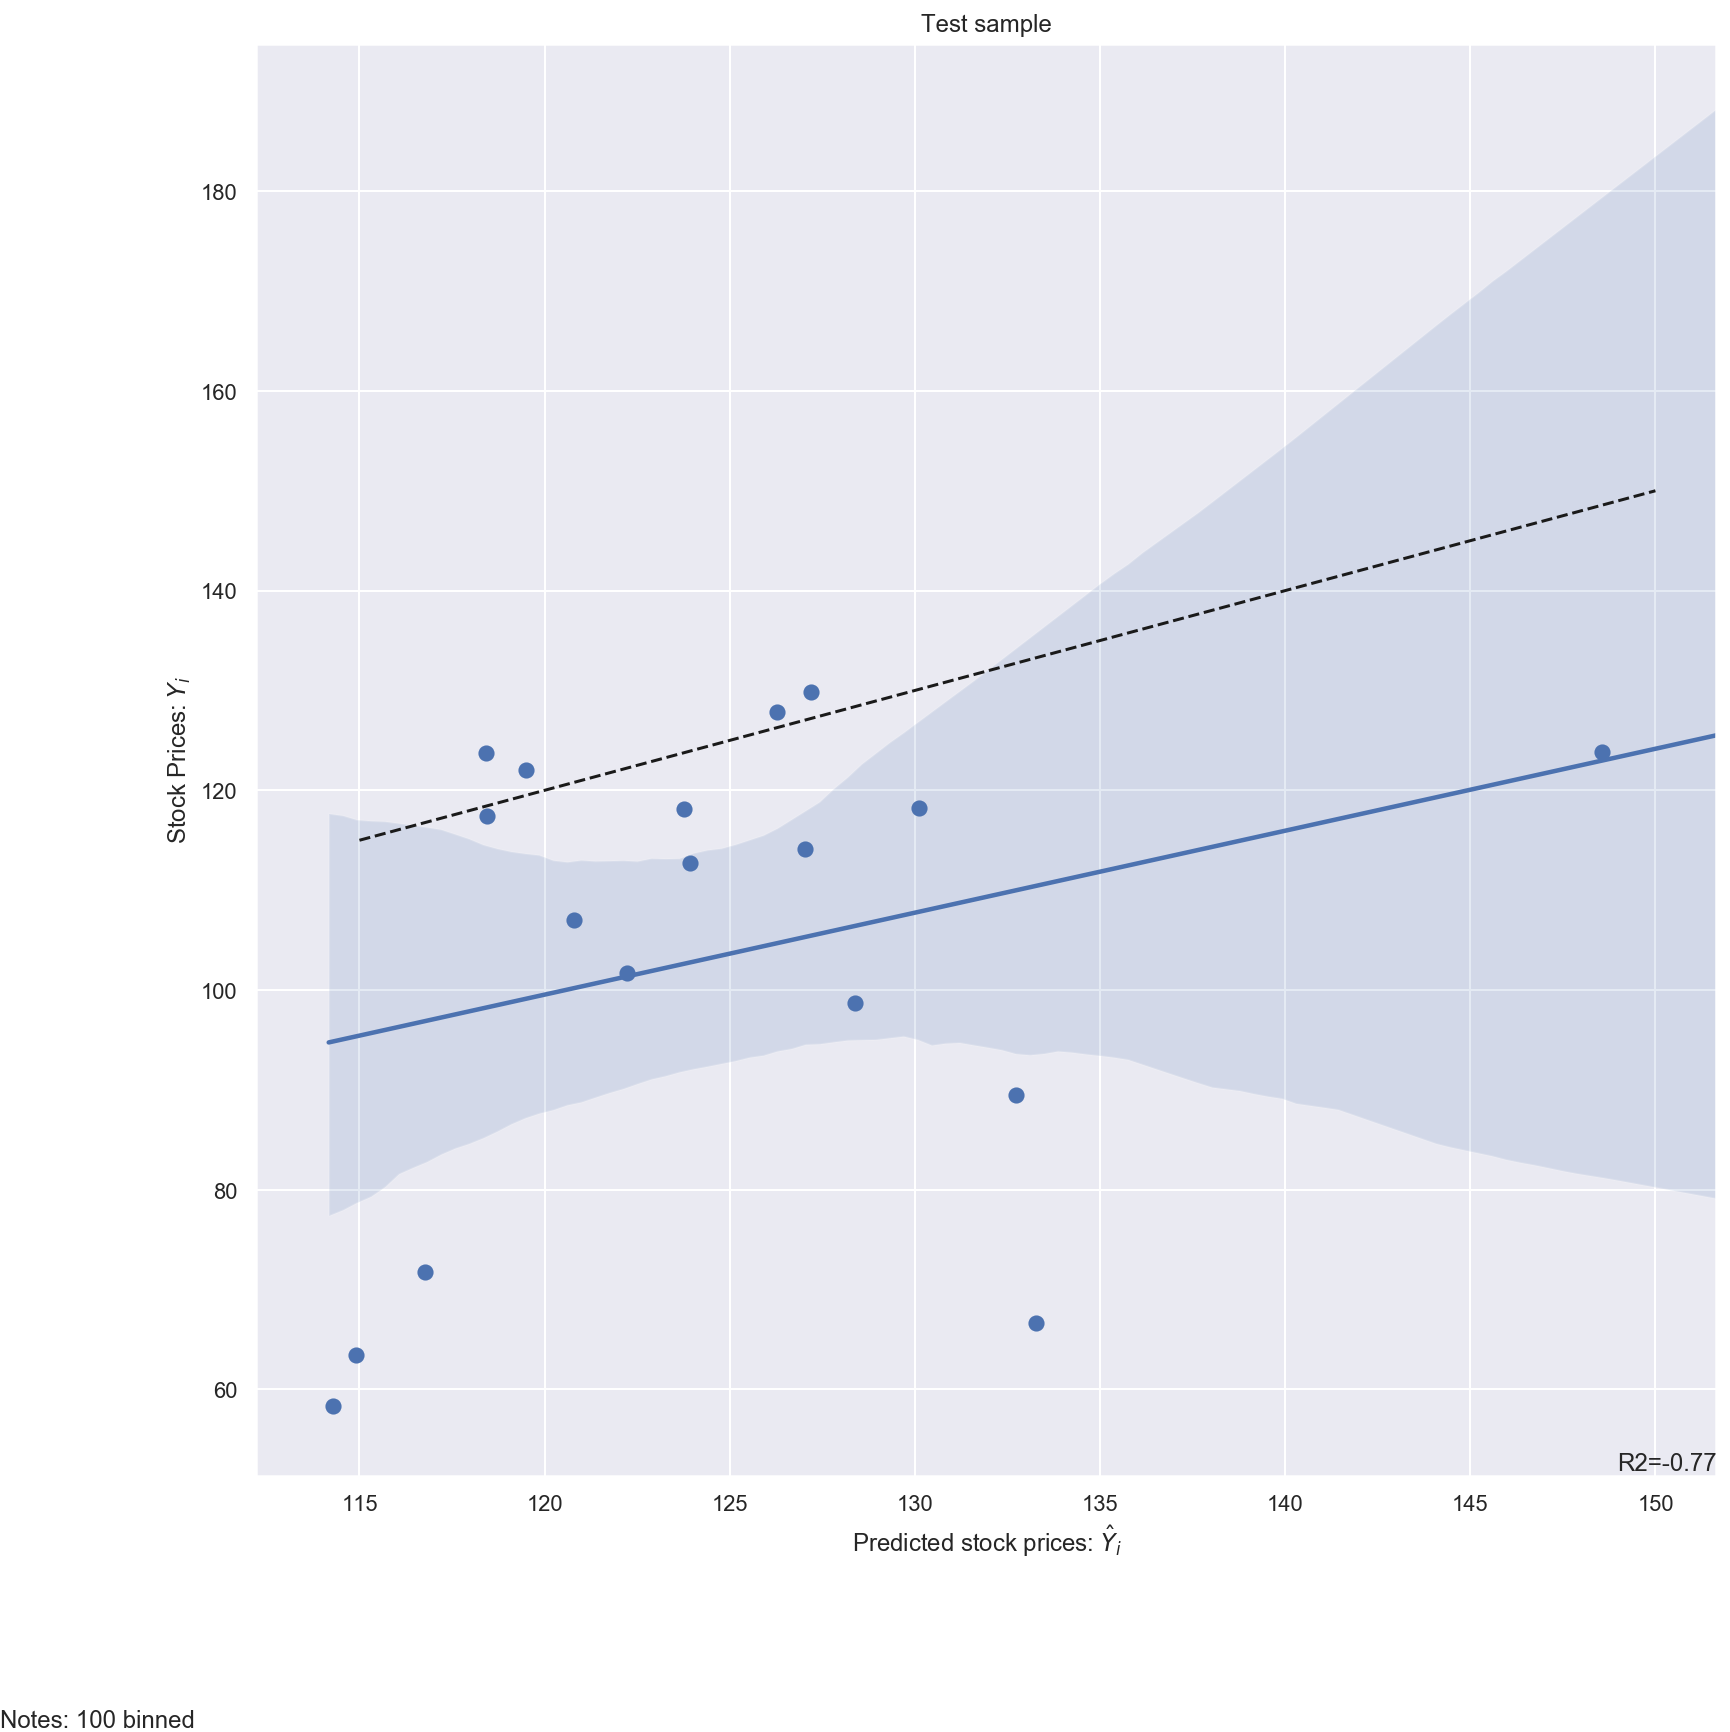

In [97]:
# temporal splitting
r2 = r2=round(r2_score(y_test2, y_test2_pred), 2)

# Regplot
g=sns.regplot(x= y_test2_pred, y=y_test2, x_bins= 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([115, 150], [115, 150], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

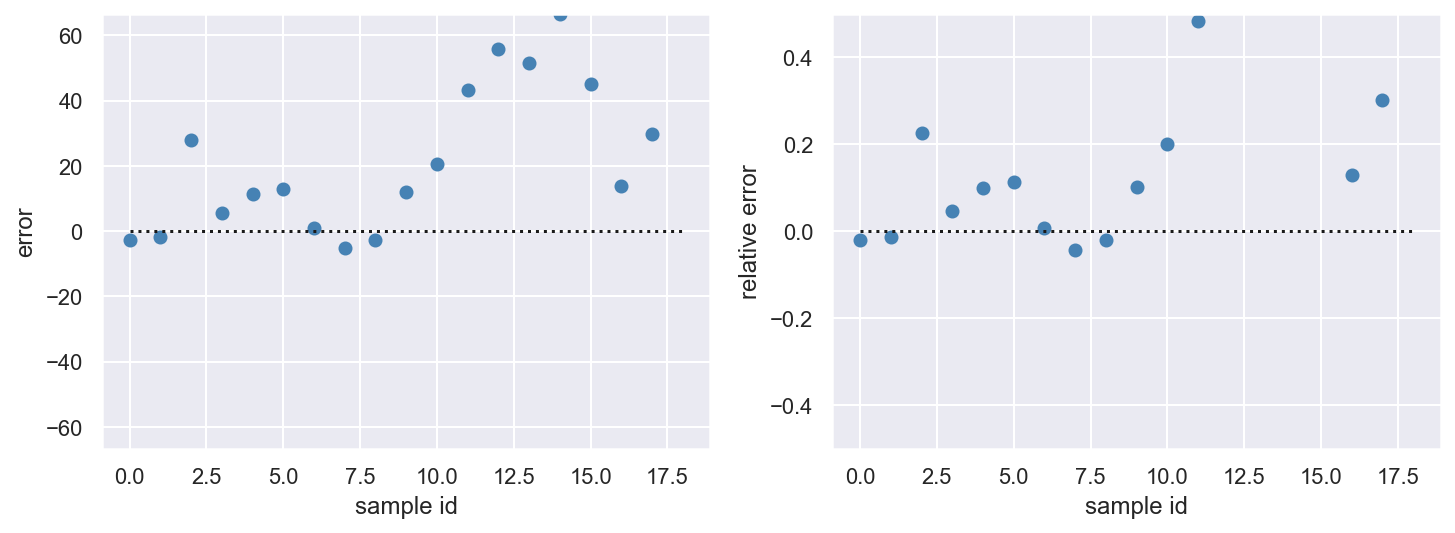

In [98]:
#Let us plot how good given and predicted values match on the training data set (code taken from the lecture Notebook W3)
plot_fit_quality(y_test2, y_test2_pred)

The ridge regression yields somewhat better results, but still negative values for the test R2.

## Polynomial Regression

In [99]:
from sklearn.preprocessing import PolynomialFeatures
poly_features=PolynomialFeatures(degree=2)

### Polynomial Regression - Randomized Splitting

In [100]:
# randomized splitting
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)

y_train_pred = lin_reg.predict(X_train_poly)
y_test_pred = lin_reg.predict(X_test_poly)

train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(y_test,y_test_pred)
test_rmse = np.sqrt(test_mse)

print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2))

train RMS: 32.927583054704535
test RMS: 38.834514978188764
train R2: 0.24
test R2: 0.04


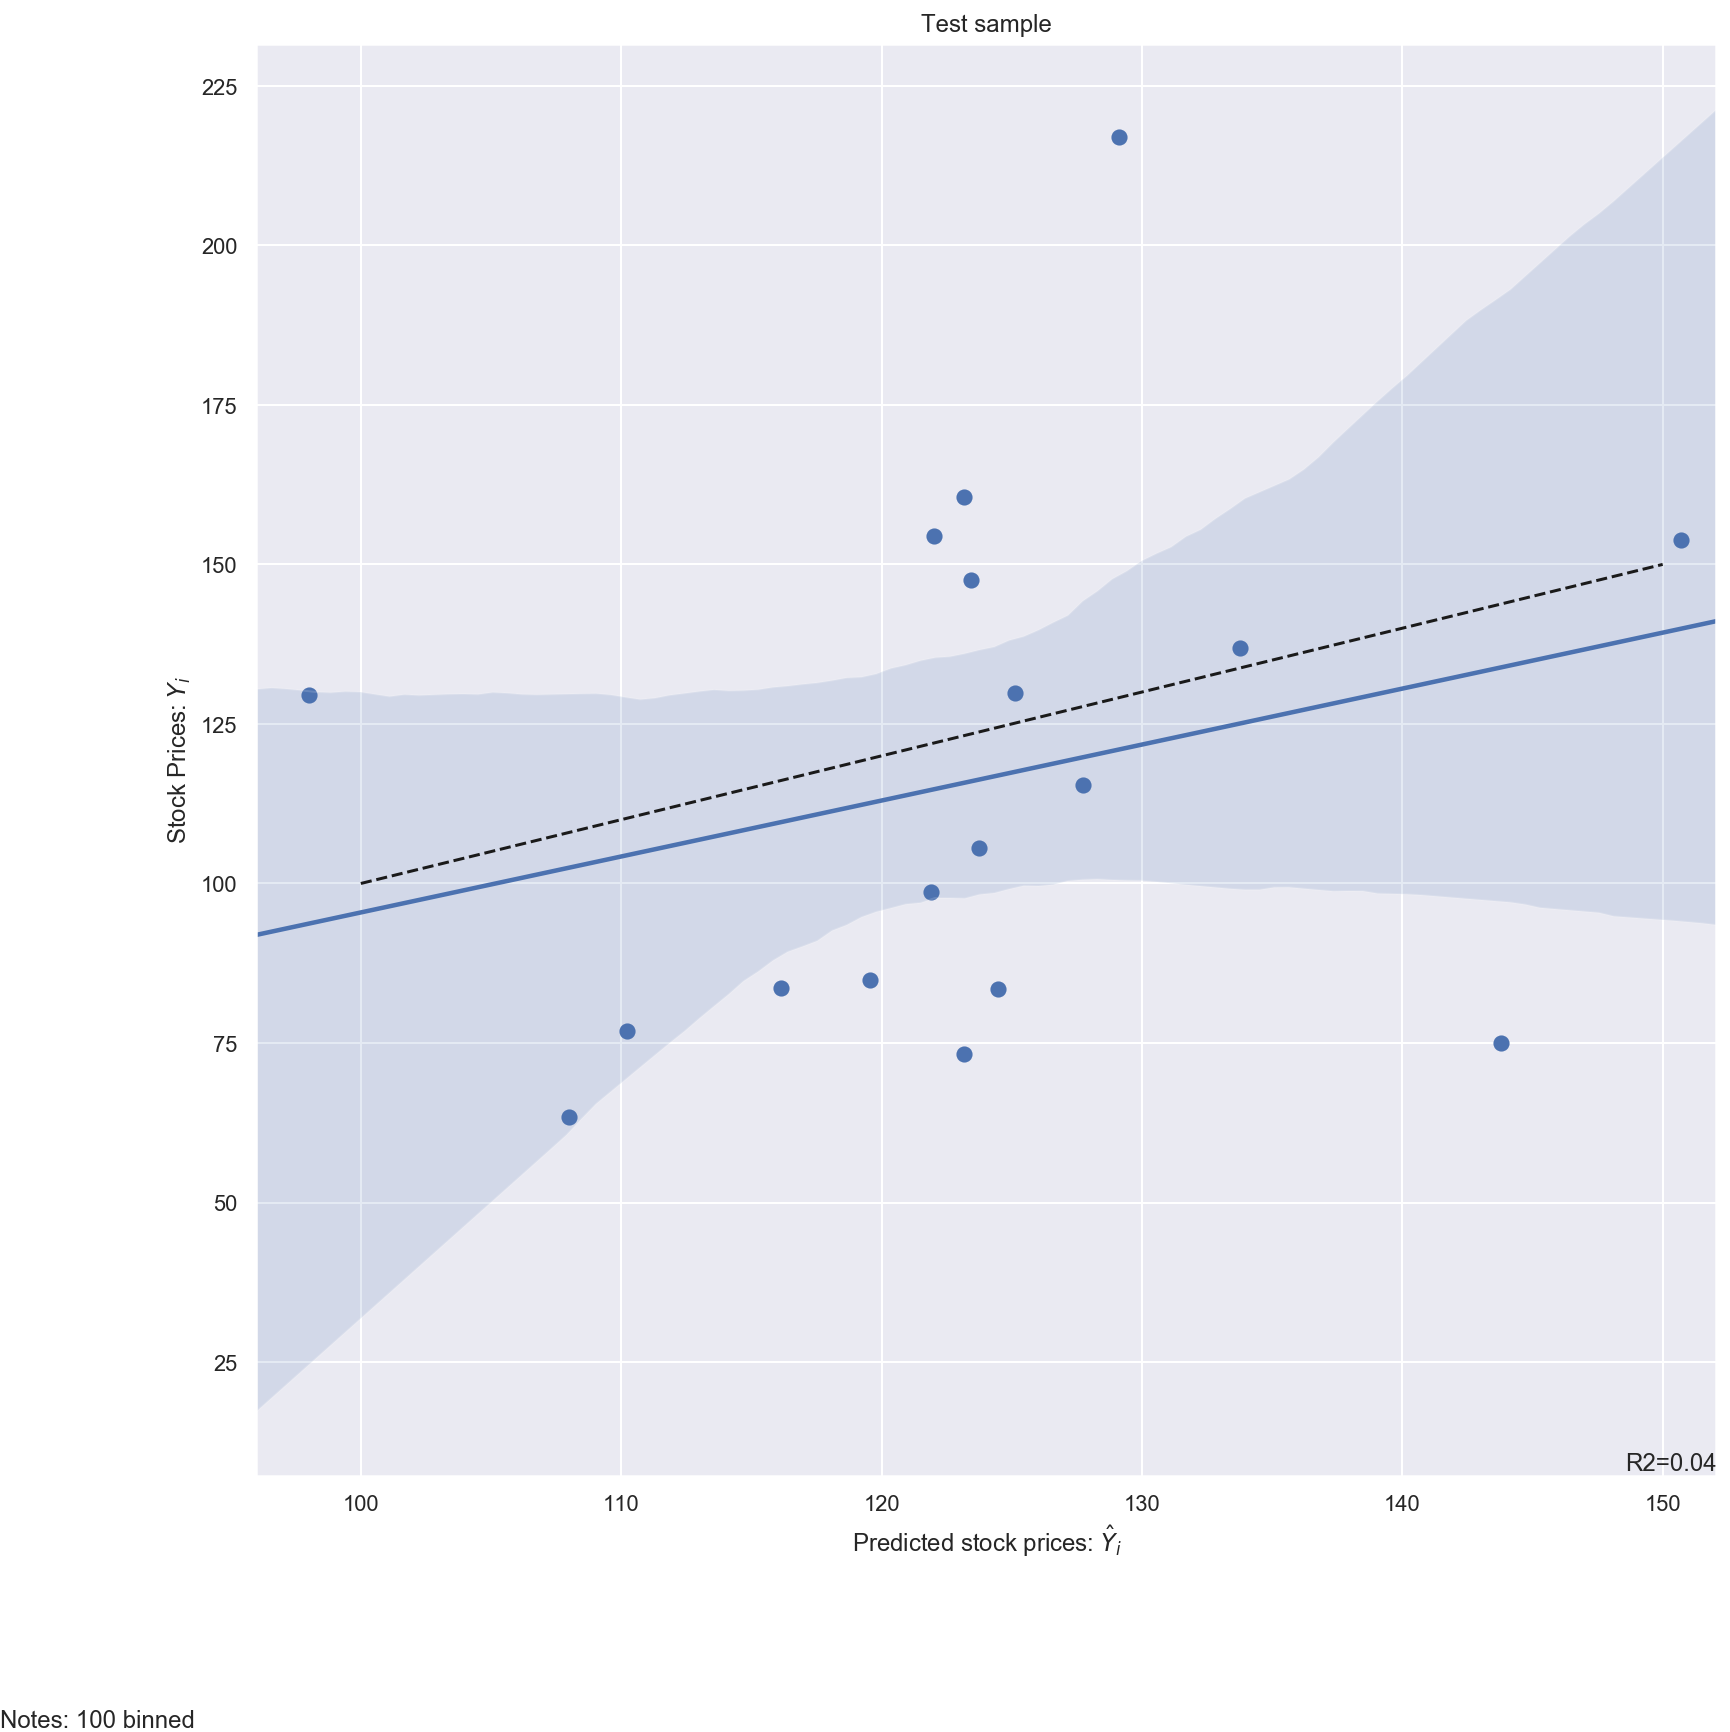

In [101]:
# randomized splitting
r2 = r2=round(r2_score(y_test, y_test_pred), 2)

# Regplot
g=sns.regplot(x= y_test_pred, y=y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([100, 150], [100, 150], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

This looks already way better. After all, the regression explains 24% of the variation in the X variable (train data).

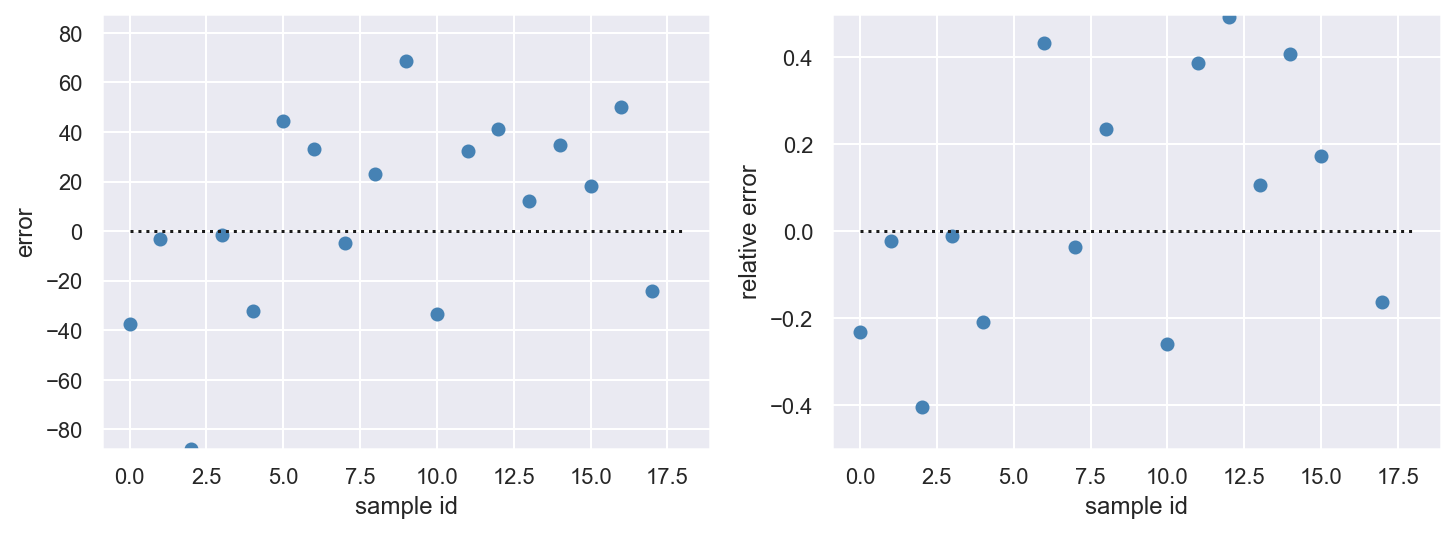

In [102]:
#Let us plot how good given and predicted values match on the training data set (code taken from the lecture Notebook W3)
plot_fit_quality(y_test, y_test_pred)

### Polynomial Regression - Temporal Splitting

In [103]:
# temporal splitting
X_train2_poly = poly_features.fit_transform(X_train2)
X_test2_poly = poly_features.fit_transform(X_test2)

lin_reg = LinearRegression()
lin_reg.fit(X_train2_poly, y_train2)

y_train2_pred = lin_reg.predict(X_train2_poly)
y_test2_pred = lin_reg.predict(X_test2_poly)

train2_mse = mean_squared_error(y_train2, y_train2_pred)
train2_rmse = np.sqrt(train2_mse)

test2_mse = mean_squared_error(y_test2,y_test2_pred)
test2_rmse = np.sqrt(test2_mse)

print("train RMS: %s" % train2_rmse) 
print("test RMS: %s" % test2_rmse) 
print("train R2: %s" % round(r2_score(y_train2, y_train2_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test2, y_test2_pred), 2))

train RMS: 35.398437596245174
test RMS: 33.645776725726606
train R2: 0.23
test R2: -1.14


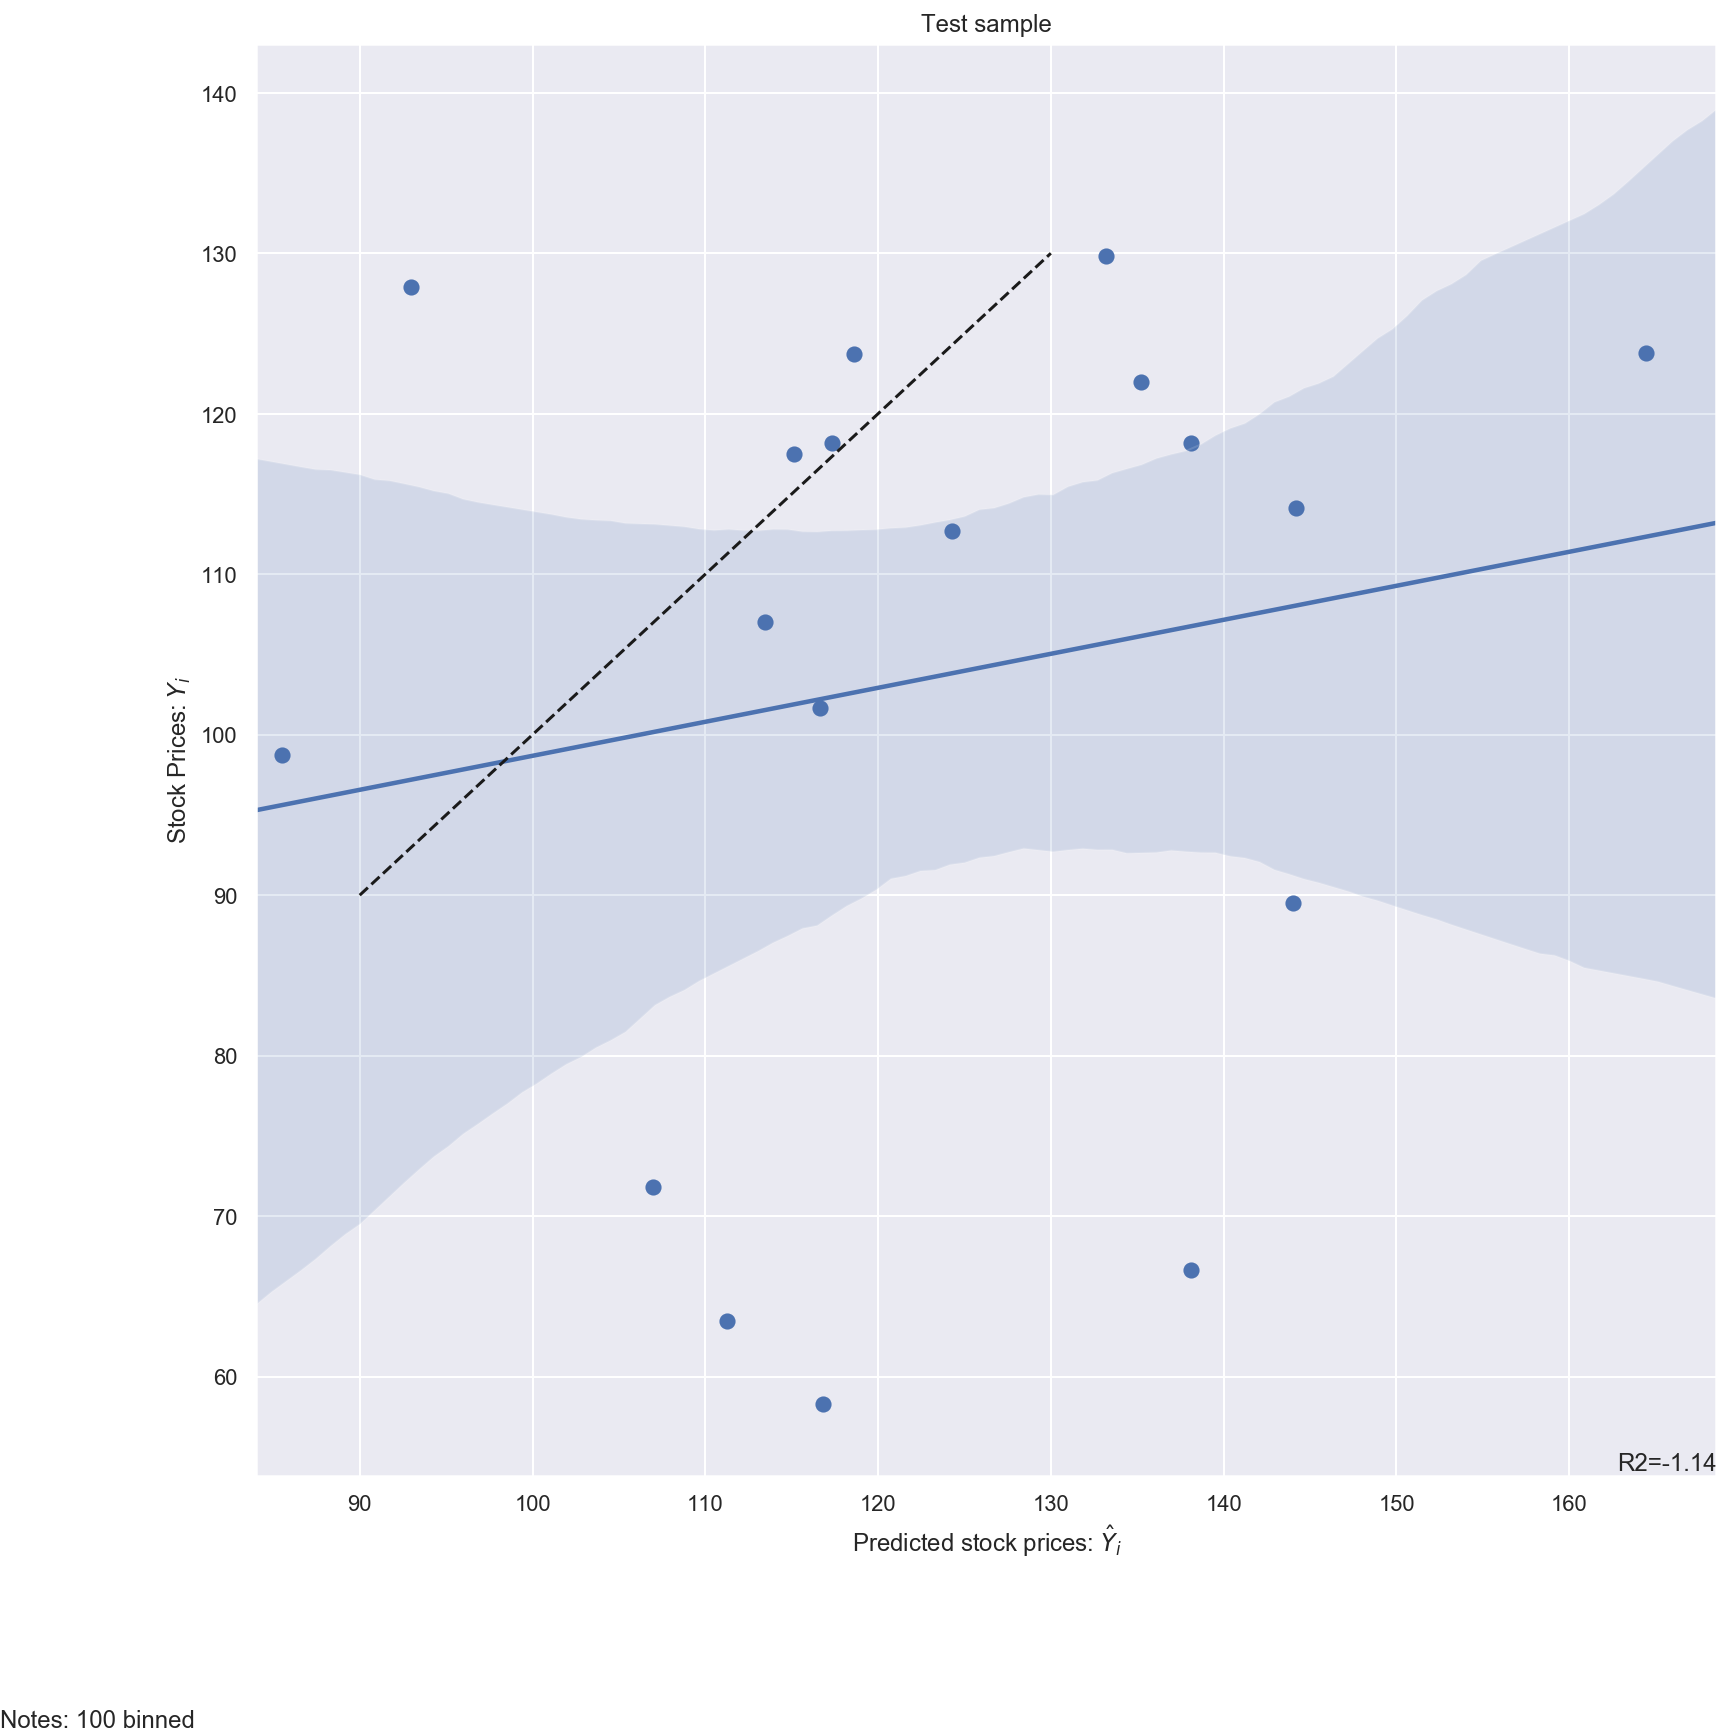

In [104]:
# temporal splitting
r2 = r2=round(r2_score(y_test2, y_test2_pred), 2)

# Regplot
g=sns.regplot(x= y_test2_pred, y=y_test2, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([90, 130], [90, 130], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

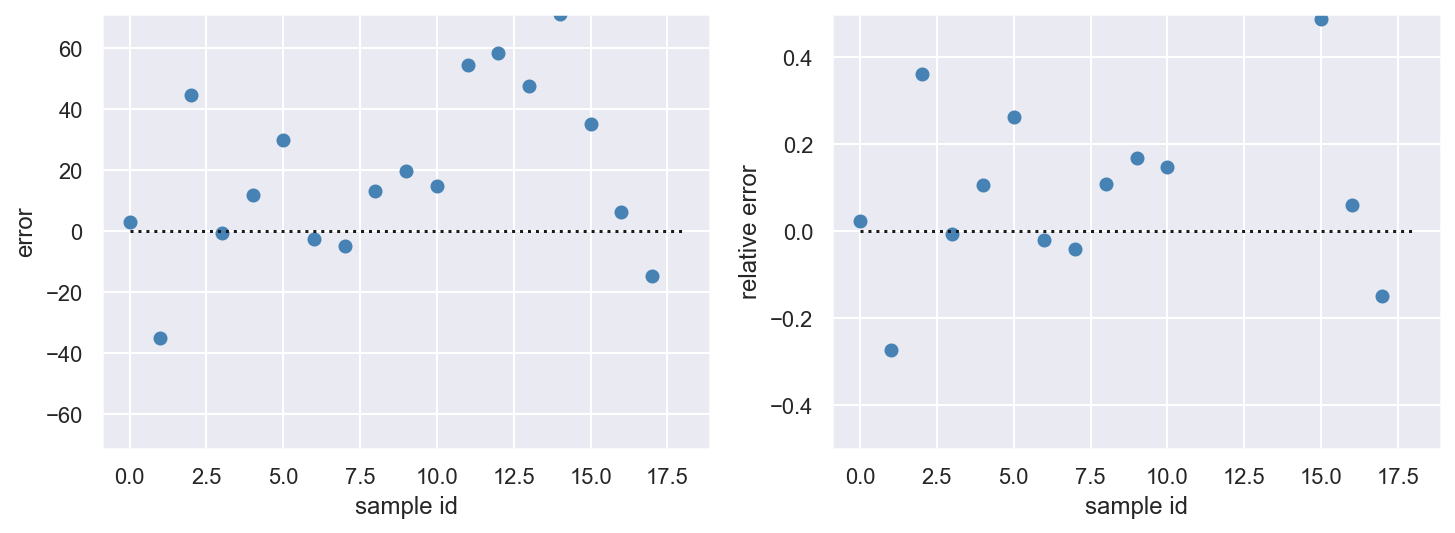

In [105]:
#Let us plot how good given and predicted values match on the training data set (code taken from the lecture Notebook W3)
plot_fit_quality(y_test2, y_test2_pred)

The temporal split didn't help here. So far, the polynomial regression with randomized split works out best. Let's try the two other models from the lecture:

## Lasso regression

In [106]:
from sklearn.linear_model import Lasso
lasso_reg=Lasso(alpha=1) 

### Lasso Regression - Randomized Splitting

In [107]:
# randomized splitting
lasso_reg.fit(X_train, y_train)

y_train_pred = lasso_reg.predict(X_train) 
y_test_pred = lasso_reg.predict(X_test)        

train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2))

train RMS: 36.625509461410104
test RMS: 41.16297369826597
train R2: 0.06
test R2: -0.08


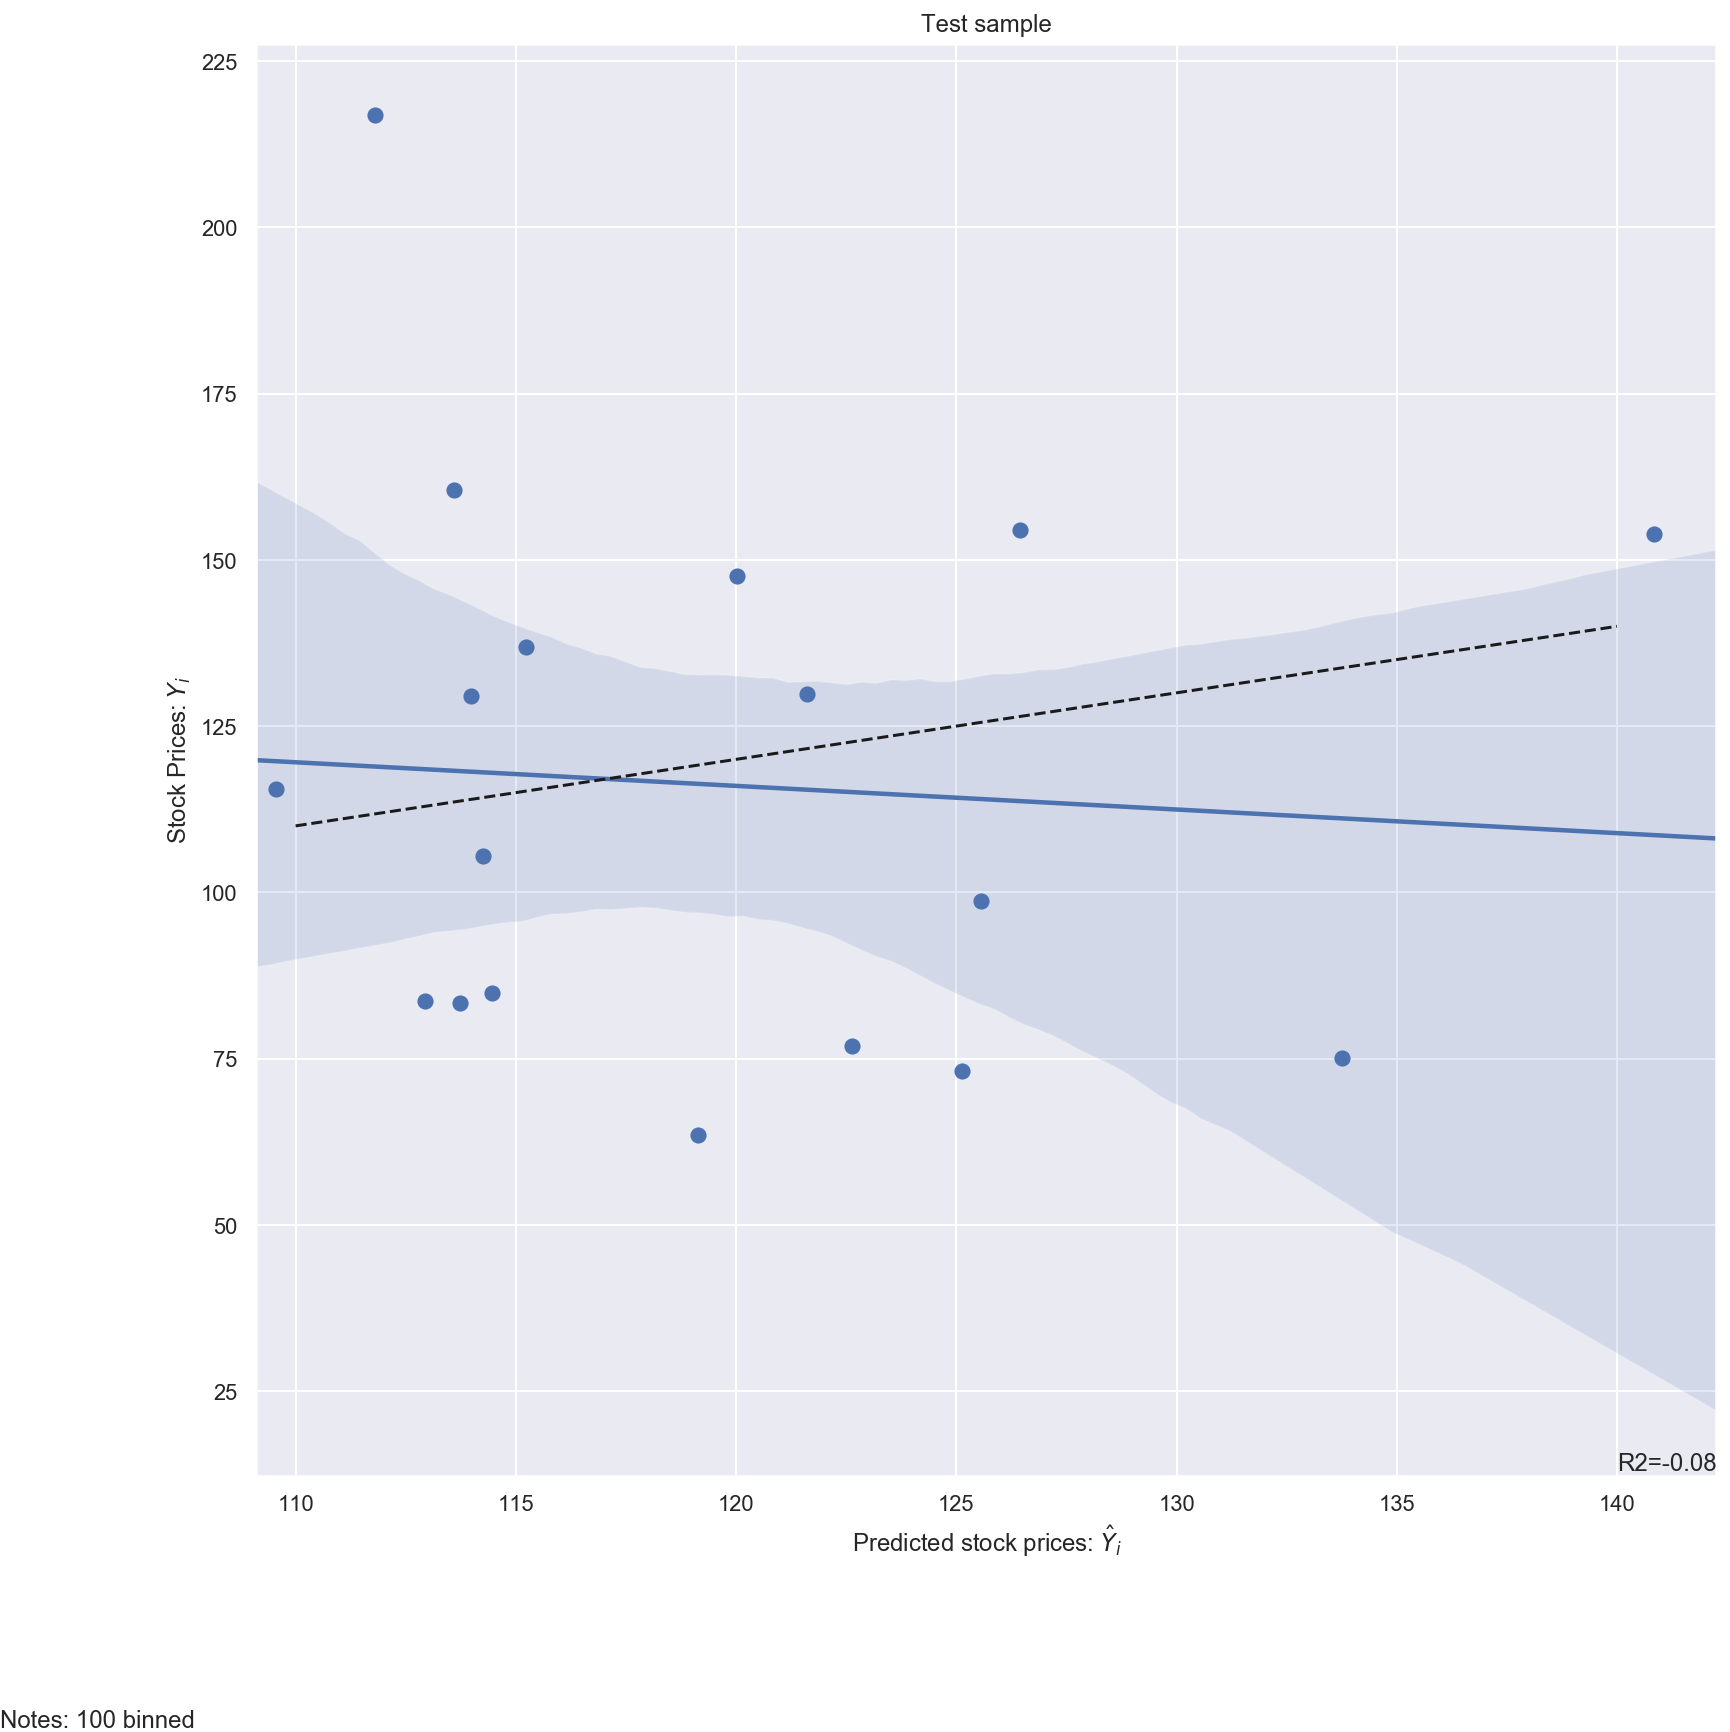

In [108]:
# randomized splitting
r2 = r2=round(r2_score(y_test, y_test_pred), 2)

# Regplot (code taken from the lecture Notebook W3)
g=sns.regplot(x= y_test_pred, y=y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([110, 140], [110, 140], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

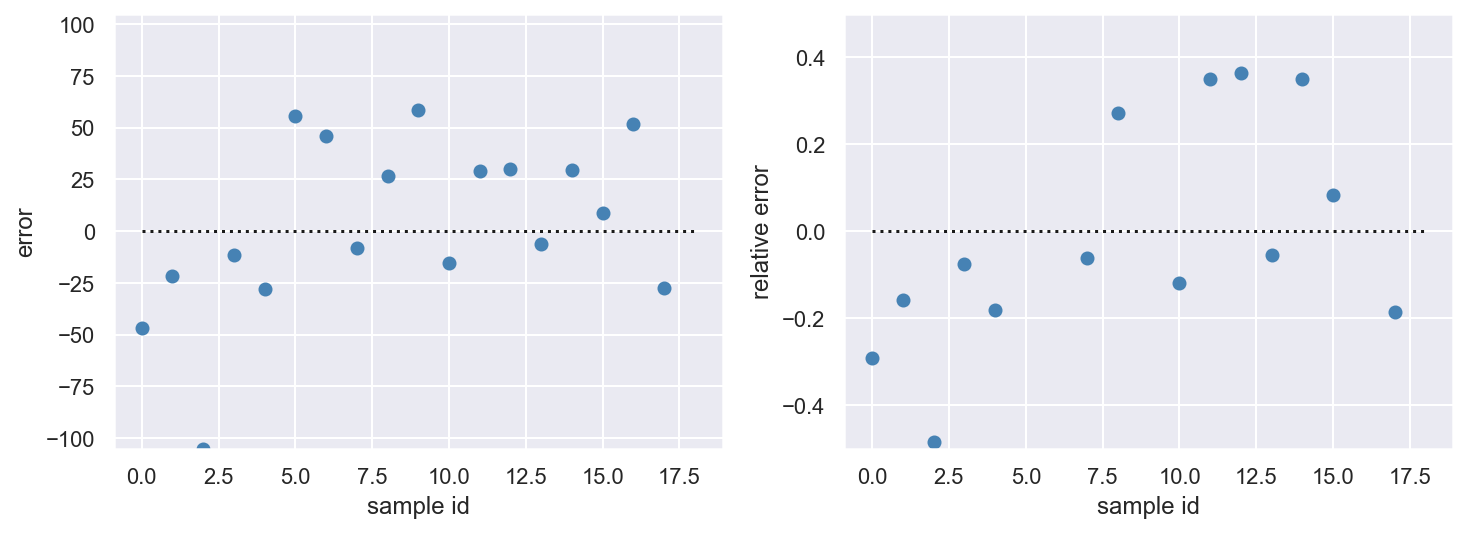

In [109]:
#Let us plot how good given and predicted values match on the training data set (code taken from the lecture Notebook W3)
plot_fit_quality(y_test, y_test_pred)

### Lasso Regression - Temporal Splitting

In [110]:
# temporal splitting
lasso_reg.fit(X_train2, y_train2)

y_train_pred = lasso_reg.predict(X_train2) 
y_test_pred = lasso_reg.predict(X_test2)        

train2_mse = mean_squared_error(y_train2, y_train2_pred)
train2_rmse = np.sqrt(train2_mse)

test2_mse = mean_squared_error(y_test2, y_test2_pred)
test2_rmse = np.sqrt(test2_mse)

print("train RMS: %s" % train2_rmse) 
print("test RMS: %s" % test2_rmse) 
print("train R2: %s" % round(r2_score(y_train2, y_train2_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test2, y_test2_pred), 2))

train RMS: 35.398437596245174
test RMS: 33.645776725726606
train R2: 0.23
test R2: -1.14


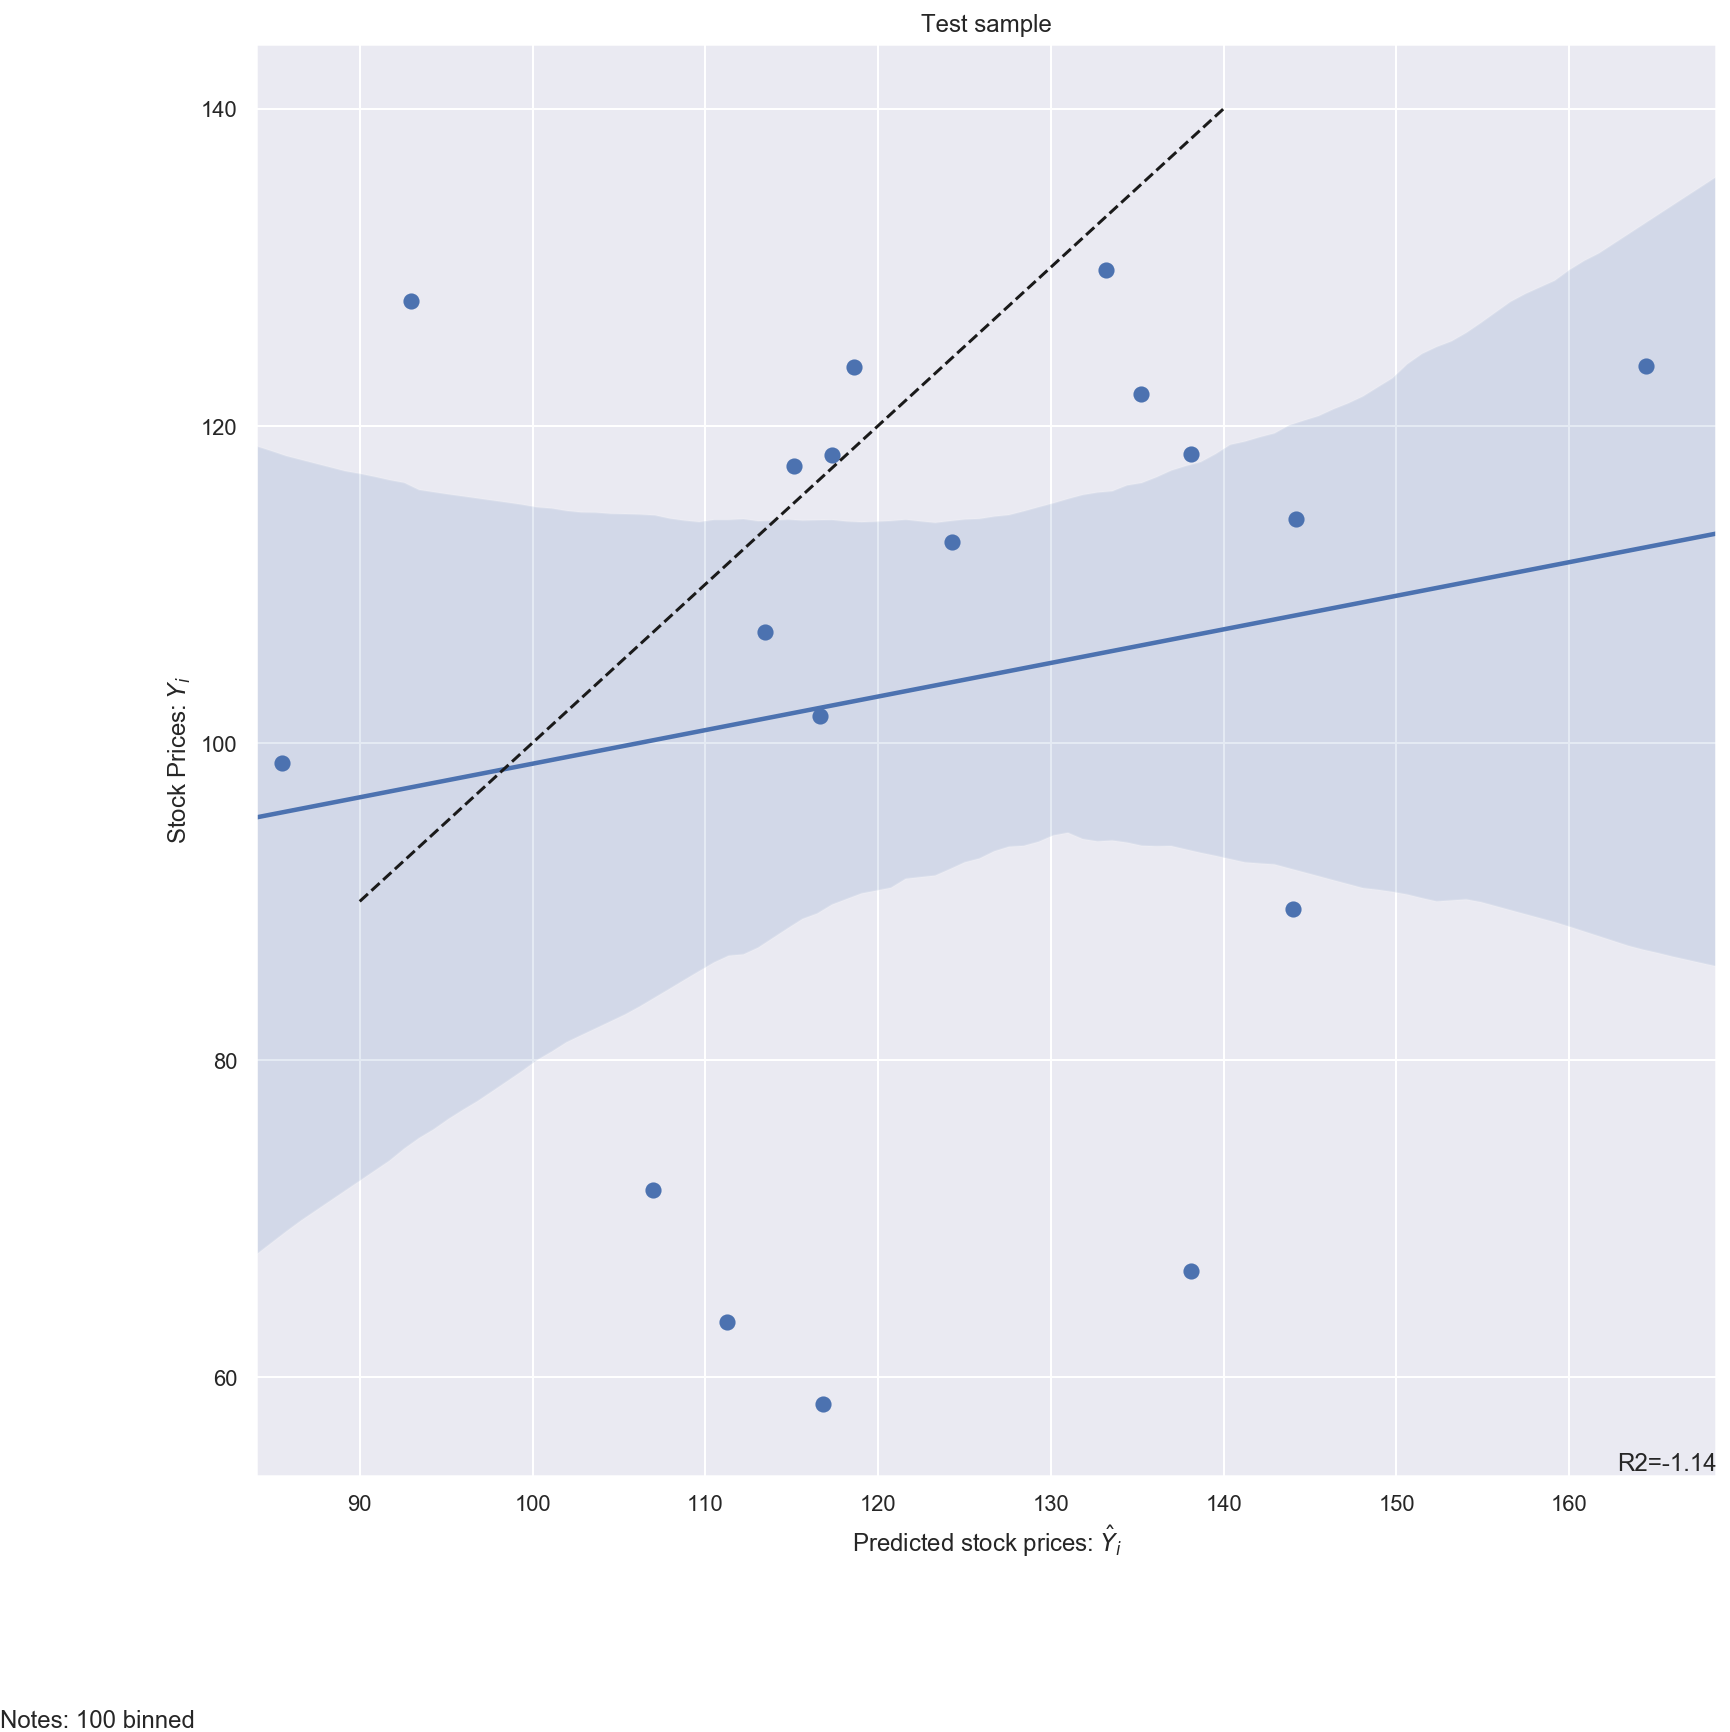

In [111]:
# temporal splitting
r2 = r2=round(r2_score(y_test2, y_test2_pred), 2)

# Regplot (code taken from the lecture Notebook W3)
g=sns.regplot(x= y_test2_pred, y=y_test2, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([90, 140], [90, 140], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

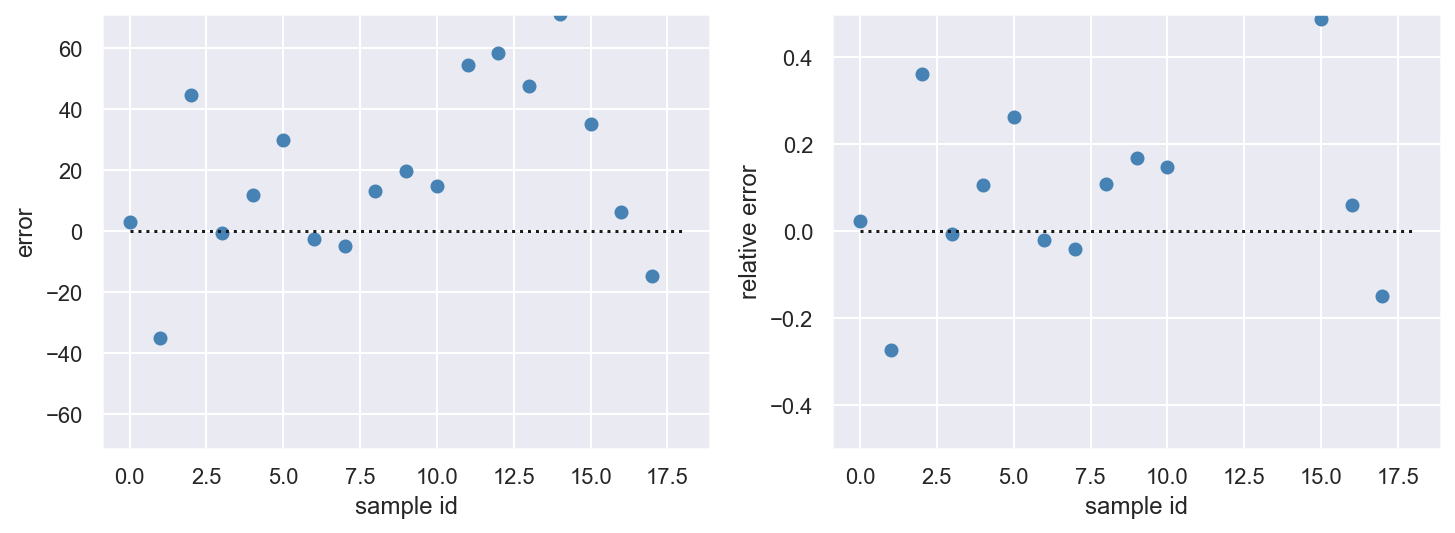

In [112]:
#Let us plot how good given and predicted values match on the training data set (code taken from the lecture Notebook W3)
plot_fit_quality(y_test2, y_test2_pred)

## Elestic net

In [113]:
from sklearn.linear_model import ElasticNet
elanet_reg=ElasticNet(random_state=0)

### Elastic net - Randomized Splitting

In [114]:
# randomized splitting
elanet_reg.fit(X_train_scaled, y_train)

y_train_pred = elanet_reg.predict(X_train_scaled)
y_test_pred = elanet_reg.predict(X_test_scaled)

train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2))

train RMS: 36.82258278582142
test RMS: 40.60175189127773
train R2: 0.05
test R2: -0.05


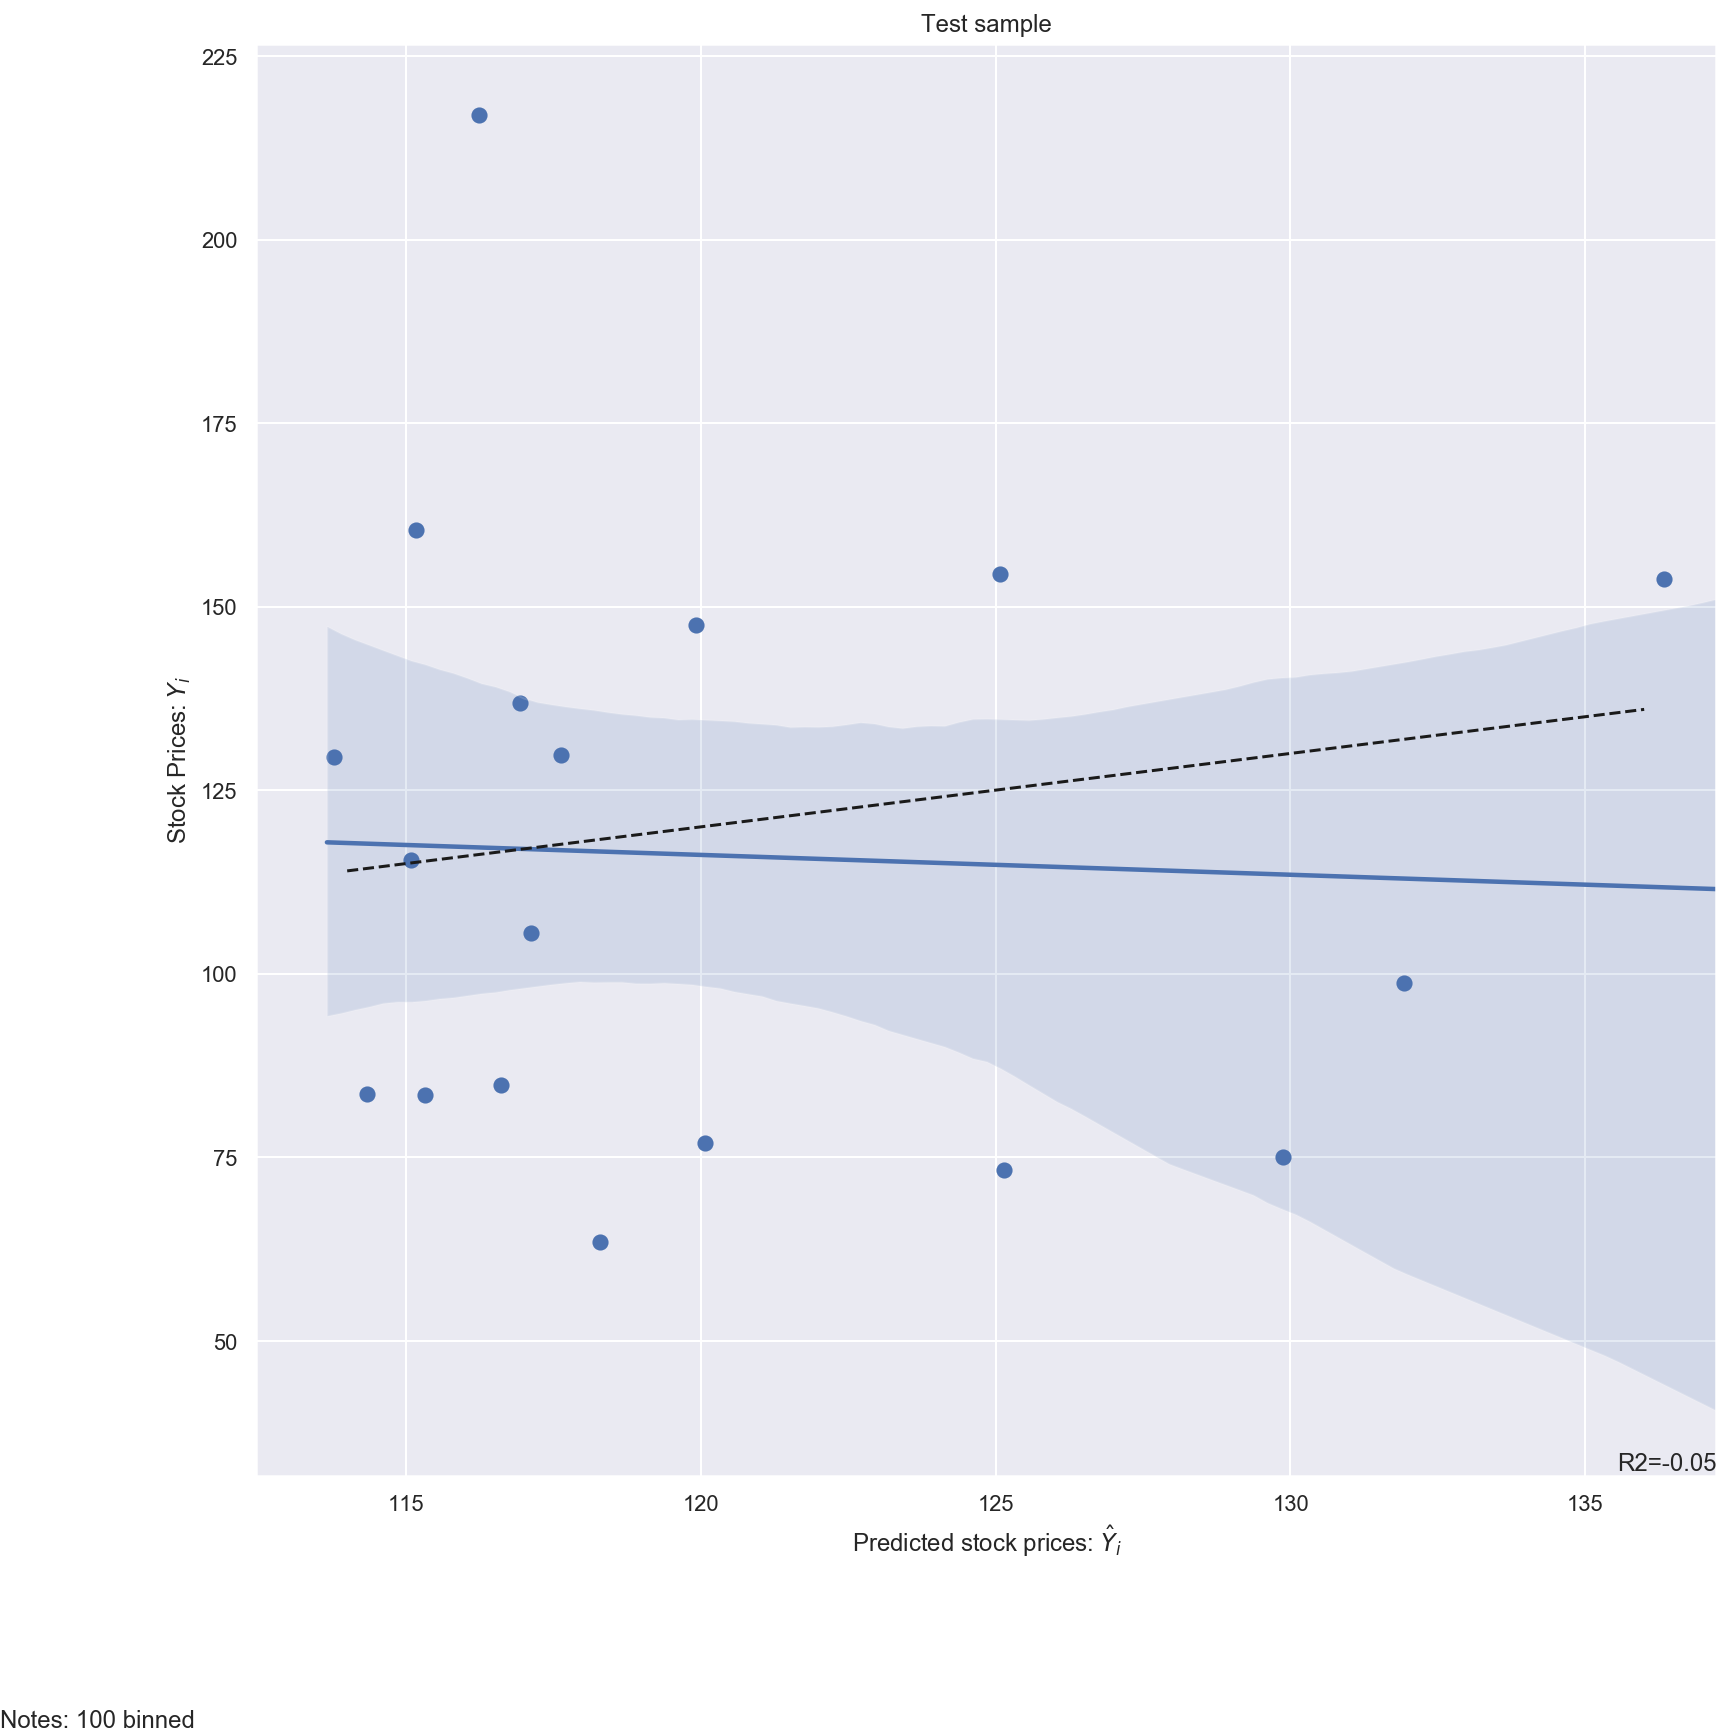

In [115]:
# randomized splitting
r2 = r2=round(r2_score(y_test, y_test_pred), 2)

# Regplot (code taken from the lecture Notebook W3)
g=sns.regplot(x= y_test_pred, y=y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([114, 136], [114, 136], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

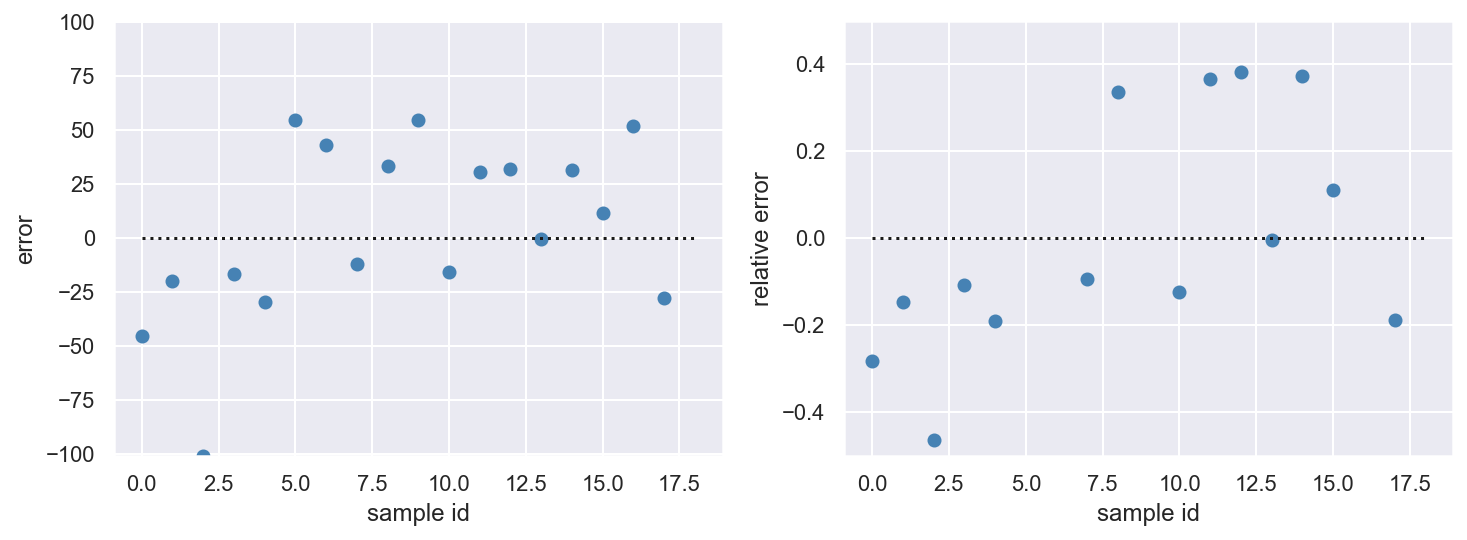

In [116]:
#Let us plot how good given and predicted values match on the training data set (code taken from the lecture Notebook W3)
plot_fit_quality(y_test, y_test_pred)

### Elastic net - Temporal Splitting

In [117]:
# temporal splitting
elanet_reg.fit(X_train2_scaled, y_train2)

y_train2_pred = elanet_reg.predict(X_train2_scaled)
y_test2_pred = elanet_reg.predict(X_test2_scaled)

train2_mse = mean_squared_error(y_train2, y_train2_pred)
train2_rmse = np.sqrt(train2_mse)

test2_mse = mean_squared_error(y_test2, y_test2_pred)
test2_rmse = np.sqrt(test2_mse)

print("train RMS: %s" % train2_rmse) 
print("test RMS: %s" % test2_rmse) 
print("train R2: %s" % round(r2_score(y_train2, y_train2_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test2, y_test2_pred), 2))

train RMS: 39.361029906951124
test RMS: 30.345251631976826
train R2: 0.04
test R2: -0.74


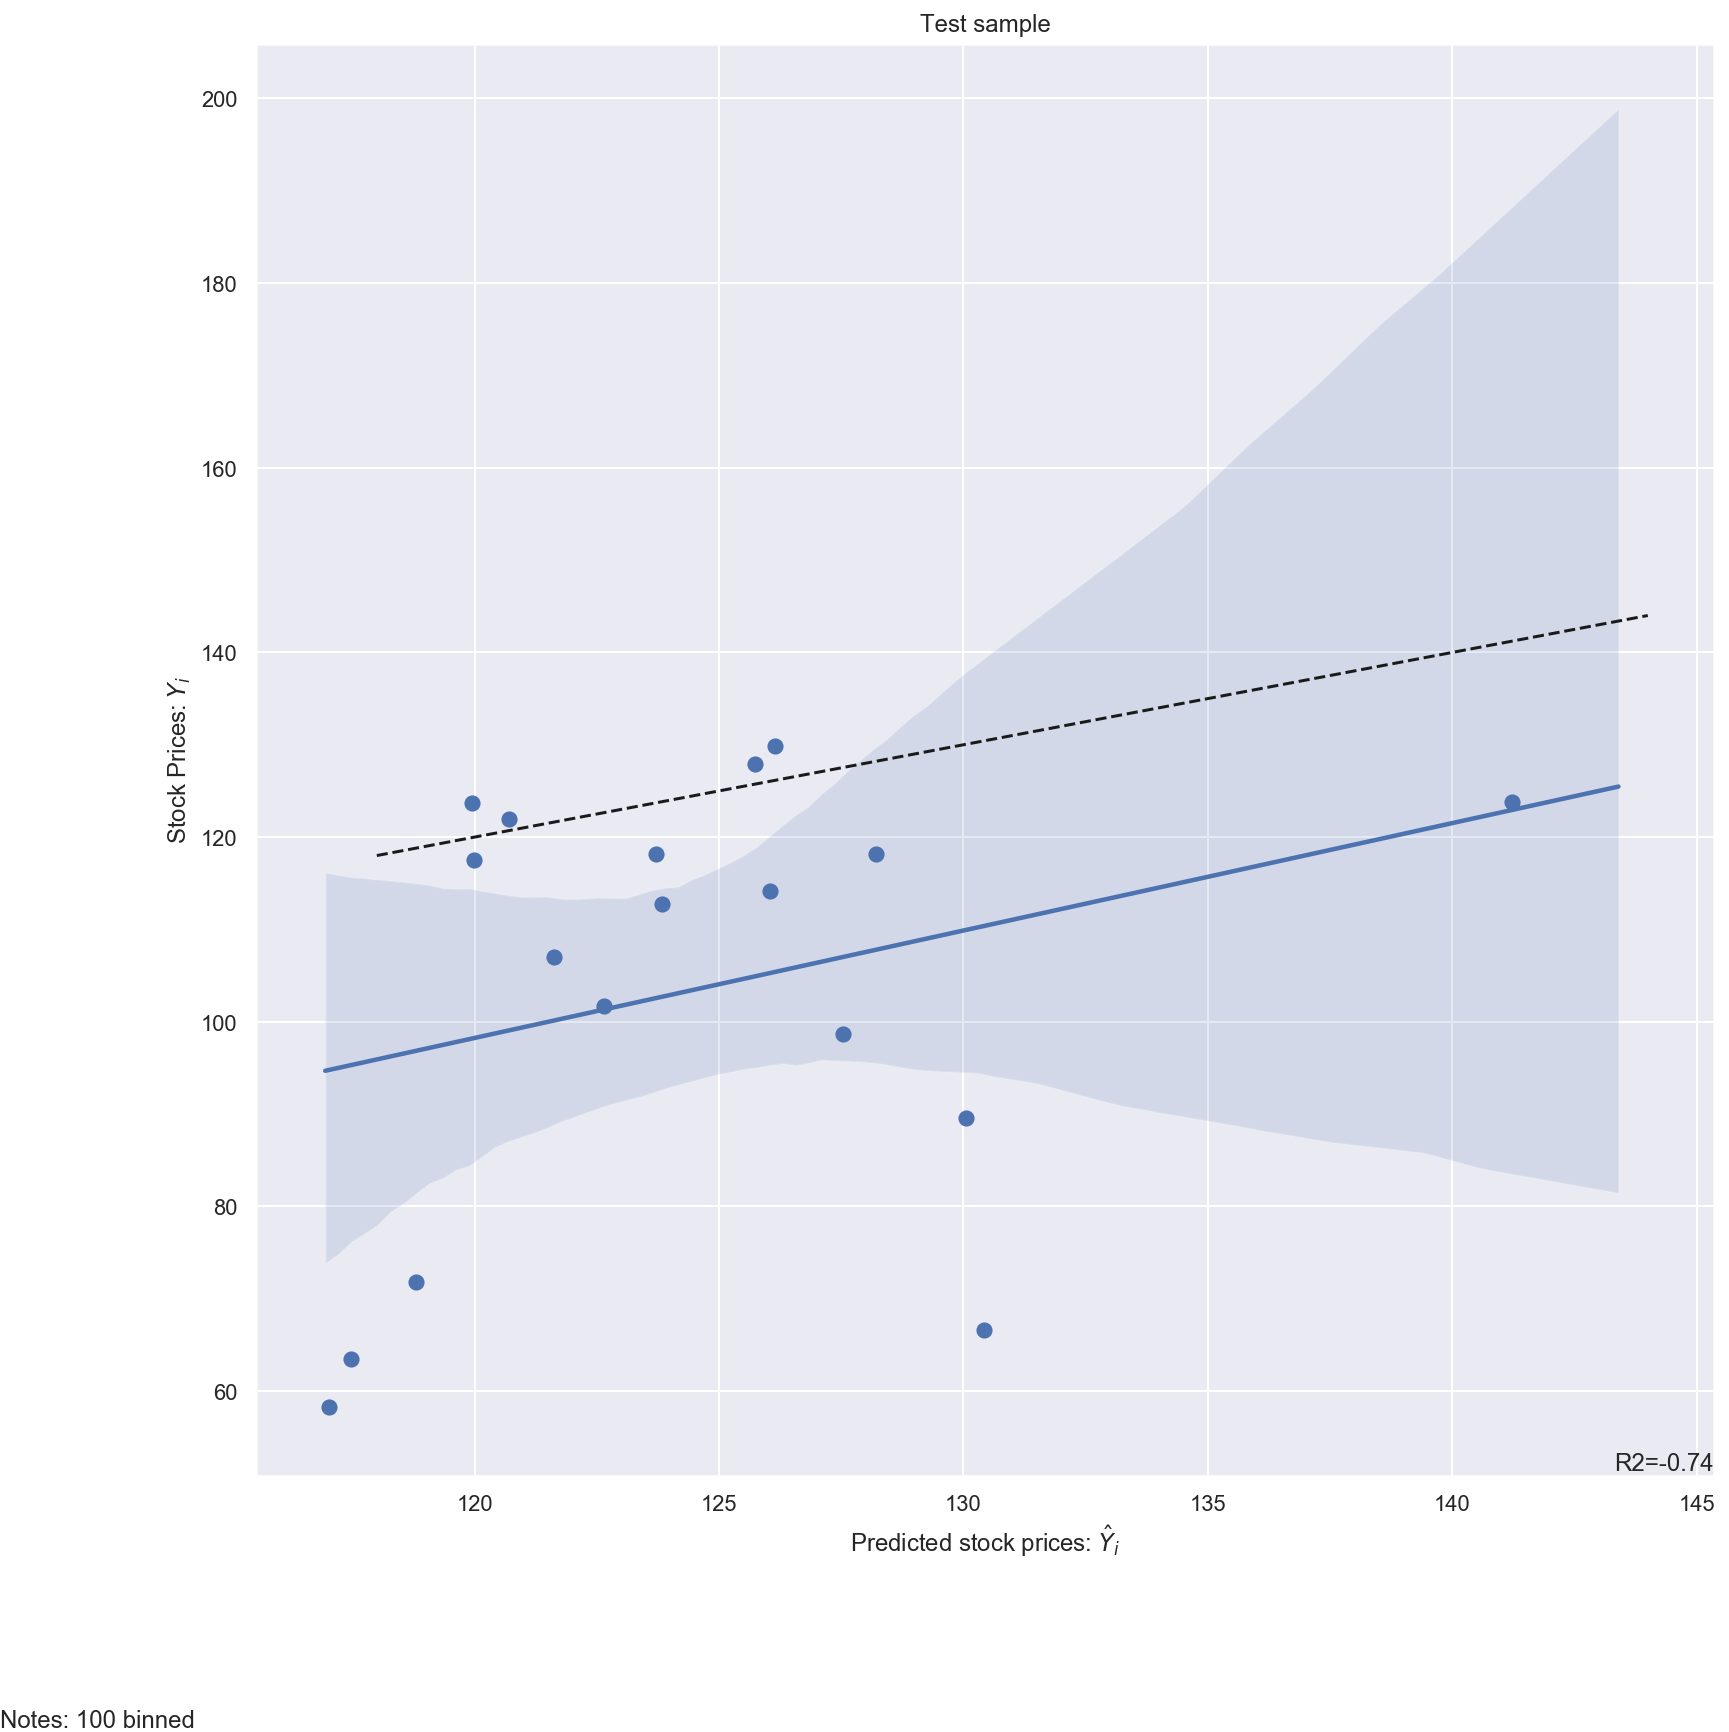

In [118]:
# temporal splitting
r2 = r2=round(r2_score(y_test2, y_test2_pred), 2)

# Regplot (code taken from the lecture Notebook W3)
g=sns.regplot(x= y_test2_pred, y=y_test2, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([118, 144], [118, 144], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

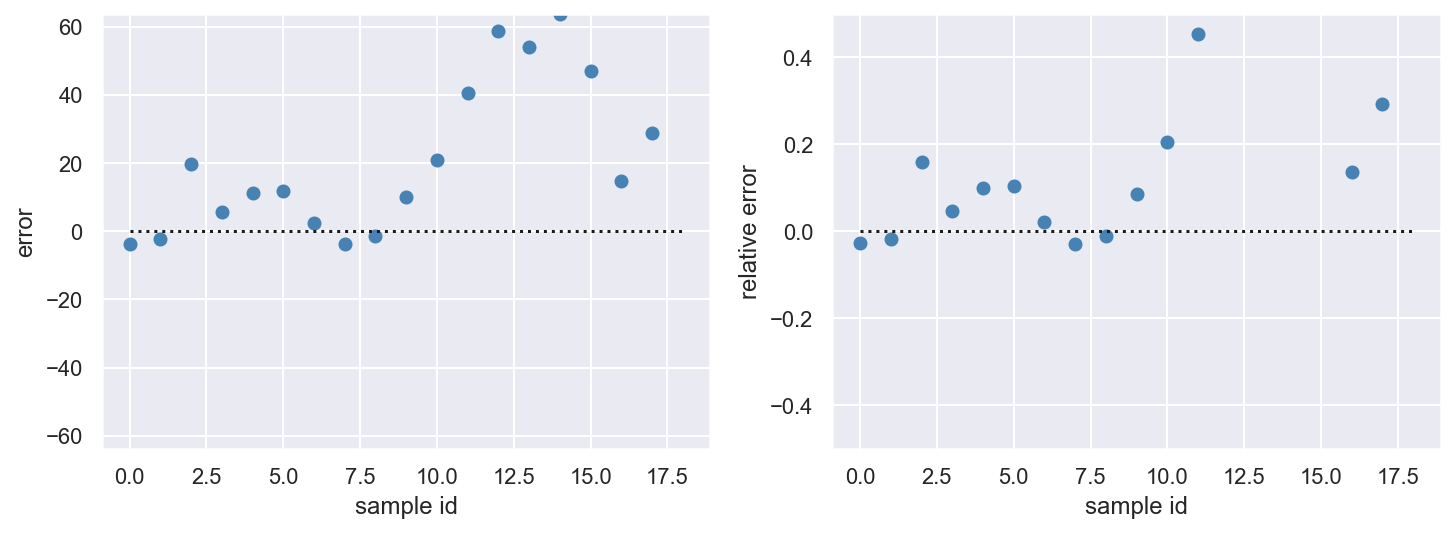

In [119]:
#Let us plot how good given and predicted values match on the training data set (code taken from the lecture Notebook W3)
plot_fit_quality(y_test2, y_test2_pred)

It turns out that the polynomial regression model with randomized splitting yields the best results. Fine-tuning of this model is not possible, since no parameter can be changed except the plynomial degree. So let's try it with the Elastic Net model:

## Fine-tuning

In [120]:
elanet_reg=ElasticNet(random_state=0)
# randomized splitting
elanet_reg.fit(X_train_scaled, y_train)

y_train_pred = elanet_reg.predict(X_train_scaled)
y_test_pred = elanet_reg.predict(X_test_scaled)

train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2))

train RMS: 36.82258278582142
test RMS: 40.60175189127773
train R2: 0.05
test R2: -0.05


In [121]:
from sklearn.model_selection import cross_val_score, cross_val_predict
# Perform 6-fold cross validation
scores = cross_val_score(elanet_reg, X_train_scaled, y_train, 
                         scoring="neg_mean_squared_error", cv=5)
scores

array([-1683.31164456, -1403.61117263, -1789.52739895, -2194.59713988,
        -837.4893825 ])

In [122]:
# Make cross validated predictions
y_train_pred_cv = cross_val_predict(elanet_reg, X_train_scaled, y_train, cv=5)

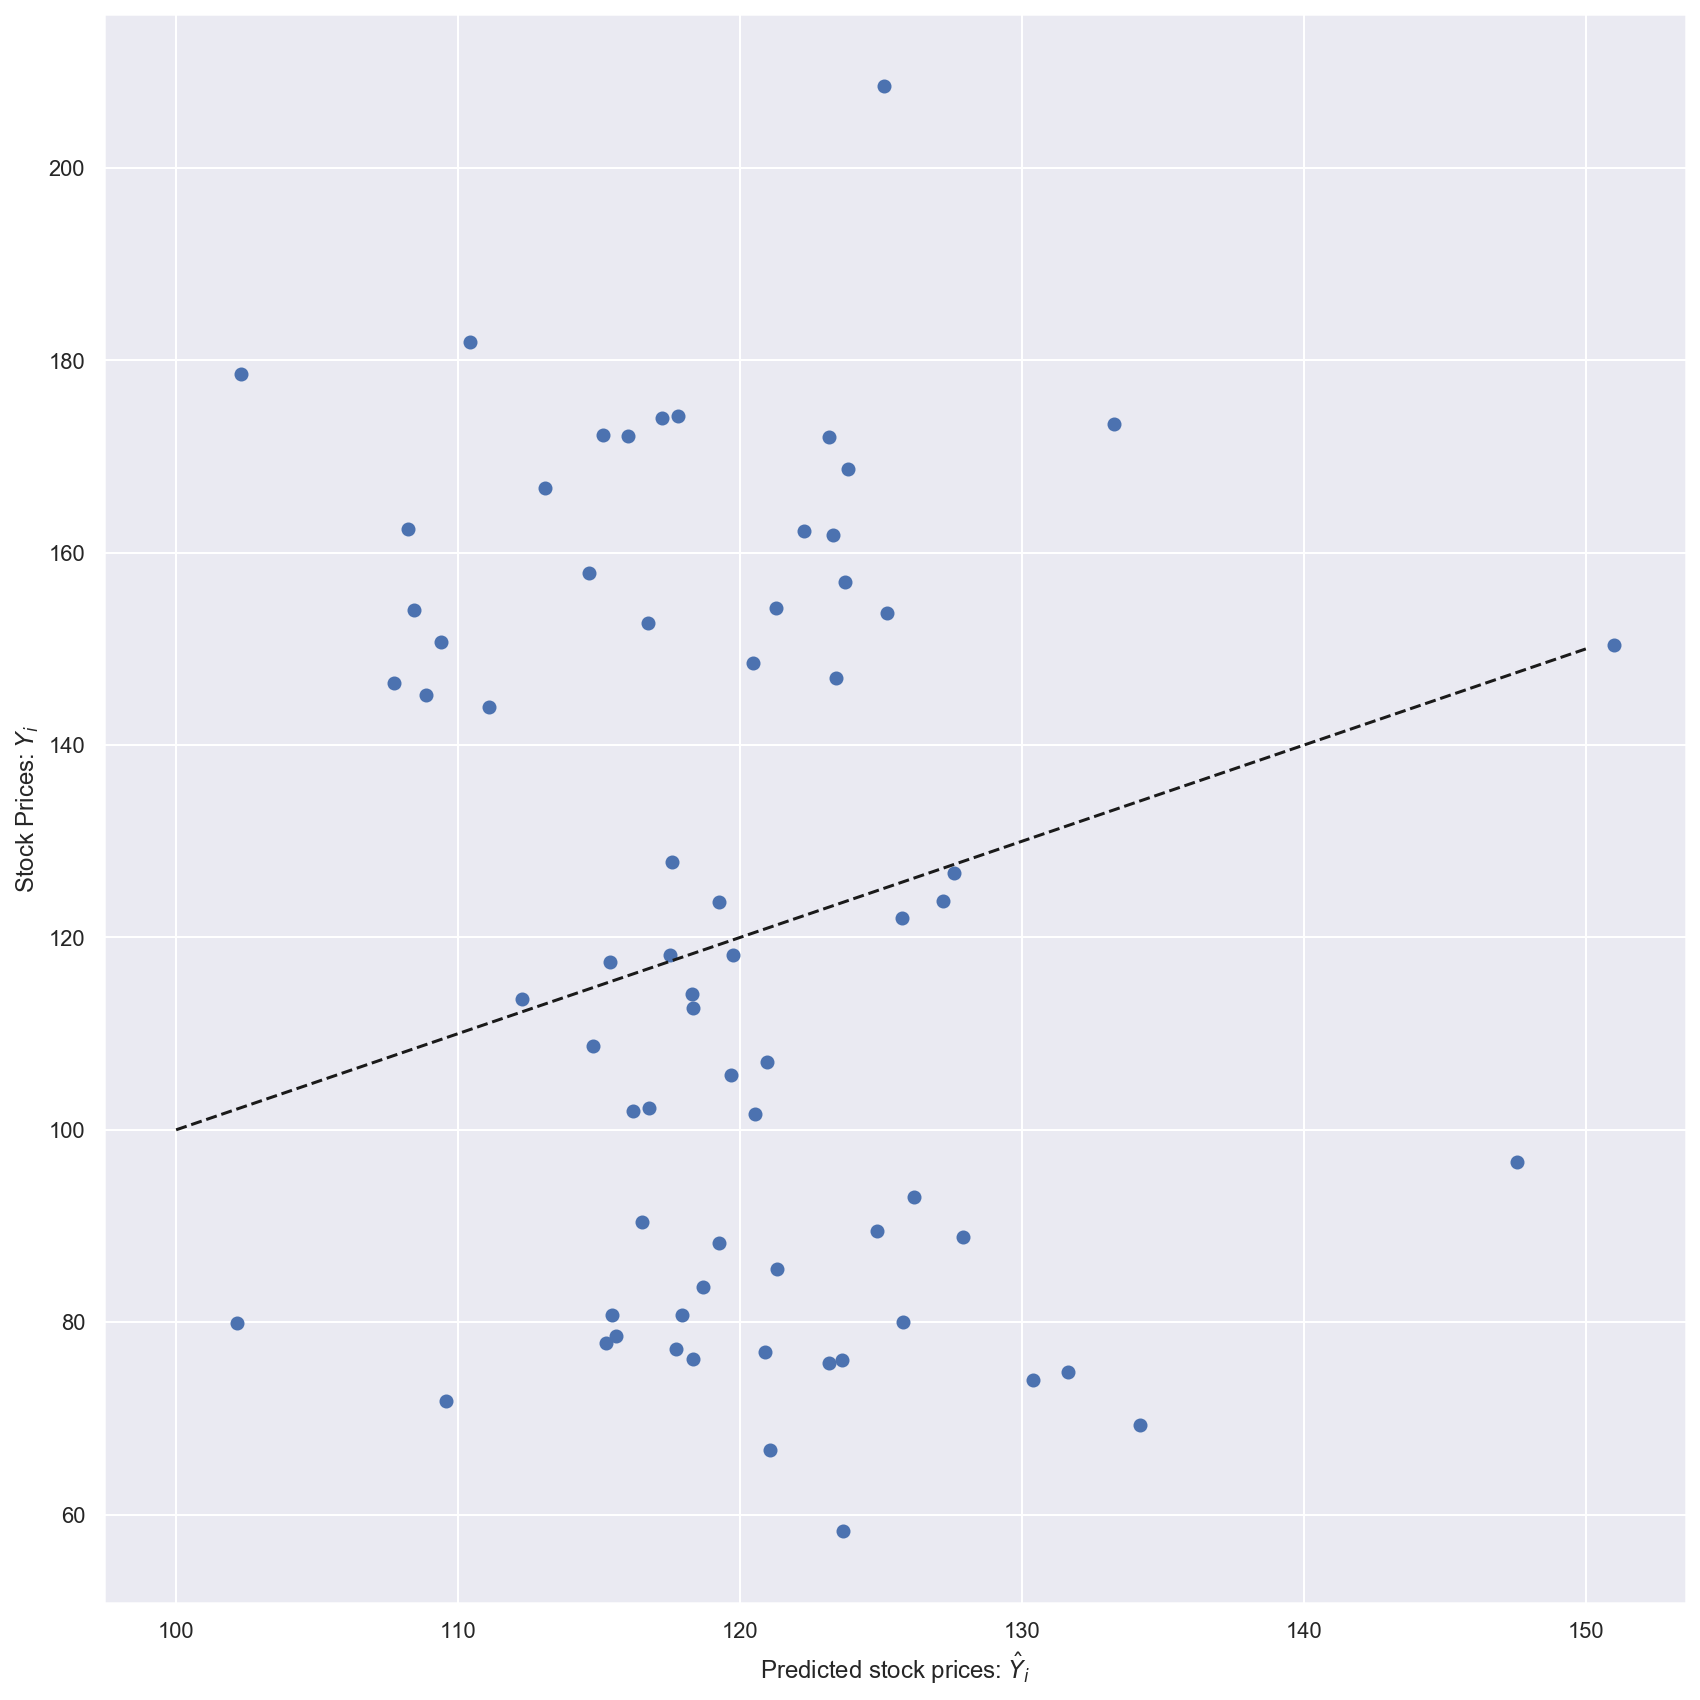

In [123]:
## plt.figure(figsize=(4, 3))
plt.scatter(y_train_pred_cv, y_train)
plt.plot([100, 150], [100, 150], '--k')
plt.axis('tight')
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.tight_layout()

In [124]:
accuracy =r2_score(y_train, y_train_pred_cv)
print('Cross-Predicted Accuracy:', accuracy)

Cross-Predicted Accuracy: -0.1126554584819881


#### Hyperparameters tuning

In [125]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'alpha': [0.0001, 0.001, 0.01, 0.1 ,1, 10]},
 ]
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(elanet_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=0, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

The best hyperparameter combination found:

In [126]:
grid_search.best_params_

{'alpha': 1}

In [127]:
grid_search.best_estimator_

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

Score of each hyperparameter combination tested during the grid search:

In [128]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

42.12200767672667 {'alpha': 0.0001}
42.115917363651 {'alpha': 0.001}
42.05742015680392 {'alpha': 0.01}
41.656824040821135 {'alpha': 0.1}
41.04893630233338 {'alpha': 1}
41.36581093214782 {'alpha': 10}


In [129]:
df_cvres=pd.DataFrame(cvres)
df_cvres['mean_test_score_pos_sqrt']=df_cvres['mean_test_score'].apply(lambda x: np.sqrt(-x))
df_cvres['log_param_alpha']=df_cvres['param_alpha'].apply(lambda x: np.log(x))
df_cvres.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.001591      0.000492         0.000399        0.000488      0.0001   
1       0.001398      0.000488         0.000200        0.000399       0.001   
2       0.001204      0.000398         0.000200        0.000399        0.01   
3       0.000805      0.000403         0.000601        0.000491         0.1   
4       0.001390      0.000793         0.000406        0.000497           1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}       -1802.596684       -1555.156129       -2051.934784   
1   {'alpha': 0.001}       -1802.741773       -1555.025839       -2051.950665   
2    {'alpha': 0.01}       -1804.173183       -1553.771549       -2052.090613   
3     {'alpha': 0.1}       -1816.882046       -1544.977961       -2052.015319   
4       {'alpha': 1}       -1887.660837       -1573.489103       -2021.511162   

   split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0       -2415.853588       -1045.776468     -1774.263531      462.221451   
1       -2414.995466       -1044.038733     -1773.750495      462.547440   
2       -2406.671317       -1027.426289     -1768.826590      465.673032   
3       -2348.430186        -914.149434     -1735.290989      488.549604   
4       -2226.985339        -715.429416     -1685.015172      529.256286   

   rank_test_score  split0_train_score  split1_train_score  \
0                6        -1314.710952        -1334.325021   
1                5        -1314.710979        -1334.325046   
2                4        -1314.713591        -1334.327370   
3                3        -1314.920265        -1334.495171   
4                1        -1321.935486        -1338.505820   

   split2_train_score  split3_train_score  split4_train_score  \
0        -1202.540146        -1162.114737        -1450.770398   
1        -1202.540193        -1162.115149        -1450.771175   
2        -1202.544702        -1162.154562        -1450.844260   
3        -1202.898356        -1164.628011        -1455.168486   
4        -1215.401035        -1197.185492        -1497.755515   

   mean_train_score  std_train_score  mean_test_score_pos_sqrt  \
0      -1292.892251       102.356730                 42.122008   
1      -1292.892508       102.356859                 42.115917   
2      -1292.916897       102.368840                 42.057420   
3      -1294.422058       103.042251                 41.656824   
4      -1314.156670       107.514519                 41.048936   

   log_param_alpha  
0        -9.210340  
1        -6.907755  
2        -4.605170  
3        -2.302585  
4         0.000000

Vizualizing the grid search results:

Text(0, 0.5, 'Avg. mean test score')

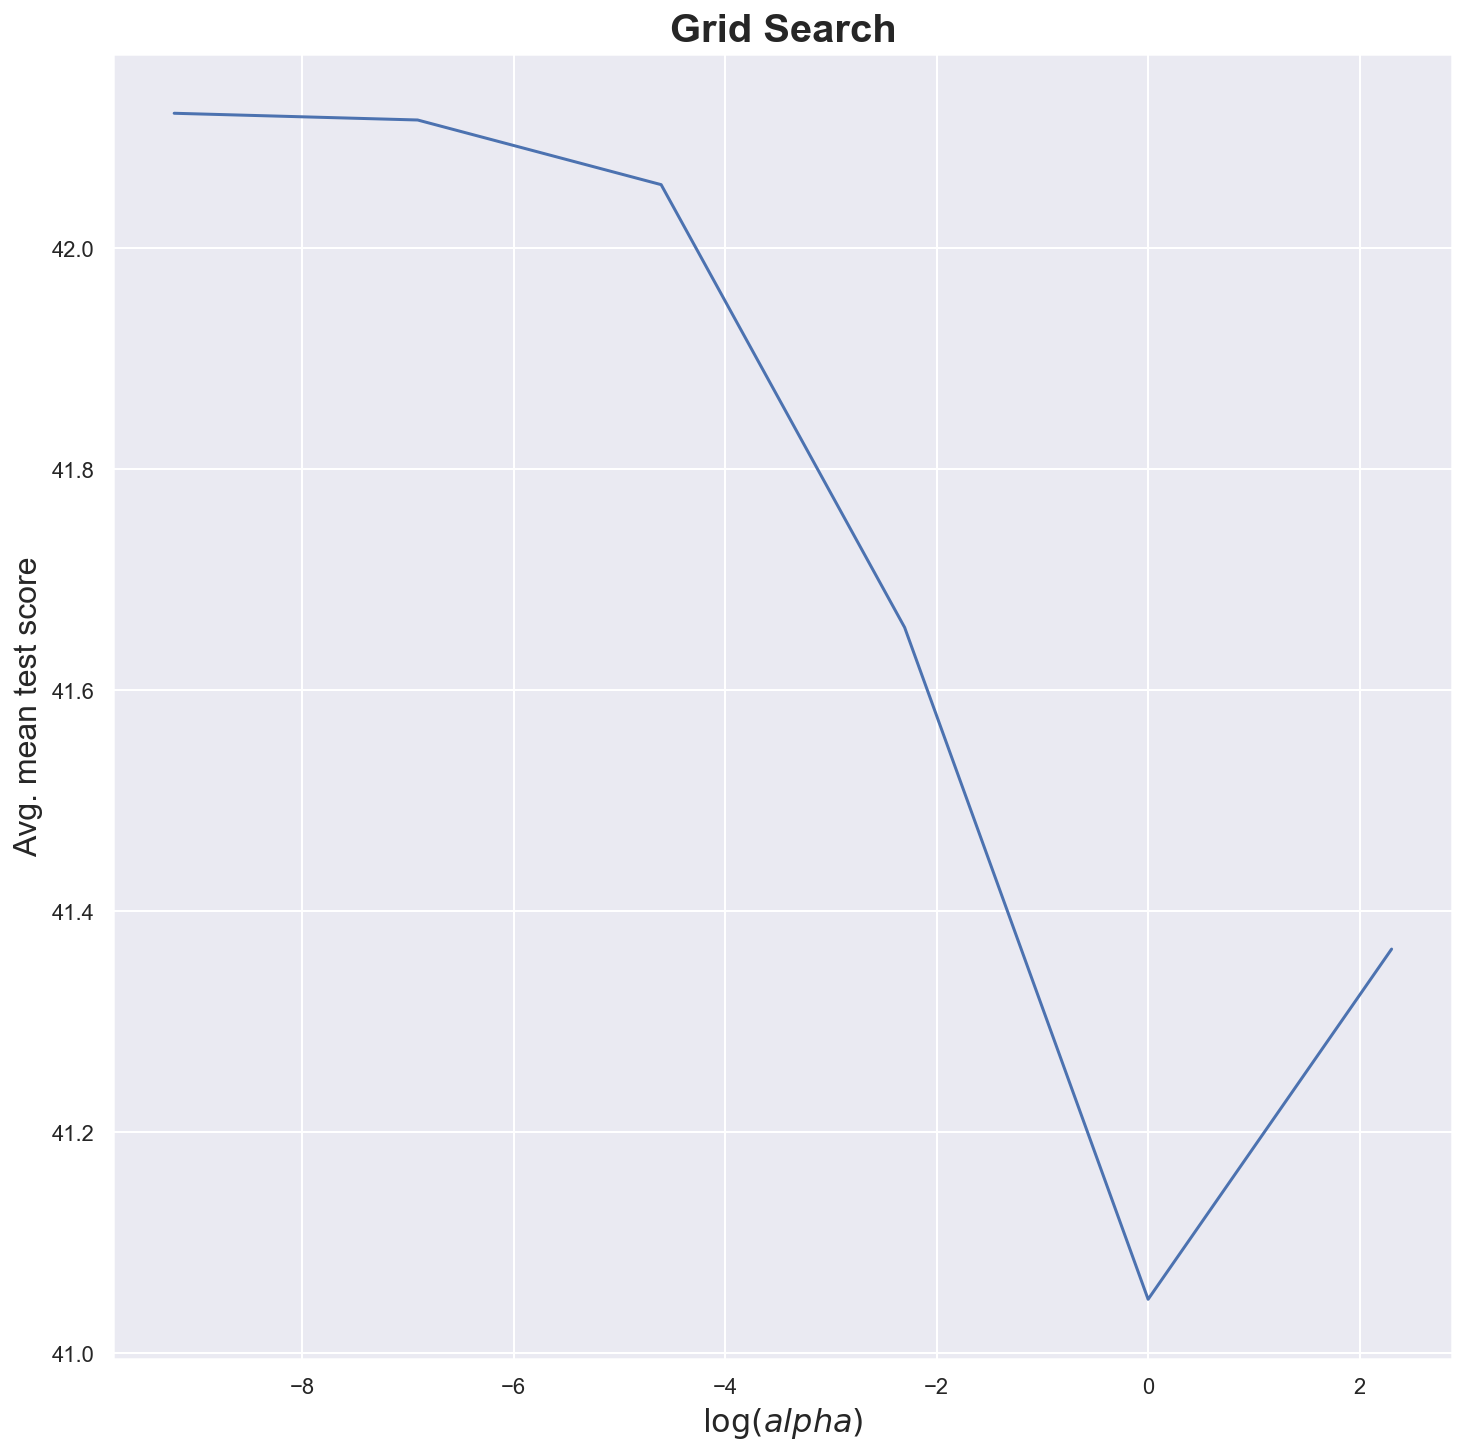

In [130]:
_, ax = plt.subplots(1,1)
plt.plot(df_cvres["log_param_alpha"], df_cvres["mean_test_score_pos_sqrt"])
ax.set_title("Grid Search", fontsize=20, fontweight='bold')
ax.set_xlabel("$\log (alpha)$", fontsize=16)
ax.set_ylabel('Avg. mean test score', fontsize=16)

In [131]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

# to make this notebook's output identical at every run
np.random.seed(42)

As expected from the poor model, no big change is observable when varying alpha.

## **Step 3: text analysis** [week 4]
- Featurize tweets (or another text dataset related to your subject): transform the text into a standard document-level dataset `X_doc`

In [132]:
# tweet data
X_num_raw.head()

tweet  created at  \
0  @AaronMinogueUSA @Vegicano @FollowYourHeart A+...  2018-08-17   
1  @BellaMarieCt1 Check out our store-locator to ...  2018-08-17   
2  @BoomChickaWow1 Thank you for you patience and...  2018-08-17   
3  @Captain_Quench @AWCanada We are working on ex...  2018-08-17   
4  @paulasulllivan @WholeFoods Hey Paula! We are ...  2018-08-17   

   favorite count  retweet count  key hashtag count key hashtag  \
0               1              0                  0         NaN   
1               1              0                  0         NaN   
2               1              0                  0         NaN   
3               1              0                  0         NaN   
4               2              1                  0         NaN   

   keyword count keywords  
0              0      NaN  
1              0      NaN  
2              0      NaN  
3              0      NaN  
4              0      NaN

In [133]:
df = X_num_raw.sort_values('created at')
# Reset Index
df = df.reset_index(drop=True)
#rename df['created at'] to df['Date'] (necessary for merging)
df_f = df.rename(columns = {'created at':'Date'})
df_f['Date'] = pd.to_datetime(df_f.Date)
df_f

tweet       Date  \
0     @AaronMinogueUSA @Vegicano @FollowYourHeart A+... 2018-08-17   
1     The #FutureofProtein is not going anywhere. ht... 2018-08-17   
2            @Marqel_whoelse We're dreaming of you too. 2018-08-17   
3     @andy_willmer Hi Andy! The Beyond Burger is cu... 2018-08-17   
4     @nygamecock *Us running to the grocery store* ... 2018-08-17   
...                                                 ...        ...   
1995              @jamietworkowski @ImpossibleFoods 🌱💚🌎 2020-05-01   
1996  Ain't no party like a #plantbasedparty 🎉 https... 2020-05-01   
1997  Help us FEED A MILLION+\nMay 1-3, buy a plant-... 2020-05-01   
1998  @jeramiedreyfuss @catnamedcatteri @WSJ Thank y... 2020-05-01   
1999         #PlantBasedParty 🥳 https://t.co/UBL0h0DXwp 2020-05-02   

      favorite count  retweet count  key hashtag count      key hashtag  \
0                  1              0                  0              NaN   
1                174             31                  0              NaN   
2                  1              1                  0              NaN   
3                  1              0                  0              NaN   
4                  1              0                  0              NaN   
...              ...            ...                ...              ...   
1995               3              0                  0              NaN   
1996              67             13                  1  plantbasedparty   
1997             117             48                  1  plantbasedparty   
1998               1              0                  0              NaN   
1999             102              8                  1  plantbasedparty   

      keyword count         keywords  
0                 0              NaN  
1                 0              NaN  
2                 0              NaN  
3                 0              NaN  
4                 0              NaN  
...             ...              ...  
1995              0              NaN  
1996              1  plantbasedparty  
1997              1  plantbasedparty  
1998              0              NaN  
1999              1  plantbasedparty  

[2000 rows x 8 columns]

In [134]:
bynd_stock_df.head()

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2019-05-02  46.000000  72.949997  45.000000  65.750000  65.750000  23119000
2019-05-03  72.000000  74.000000  65.660004  66.790001  66.790001  13139400
2019-05-06  62.730000  74.839996  62.500000  74.790001  74.790001   8746200
2019-05-07  77.139999  85.449997  75.000000  79.169998  79.169998  16532100
2019-05-08  83.610001  85.379997  70.785004  72.250000  72.250000  14696300

In [135]:
bynd_stock_df.tail()

Open        High        Low       Close   Adj Close  \
Date                                                                    
2020-04-27  111.919998  116.639999  97.500000   99.629997   99.629997   
2020-04-28  101.970001  104.480003  97.250000   99.519997   99.519997   
2020-04-29  100.559998  103.000000  97.919998  100.099998  100.099998   
2020-04-30   98.190002  107.000000  96.129997   98.989998   98.989998   
2020-05-01   94.400002   98.720001  89.900002   91.529999   91.529999   

              Volume  
Date                  
2020-04-27  20131500  
2020-04-28   7076500  
2020-04-29   4531300  
2020-04-30   6699200  
2020-05-01   6558400

Reduce twitter data to same date range as stock data (2019-05-02 to 2020-05-01)

In [136]:
df_t = df_f[(df_f['Date'] >= '2019-05-02') & (df_f['Date'] <= '2020-05-01')]
df_t = df_t.reset_index(drop=True)
df_t

tweet       Date  \
0           Learn more here ➡️ https://t.co/rgKhhNqiuR 2019-05-02   
1    Tomorrow is #BeyondDay. Grab a friend and Go B... 2019-05-02   
2    Thrilled to announce that today we became the ... 2019-05-02   
3               BYND #GoBeyond https://t.co/4mzsjD1zpK 2019-05-02   
4    TODAY is #BeyondDay. Try Beyond Meat for free ... 2019-05-03   
..                                                 ...        ...   
949                            @ShaniasmithCo @xmxcc 😋 2020-05-01   
950              @jamietworkowski @ImpossibleFoods 🌱💚🌎 2020-05-01   
951  Ain't no party like a #plantbasedparty 🎉 https... 2020-05-01   
952  Help us FEED A MILLION+\nMay 1-3, buy a plant-... 2020-05-01   
953  @jeramiedreyfuss @catnamedcatteri @WSJ Thank y... 2020-05-01   

     favorite count  retweet count  key hashtag count      key hashtag  \
0                59             10                  0              NaN   
1               549            214                  0              NaN   
2              2178            586                  0              NaN   
3               475             98                  0              NaN   
4               375            144                  0              NaN   
..              ...            ...                ...              ...   
949               1              0                  0              NaN   
950               3              0                  0              NaN   
951              67             13                  1  plantbasedparty   
952             117             48                  1  plantbasedparty   
953               1              0                  0              NaN   

     keyword count         keywords  
0                0              NaN  
1                1             meat  
2                1             food  
3                0              NaN  
4                1             meat  
..             ...              ...  
949              0              NaN  
950              0              NaN  
951              1  plantbasedparty  
952              1  plantbasedparty  
953              0              NaN  

[954 rows x 8 columns]

In [138]:
# merge to get y for every date
# use option, how = 'inner' to deal with temporality issue 
y = bynd_stock_df['High']
df1 = pd.merge(df_t, y, how='inner', on=['Date'])
df1.head()

tweet       Date  \
0         Learn more here ➡️ https://t.co/rgKhhNqiuR 2019-05-02   
1  Tomorrow is #BeyondDay. Grab a friend and Go B... 2019-05-02   
2  Thrilled to announce that today we became the ... 2019-05-02   
3             BYND #GoBeyond https://t.co/4mzsjD1zpK 2019-05-02   
4  TODAY is #BeyondDay. Try Beyond Meat for free ... 2019-05-03   

   favorite count  retweet count  key hashtag count key hashtag  \
0              59             10                  0         NaN   
1             549            214                  0         NaN   
2            2178            586                  0         NaN   
3             475             98                  0         NaN   
4             375            144                  0         NaN   

   keyword count keywords       High  
0              0      NaN  72.949997  
1              1     meat  72.949997  
2              1     food  72.949997  
3              0      NaN  72.949997  
4              1     meat  74.000000

### Featurize Text

In [139]:
#import and load all nessecary packages
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Create list for POS
word_groups = ('VERB', 'NOUN', 'ADJ')

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)
    
    # Tag parts of speech, keep nouns and verbs and adjectives   
    mytokens= [word for word in mytokens if word.pos_ in word_groups]

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [140]:
# See if it works on example 
ex1 = df_t['tweet'].loc[0:10]
ex1.apply(spacy_tokenizer)

0                      [learn, https://t.co/rgkhhnqiur]
1     [tomorrow, grab, friend, partner, favorite, re...
2     [thrill, announce, today, 1st, plant, base, fo...
3                                                    []
4     [today, try, free, @theepicburger, restriction...
5     [@ravenmackenzie, thank, let, know, delay, pro...
6     [@ojaiparanormal, @theepicburger, thank, let, ...
7           [let, nbaplayoffs, https://t.co/nxkdhf3lv8]
8                [find, score, free, beyondtaco, today]
9     [look, past, day, humble, history, amp, proud,...
10    [available, location, find, https://t.co/gzfvw...
Name: tweet, dtype: object

In [141]:
# tf-idf vectorizer up-weights rare/distinctive words
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, 
                               min_df=0.001, 
                               max_df=0.9,
                               max_features=10000,
                               use_idf=True,
                               ngram_range=(2,2))

# apply ft-idf vectorizer, including text preprocessing from spacy_tokenizer:
X_tfidf = tfidf_vector.fit_transform(df1['tweet'].values.astype('U'))

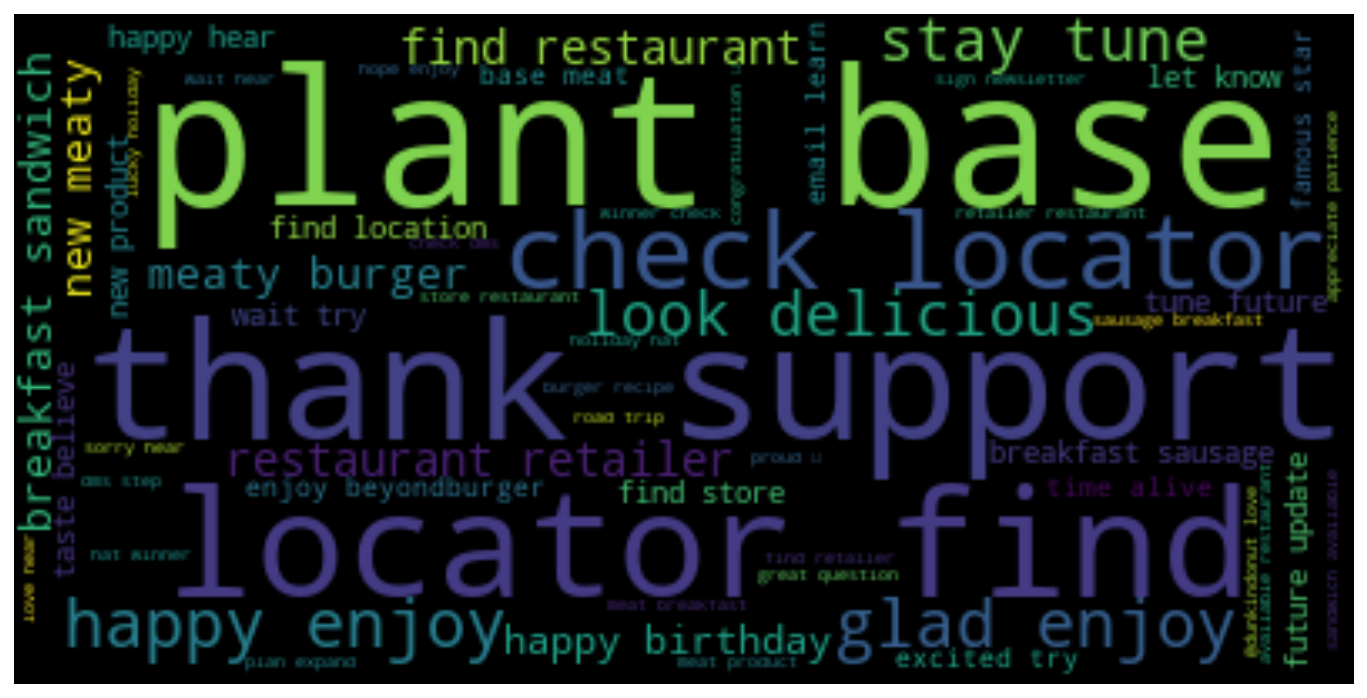

In [142]:
# generate word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

f = X_tfidf
vocab = tfidf_vector.get_feature_names()
total_freqs = list(np.array(f.sum(axis=0))[0])
fdict = dict(zip(vocab,total_freqs))
# generate word cloud of words with highest counts
wordcloud = WordCloud().generate_from_frequencies(fdict) 
plt.clf()
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.show()

## **Step 2b: estimate different regression models using `X_doc` and `y`** [week 3]

In [143]:
X_doc = X_tfidf # the features we want to analyze
y = df1['High']

X_train, X_test, y_train, y_test = train_test_split(X_doc, y, test_size=0.2, random_state= 1)

### Ridge Regression

In [144]:
# randomized splitting
ridge_reg = Ridge(alpha=1)       
ridge_reg.fit(X_train, y_train)

y_train_pred = ridge_reg.predict(X_train)
y_test_pred = ridge_reg.predict(X_test) 

train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 4)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 4))

train RMS: 27.575031348523513
test RMS: 41.66285718137194
train R2: 0.59
test R2: 0.0985


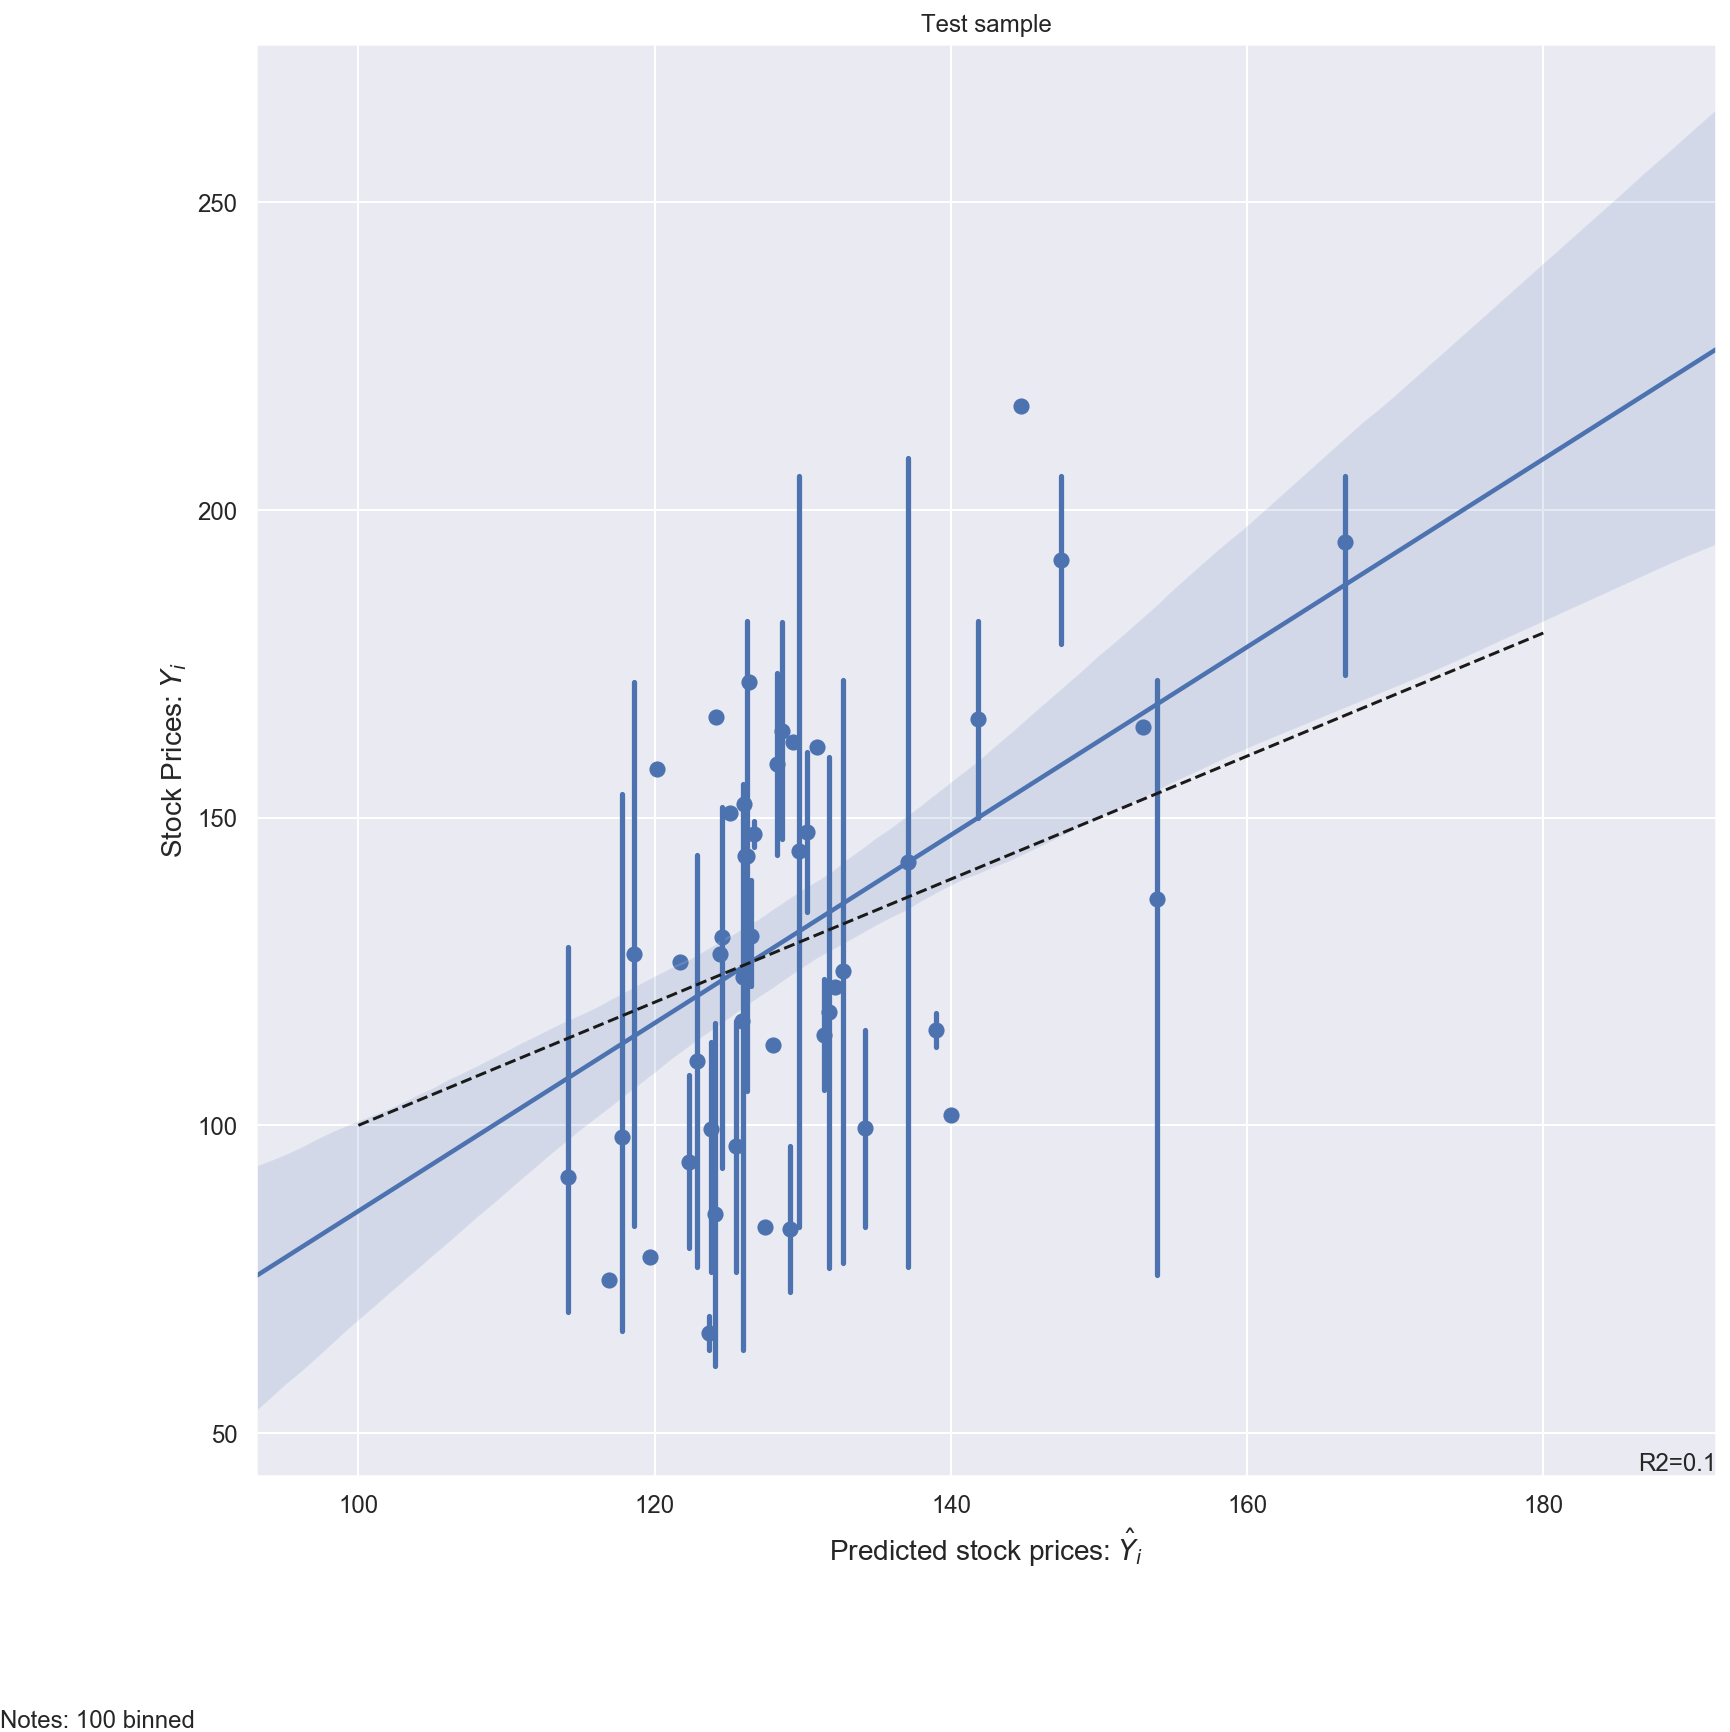

In [145]:
# randomized splitting
r2 = r2=round(r2_score(y_test, y_test_pred), 2)

# Regplot (code taken from the lecture Notebook W3)
g=sns.regplot(x= y_test_pred, y=y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([100, 180], [100, 180], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

### Polynomial regression

In [146]:
# randomized splitting
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)

y_train_pred = lin_reg.predict(X_train_poly)
y_test_pred = lin_reg.predict(X_test_poly)

train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(y_test,y_test_pred)
test_rmse = np.sqrt(test_mse)

print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2))

train RMS: 19.85180459159318
test RMS: 41.66988004186756
train R2: 0.79
test R2: 0.1


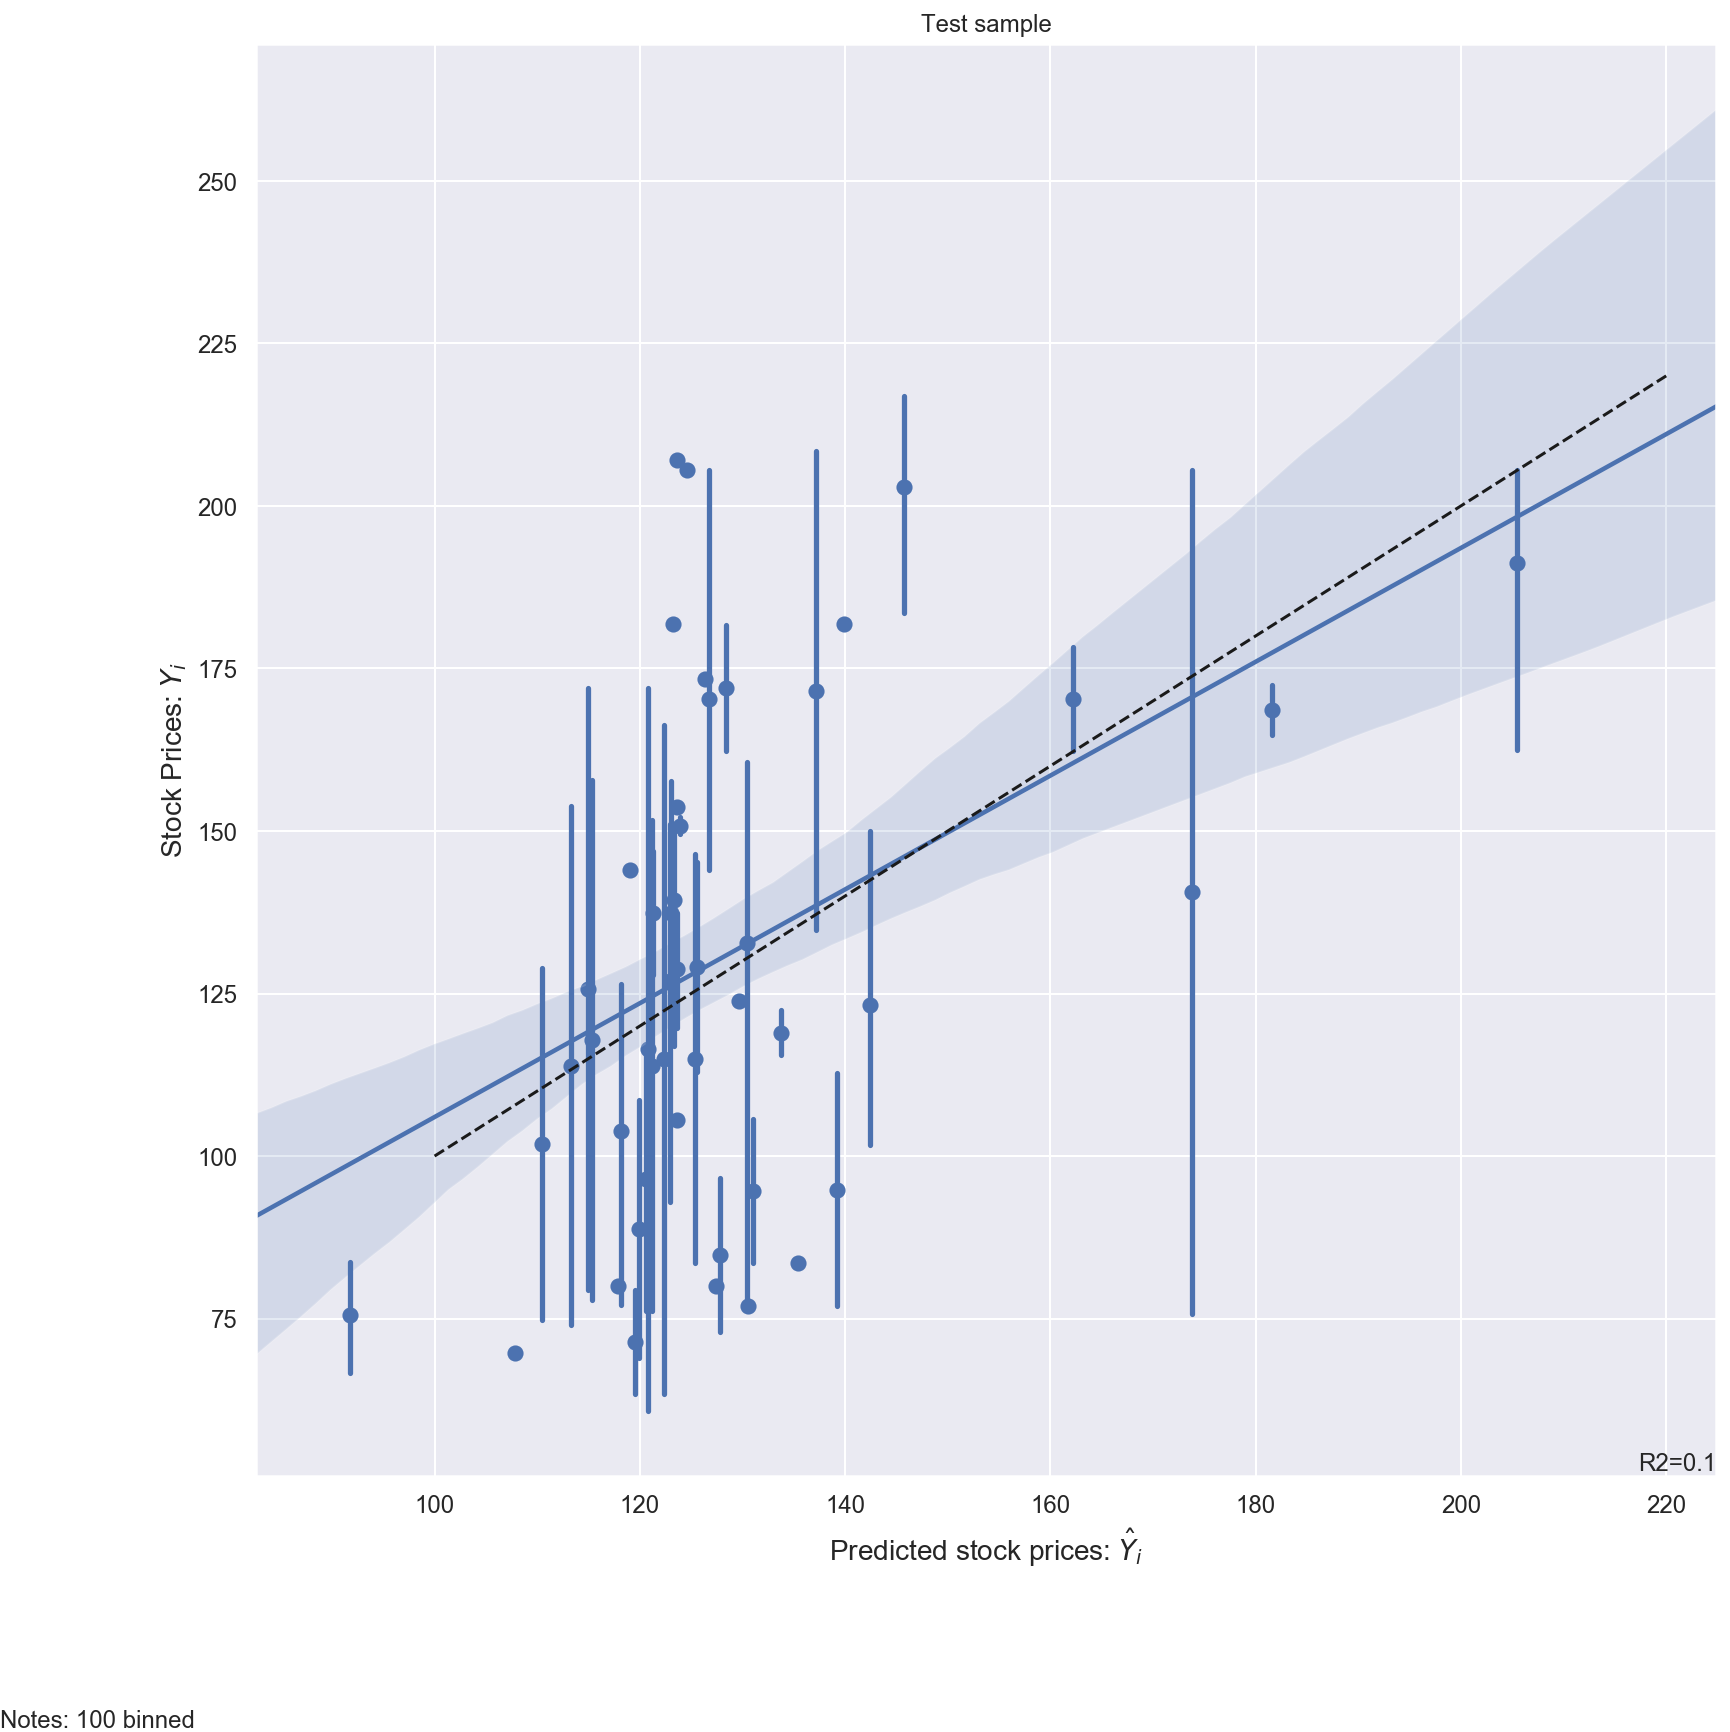

In [147]:
# randomized splitting
r2 = r2=round(r2_score(y_test, y_test_pred), 2)

# Regplot
g=sns.regplot(x= y_test_pred, y=y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([100, 220], [100, 220], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

## **Step 4: estimate a classification models** [week 5]
- propose a categorical variable `y_calc` that you can compute from the continuous one (`y`) (e.g. positive or negative growthin stock prices). For the `X` dimension, you can use `X_doc` or `X_num` or both. 
- you can use any other categorical variable that you find relevant

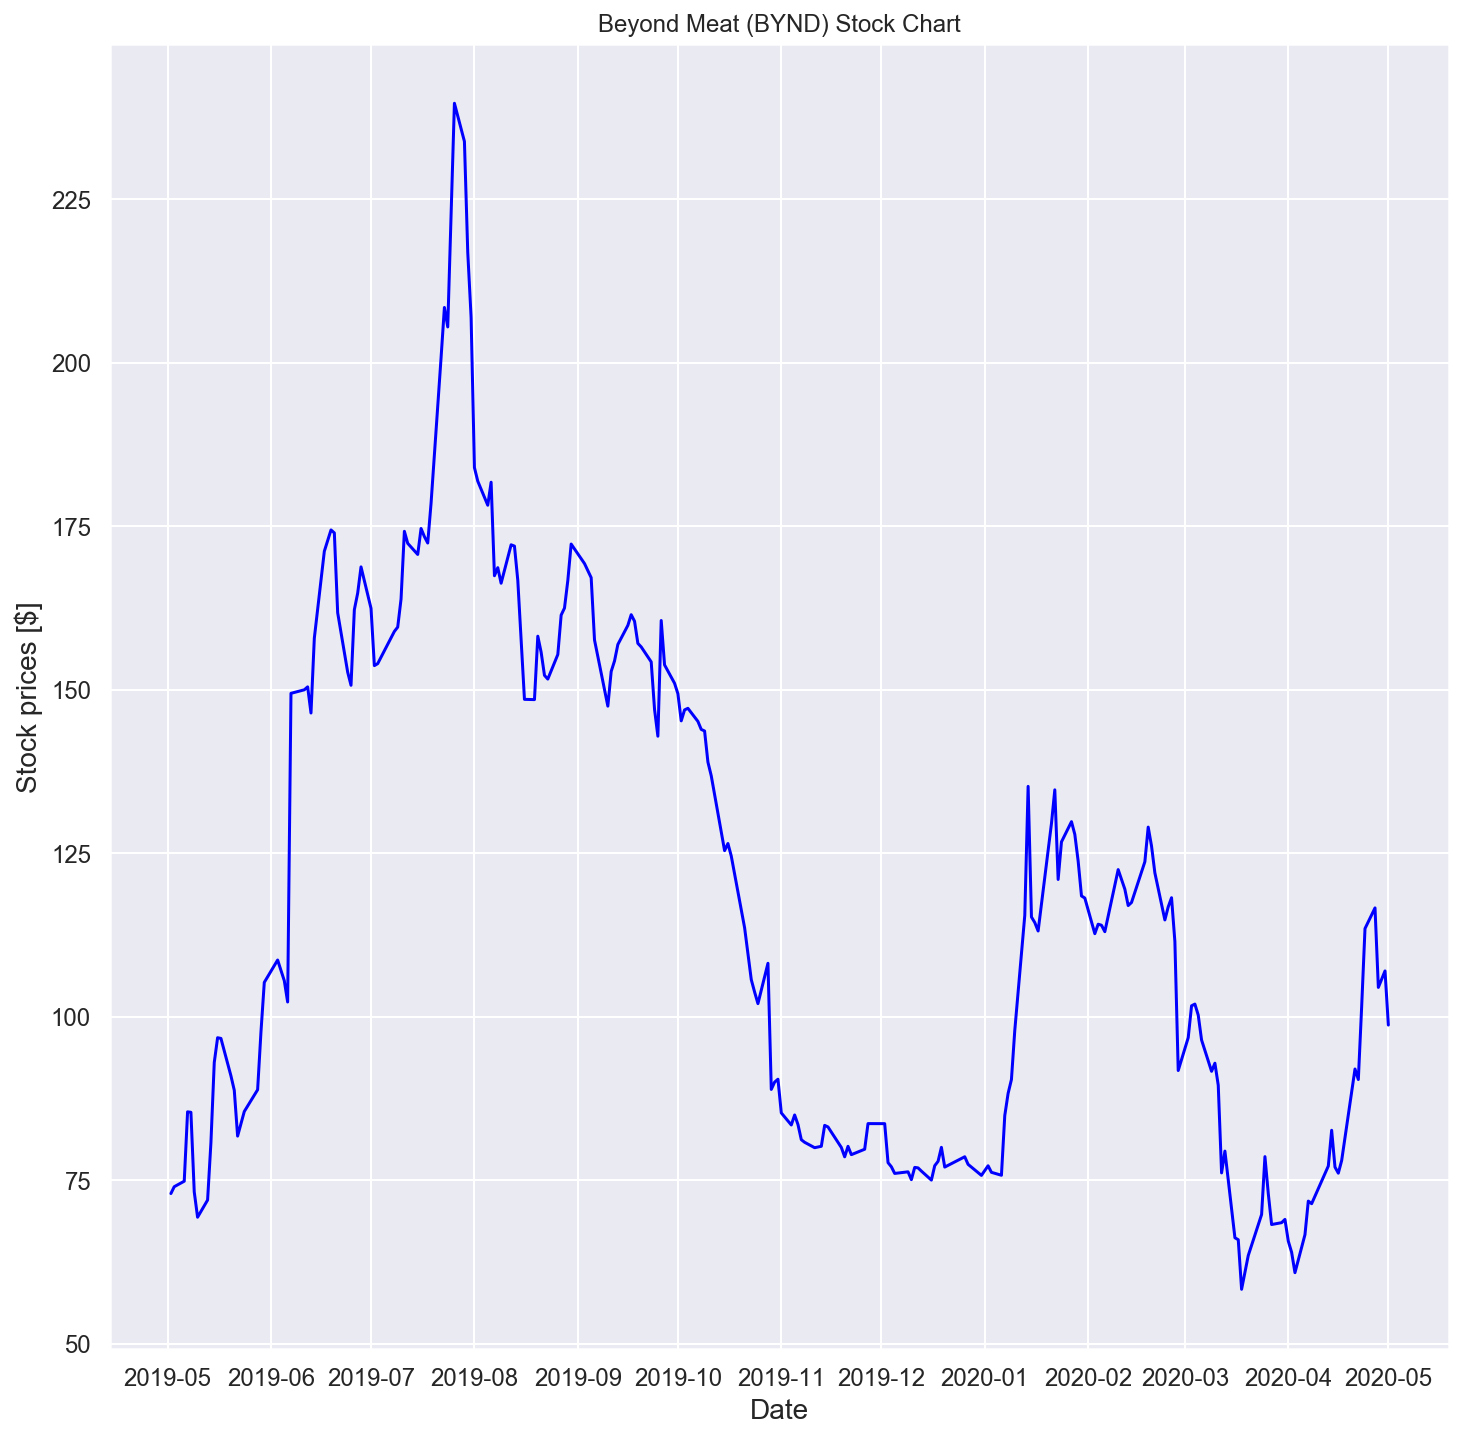

In [148]:
# Plot y
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
fig, ax1 = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis for ax1
ax1.plot("Date", "High", data = df1, color= "blue")


# Set title and labels for axes
ax1.set(xlabel="Date",
       ylabel="Stock prices [$]",
       title="Beyond Meat (BYND) Stock Chart")

# Define the date format
date_form = DateFormatter("%Y-%m")
ax1.xaxis.set_major_formatter(date_form)

# Ensure a major tick for eg. each month using (interval=1) 
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

In [149]:
# Need an indicator to see whether there is
# a positive or negative growth 

# How

# Proposal: we have 2 categories: positive, negative

# pos = 1
# neg = 0


y_dummy = []

# pos: 
for ind in range(len(y)-1): 
    if y[ind] < y[ind+1]:
        val = 0
        y_dummy.append(val)
    
    else:
        val2 = 1
        y_dummy.append(val2)

# add value to last row as  y[ind] < y[ind+1] doesnt work there:
y_dummy.append(1)

In [150]:
# check length
len(y_dummy)

895

In [151]:
# check lenght
len(df1.High)

895

In [152]:
# add your dummy variable to 
df1['dummy_growth'] = y_dummy

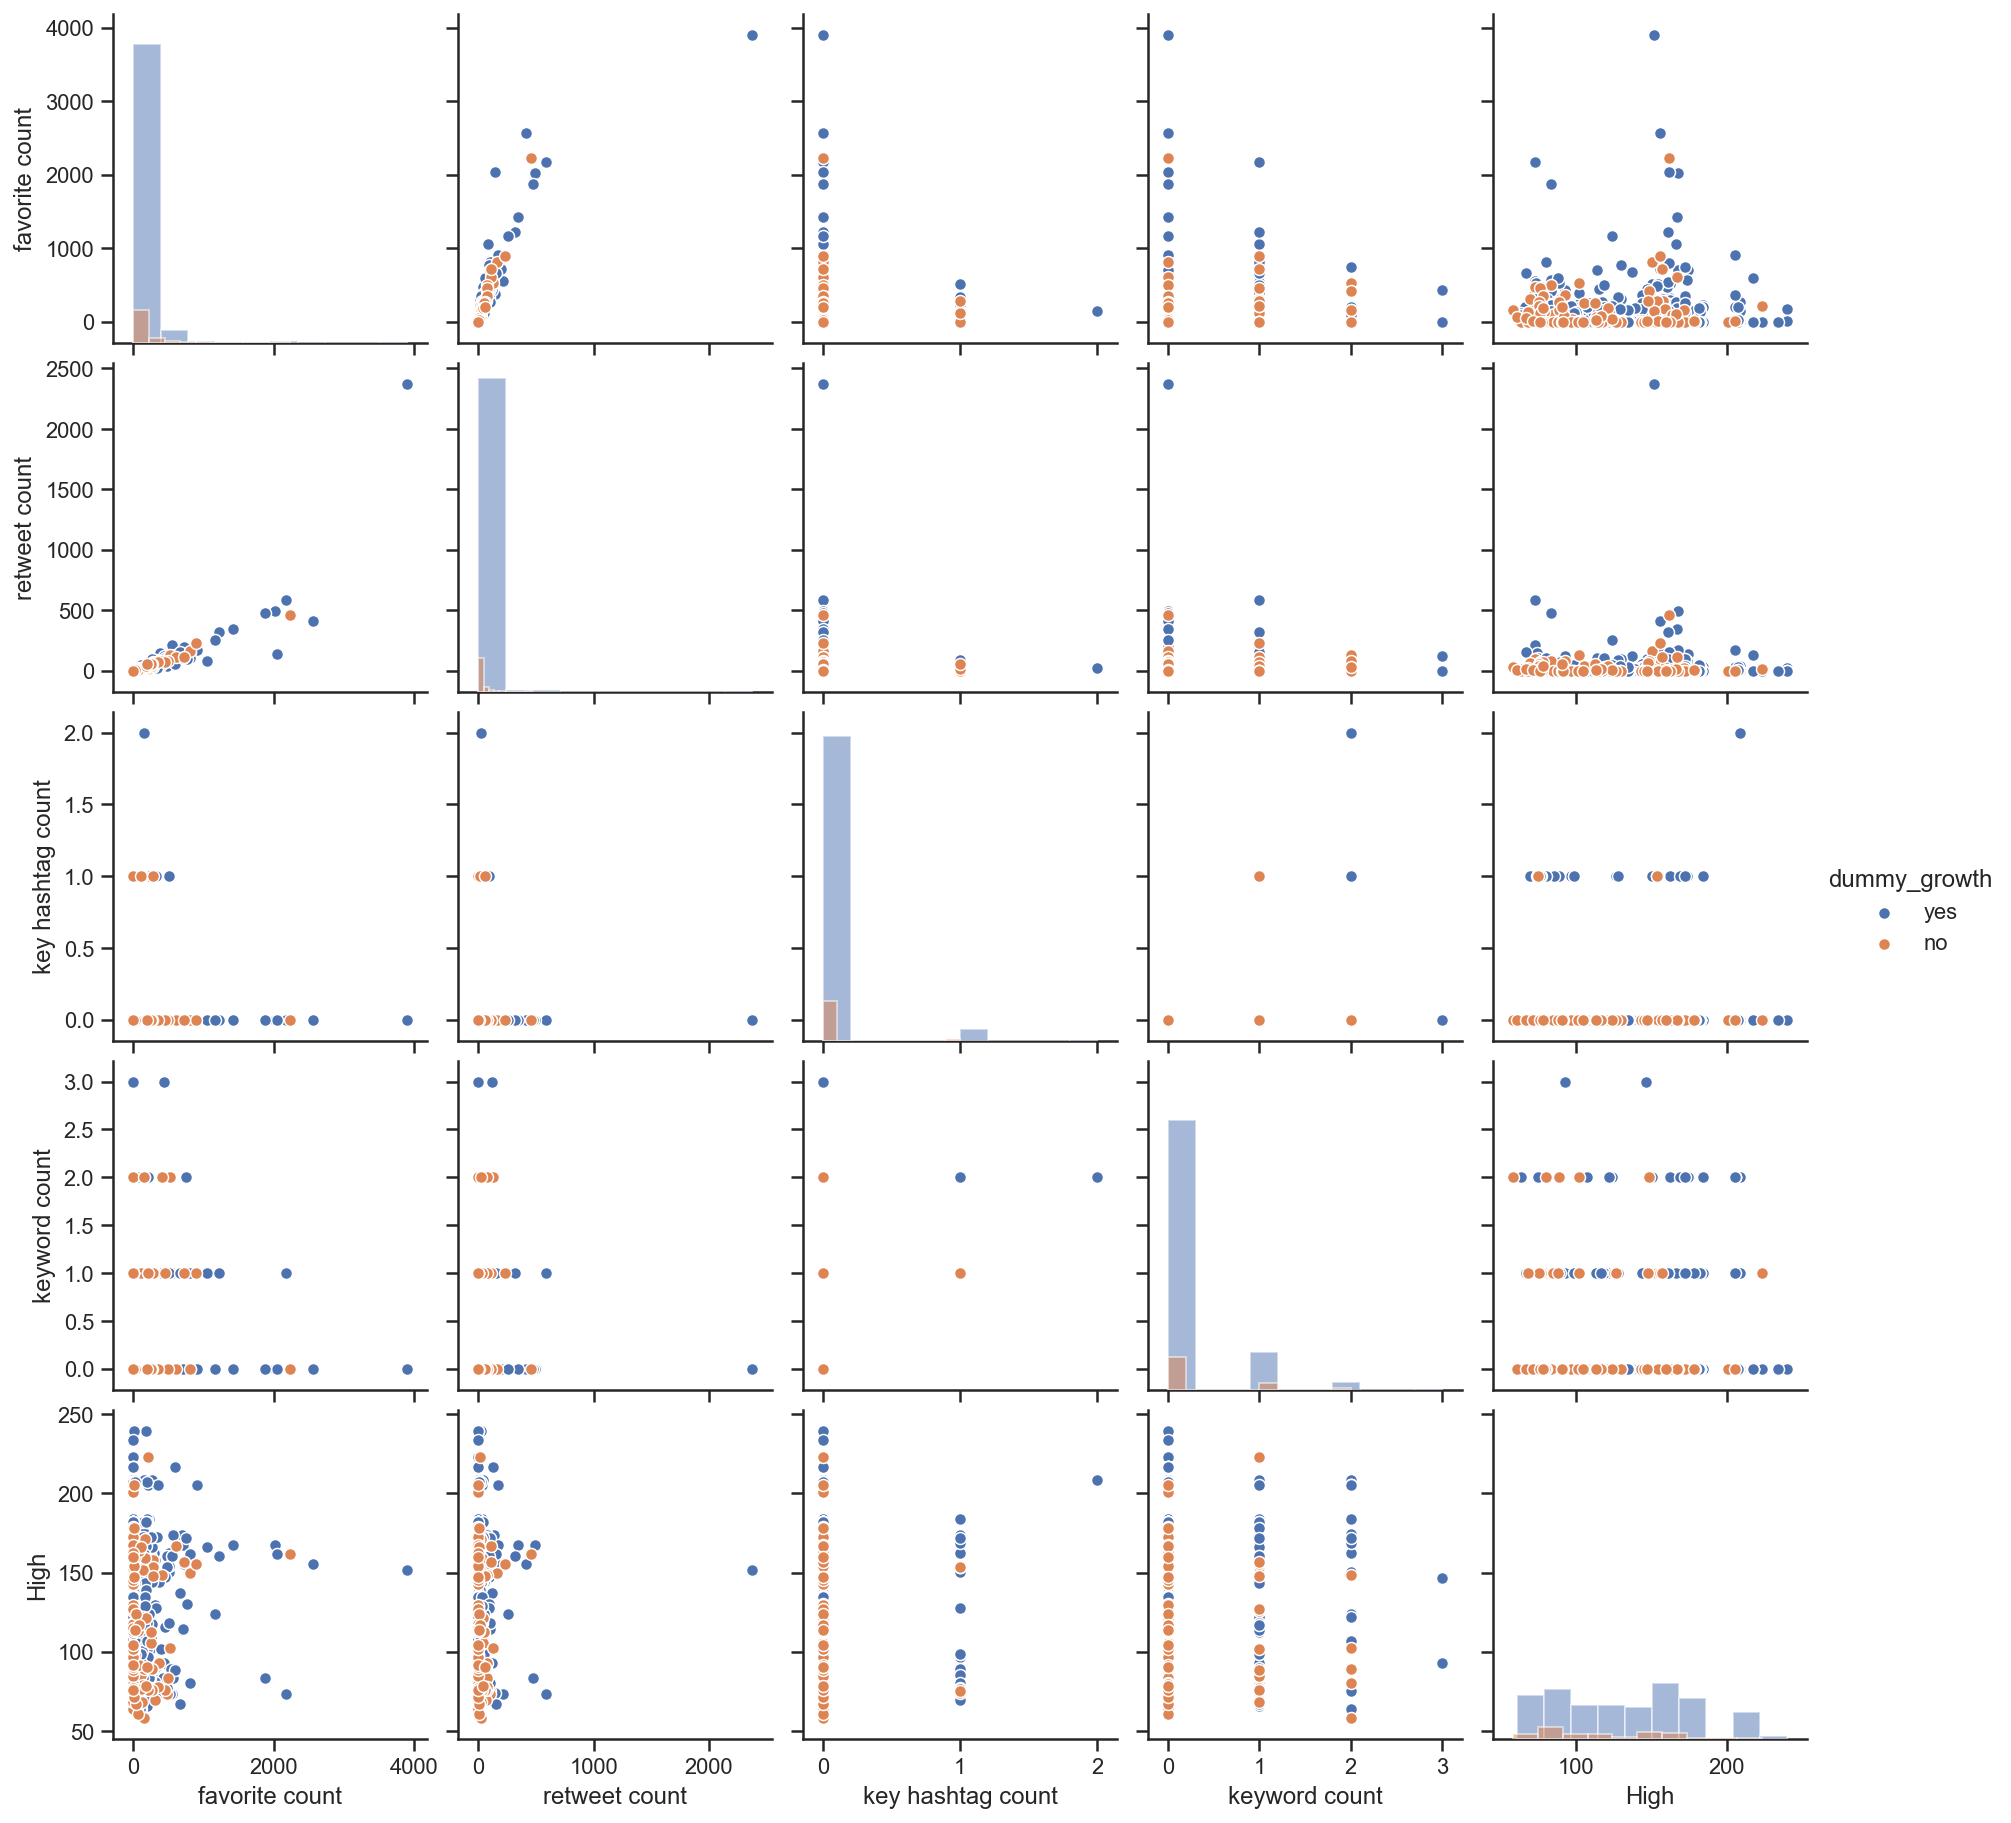

In [153]:
# Visually inspect data using seaborn
import seaborn as sns
sns.set(style="ticks")

for_plot = df1.copy()

def translate_label(value):
    # seaborn has issues if labes are numbers or strings which represent numbers,
    # for whatever reason "real" text labels work
    return "no" if value == 0 else "yes"

for_plot['dummy_growth'] = for_plot['dummy_growth'].apply(translate_label)

sns.pairplot(for_plot, hue='dummy_growth', diag_kind="hist", diag_kws = dict(alpha=.5) );

#### Two helper functions

In [154]:
def samples_color(ilabels, colors=["steelblue", "chocolate"]):
    '''Return colors list from labels list given as indices.'''
    return [colors[int(i)] for i in ilabels]

def plot_decision_surface(
    X_doc, y_calc, classifier, preprocessing=None,
    plt=plt, marker='.', N=100, alpha=0.2, colors=["steelblue", "chocolate"], title=None,
    test_features_2d=None, test_labels=None, test_s=60,
):
    '''Plot a 2D decision surface for a already trained classifier.'''

    # sanity check
    assert len(X_doc.columns) == 2

    # pandas to numpy array; get min/max values
    xy = np.array(features_2d)
    min_x, min_y = xy.min(axis=0)
    max_x, max_y = xy.max(axis=0)

    # create mesh of NxN points; tech: `N*1j` is spec for including max value
    XX, YY = np.mgrid[min_x:max_x:N*1j, min_y:max_y:N*1j]
    points = np.c_[XX.ravel(), YY.ravel()] # shape: (N*N)x2

    # apply scikit-learn API preprocessing
    if preprocessing is not None:
        points = preprocessing.transform(points)
    
    # classify grid points
    classes = classifier.predict(points)

    # plot classes color mesh
    ZZ = classes.reshape(XX.shape) # shape: NxN
    plt.pcolormesh(
        XX, YY, ZZ,
        alpha=alpha, cmap=matplotlib.colors.ListedColormap(colors),
    )
    # plot points
    plt.scatter(
        xy[:,0], xy[:,1],
        marker=marker, color=samples_color(labels, colors=colors),
    );
    # set title
    if title:
        if hasattr(plt, 'set_title'):
            plt.set_title(title)
        else:
            plt.title(title)
    # plot test points
    if test_features_2d is not None:
        assert test_labels is not None
        assert len(test_features_2d.columns) == 2
        test_xy = np.array(test_features_2d)
        plt.scatter(
            test_xy[:,0], test_xy[:,1],
            s=test_s, facecolors='none', color=samples_color(test_labels),
        );

## Classifier

In [155]:
# Import metrics
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score)

In [156]:
#splitting data

X_doc = X_tfidf # the features we want to analyze
y_calc = df1['dummy_growth'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X_doc, y_calc, test_size=0.2, random_state= 1)

### Logistic Regression

In [157]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(C=1, random_state= 0)
classifier

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [158]:
# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 88.83%
test score: 87.15%

F1 score on training: 94.08%

Confusion Matrix
[[  0  23]
 [  0 156]]


### Nearest Neighbors

In [159]:
from sklearn.neighbors import KNeighborsClassifier

# Let's use 5 neighbors to learn
classifier = KNeighborsClassifier(n_neighbors=5)

# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 89.11%
test score: 87.15%

F1 score on training: 94.22%

Confusion Matrix
[[  0  23]
 [  0 156]]


In [160]:
# Changing the parameters
n_neighbors_list = [1, 10, 100]
p_list = [1, 2] #1=Manhatan distance norm ; 2=Euclidian distance

print()
for p in p_list:
    print()
    print('# Distance ', p)
    print()
    for n_neighbors in n_neighbors_list:
        print('## Nb neighbors: ', n_neighbors)
        # Note: increase max iterations 10x for solver's convergence
        classifier = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
        
        classifier.fit(X_train, y_train)
        
        
        print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
        print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
        # print('weights: ', classifier.coef_[0])



# Distance  1

## Nb neighbors:  1
train score: 98.04%
test score: 86.59%
## Nb neighbors:  10
train score: 88.83%
test score: 87.15%
## Nb neighbors:  100
train score: 88.83%
test score: 87.15%

# Distance  2

## Nb neighbors:  1
train score: 98.04%
test score: 86.59%
## Nb neighbors:  10
train score: 88.83%
test score: 87.15%
## Nb neighbors:  100
train score: 88.83%
test score: 87.15%


### Linear SVM

In [161]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

In [162]:
classifier = LinearSVC(C=1)

# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 98.04%
test score: 86.59%

F1 score on training: 98.91%

Confusion Matrix
[[  0  23]
 [  1 155]]


### Kernel based SVM

In [163]:
from sklearn.svm import SVC

classifier = SVC(kernel='rbf', gamma=20)

# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 98.04%
test score: 86.59%

F1 score on training: 98.91%

Confusion Matrix
[[  0  23]
 [  1 155]]


In [164]:
kernel = 'rbf'
gammas = [0.05, 0.5, 5, 50, 'scale',]

for i, gamma in enumerate(gammas):
    classifier = SVC(kernel=kernel, gamma=gamma)
    classifier.fit(X_train, y_train)
    print('##gamma= {}'.format(gamma))
    print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
    print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
    print()

##gamma= 0.05
train score: 88.83%
test score: 87.15%

##gamma= 0.5
train score: 88.83%
test score: 87.15%

##gamma= 5
train score: 98.04%
test score: 86.59%

##gamma= 50
train score: 98.04%
test score: 86.59%

##gamma= scale
train score: 97.63%
test score: 86.59%



## **Step 5: Dimension reduction** [week 6]
- Use one of the dimension reductions methods to dimension-reduce the features
    - PCA or topic model (LDA or STM) or k-means clustering on the featurized text `X_doc`
- Run another classifier

In [168]:
import re, nltk, spacy, gensim
from spacy.lang.en import English

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.cluster import hierarchy

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [165]:
df1.head()

tweet       Date  \
0         Learn more here ➡️ https://t.co/rgKhhNqiuR 2019-05-02   
1  Tomorrow is #BeyondDay. Grab a friend and Go B... 2019-05-02   
2  Thrilled to announce that today we became the ... 2019-05-02   
3             BYND #GoBeyond https://t.co/4mzsjD1zpK 2019-05-02   
4  TODAY is #BeyondDay. Try Beyond Meat for free ... 2019-05-03   

   favorite count  retweet count  key hashtag count key hashtag  \
0              59             10                  0         NaN   
1             549            214                  0         NaN   
2            2178            586                  0         NaN   
3             475             98                  0         NaN   
4             375            144                  0         NaN   

   keyword count keywords       High  dummy_growth  
0              0      NaN  72.949997             1  
1              1     meat  72.949997             1  
2              1     food  72.949997             1  
3              0      NaN  72.949997             0  
4              1     meat  74.000000             1

In [169]:
df_scale = df1[['favorite count','retweet count','key hashtag count','keyword count','High','dummy_growth']]
df_scale.head()

favorite count  retweet count  key hashtag count  keyword count       High  \
0              59             10                  0              0  72.949997   
1             549            214                  0              1  72.949997   
2            2178            586                  0              1  72.949997   
3             475             98                  0              0  72.949997   
4             375            144                  0              1  74.000000   

   dummy_growth  
0             1  
1             1  
2             1  
3             0  
4             1

In [170]:
X = pd.DataFrame(scale(df_scale), index=df_scale.index, columns=df_scale.columns)

Text(0.5, 0, 'keyword count')

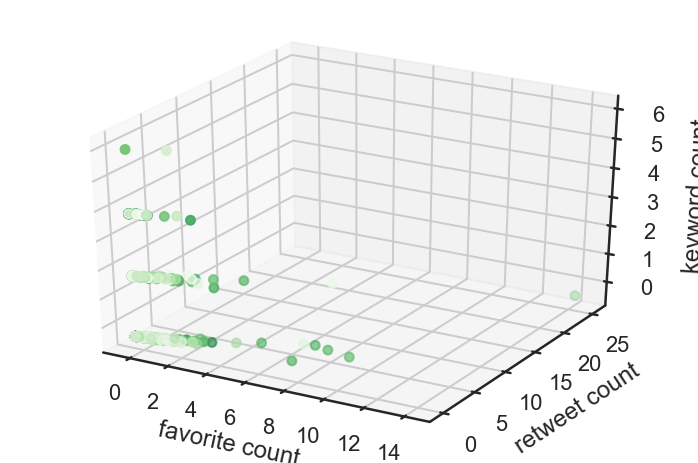

In [171]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(X['favorite count'], X['retweet count'], X['keyword count'], c=X['High'], cmap='Greens');
ax.set_xlabel('favorite count')
ax.set_ylabel('retweet count')
ax.set_zlabel('keyword count')

## Topic models

In [172]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df1['tweet']))

In [173]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [174]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

### Check the Sparsicity

In [175]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.7738198964686585 %


### LDA model with sklearn

In [176]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


### Diagnose model performance with perplexity and log-likelihood

In [177]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -13581.608073175976
Perplexity:  120.3844869169921
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


### GridSearch the best LDA Model

In [178]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [179]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -3489.5732769045194
Model Perplexity:  106.70463834089952


### Compare LDA Model Performance Scores

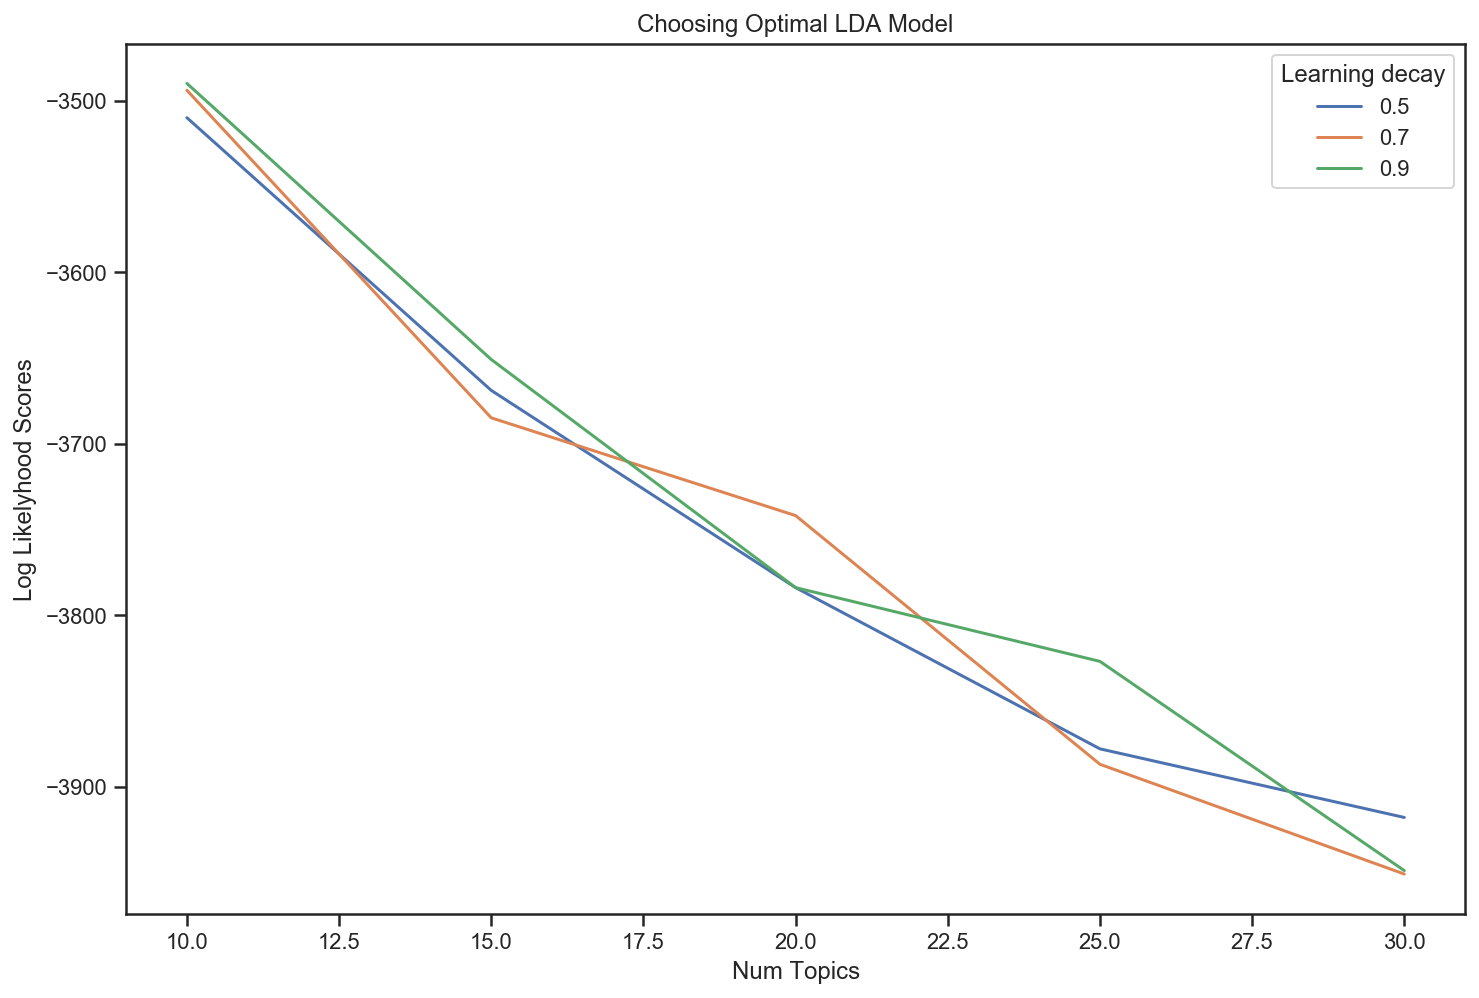

In [180]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore) for ind, gscore in enumerate(model.cv_results_['mean_test_score']) if ind <= 4]
log_likelyhoods_7 = [round(gscore) for ind, gscore in enumerate(model.cv_results_['mean_test_score']) if ind > 4 and ind < 10]
log_likelyhoods_9 = [round(gscore) for ind, gscore in enumerate(model.cv_results_['mean_test_score']) if ind >= 10]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

### Dominant topic of each document

In [181]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df1['tweet']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

In [182]:
# Review topics distribution across documents
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

Topic Num  Num Documents
0          0            292
1          8            102
2          6            102
3          1             85
4          4             83
5          7             59
6          2             57
7          9             48
8          3             40
9          5             27

### PyLDavis visualization

In [183]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()

In [184]:
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      32.420952   8.115230       1        1  14.460268
1       0.648955  71.707100       2        1  13.607836
8      71.019684   9.971006       3        1  12.343784
4       3.785981  33.185135       4        1  11.782415
0     -42.666500  -9.222070       5        1   9.507837
7      -3.621689 -43.526516       6        1   9.381709
2      -3.632402  -4.171708       7        1   8.939329
5     -36.584400  35.804413       8        1   7.697978
3      44.391380  50.615383       9        1   6.820737
9      40.235809 -31.591665      10        1   5.458107, topic_info=               Term        Freq       Total Category  logprob  loglift
19      dunkindonut   74.000000   74.000000  Default  30.0000  30.0000
72           recipe   59.000000   59.000000  Default  29.0000  29.0000
54             meat  103.000000  103.000000  Default  28.0000  28.0000
91            thank   59.000000   59.000000  Default  27.0000  27.0000
68          product   60.000000   60.000000  Default  26.0000  26.0000
13            check   65.000000   65.000000  Default  25.0000  25.0000
73       restaurant   47.000000   47.000000  Default  24.0000  24.0000
67            plant   67.000000   67.000000  Default  23.0000  23.0000
50             look   32.000000   32.000000  Default  22.0000  22.0000
36            happy   38.000000   38.000000  Default  21.0000  21.0000
3              base   64.000000   64.000000  Default  20.0000  20.0000
11           burger   59.000000   59.000000  Default  19.0000  19.0000
9         breakfast   40.000000   40.000000  Default  18.0000  18.0000
42             just   35.000000   35.000000  Default  17.0000  17.0000
93             time   33.000000   33.000000  Default  16.0000  16.0000
22            enjoy   44.000000   44.000000  Default  15.0000  15.0000
78          sausage   54.000000   54.000000  Default  14.0000  14.0000
59              new   55.000000   55.000000  Default  13.0000  13.0000
27             feed   22.000000   22.000000  Default  12.0000  12.0000
52             make   60.000000   60.000000  Default  11.0000  11.0000
49          locator   24.000000   24.000000  Default  10.0000  10.0000
48         location   40.000000   40.000000  Default   9.0000   9.0000
4              beef   32.000000   32.000000  Default   8.0000   8.0000
41            https   56.000000   56.000000  Default   7.0000   7.0000
18        delicious   23.000000   23.000000  Default   6.0000   6.0000
86            store   40.000000   40.000000  Default   5.0000   5.0000
74         retailer   22.000000   22.000000  Default   4.0000   4.0000
29             free   24.000000   24.000000  Default   3.0000   3.0000
45            learn   70.000000   70.000000  Default   2.0000   2.0000
6      beyondburger   24.000000   24.000000  Default   1.0000   1.0000
89            taste   18.895458   19.772605   Topic1  -3.0771   1.8884
79              say   16.075419   16.952344   Topic1  -3.2387   1.8807
4              beef   31.060842   32.986630   Topic1  -2.5801   1.8736
63      participate   10.434837   11.311833   Topic1  -3.6709   1.8531
55            meaty   22.608292   24.547560   Topic1  -2.8977   1.8515
103             way   13.028539   16.058610   Topic1  -3.4489   1.7247
11           burger   46.243465   59.135975   Topic1  -2.1821   1.6878
95         tomorrow   10.341126   13.413262   Topic1  -3.6799   1.6737
34            great   13.901848   18.241449   Topic1  -3.3840   1.6621
104            week    9.963571   14.170989   Topic1  -3.7171   1.5815
40             http   26.641098   41.686267   Topic1  -2.7336   1.4860
33             good   16.394722   25.707800   Topic1  -3.2191   1.4839
59              new   29.754732   55.466481   Topic1  -2.6230   1.3110
57       nationwide    9.639659   21.253500   Topic1  -3.7501   1.1431
84            start    8.053048   19.821153   Topic1  -3.9300   1.0331
61            offer

### Topic's keyword

In [185]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords

amp  appreciate  available       base       beef  beyondbeef  \
Topic0   0.100018    0.100000  12.076438   0.100004   0.100001    0.100003   
Topic1   0.240305    0.100009   0.100010  56.137814   0.100008    0.100002   
Topic2   0.100006    0.100000   5.274845   0.100002   1.159489    0.100016   
Topic3  16.783702    0.100006   0.100246   5.142665   0.100009    0.100009   
Topic4   3.150357    0.100000  21.795694   0.100010   0.100005    0.100005   
Topic5   2.359715   10.099973   0.100004   0.100005   0.100010    0.100006   
Topic6   1.965820    0.100001   9.252751   0.100014  33.040438    0.100014   
Topic7   0.100020    0.100000   0.100007   5.019480   0.100028   20.099942   
Topic8   0.100050    0.100011   0.100001   0.100001   0.100011    0.100001   
Topic9   0.100007    0.100000   0.100004   0.100005   0.100001    0.100003   

        beyondburger  beyondmeat  beyondsausage  breakfast     bring  \
Topic0      0.100013    0.100005       4.100030   0.100002  0.100006   
Topic1      0.100006    0.100001       0.100004   0.100007  2.195999   
Topic2      0.100018    0.100000       0.100001   0.100000  5.034628   
Topic3      0.100004    0.100003       0.100009   0.100002  0.100027   
Topic4     25.099918    0.100002       6.310418  42.099963  0.100008   
Topic5      0.100008    6.198871       0.100006   0.100004  0.100005   
Topic6      0.100016    0.100002       0.100015   0.100005  4.633353   
Topic7      0.100005    3.117040       9.889511   0.100009  0.100056   
Topic8      0.100007   23.984072       0.100004   0.100001  2.535908   
Topic9      0.100005    0.100003       0.100002   0.100007  0.100009   

           burger  celebrate      check        com       come  congratulation  \
Topic0   0.100009   0.100000  41.452886   0.100001   0.100001       14.099994   
Topic1   0.699541   0.100008   0.385021   0.100001   0.100004        0.100004   
Topic2   0.239882   0.100000   0.100004   0.100000   0.100008        0.100000   
Topic3  11.031299   0.100000   0.100002   0.100002  15.099951        0.100001   
Topic4   0.100008   0.100013   0.100012   0.100000   0.100006        0.100001   
Topic5   0.338537   2.753503   0.100005   0.100001   0.100003        0.100000   
Topic6  49.190693   2.012361   0.100003   0.100001   0.100004        0.100000   
Topic7   0.100019   2.648526  25.462063   0.100000   0.100001        0.100000   
Topic8   0.100012   2.985586   0.100002  23.099991   0.100013        0.100000   
Topic9   0.100001   0.100004   0.100001   0.100003   0.100009        0.100000   

              day  delicious  dunkindonut        eat      email      enjoy  \
Topic0   0.100009   0.100011     0.100001   0.100006   0.100002   0.100011   
Topic1   5.121587   0.108980     0.100005   6.561878   0.100001   0.100010   
Topic2   0.178259   0.100007     7.948178   0.100001   0.100000  28.834739   
Topic3   0.100036   0.100002     0.100004   0.100011   0.100002   0.100001   
Topic4  23.325896   2.206786     0.100012   0.227636   0.100000   4.917444   
Topic5   0.100023   0.100008     0.100002   1.128057   0.100000   0.100020   
Topic6   0.100015   0.100009     0.100005   2.215322   0.100000   2.215971   
Topic7   0.100044   5.096646     0.100000  10.367077   0.100000   0.100062   
Topic8   4.774129   0.100001     0.100002   0.100012  16.099991   9.431735   
Topic9   0.100002  15.987551    67.251791   0.100000   0.100003   0.100008   

        ethanandteam   excited     expand   favorite       feed      food  \
Topic0      0.100001  4.166646   0.100016   0.100016   0.100000  0.100013   
Topic1      0.100001  0.100012   0.100000   2.452318   0.100014  8.538845   
Topic2      0.100000  0.100031  11.099977   0.100000   0.100004  0.100008   
Topic3      0.100002  0.100000   0.100001   0.100003  20.395188  0.100026   
Topic4      0.100000  0.100001   0.100000   0.100009   0.100000  1.666799   
Topic5      0.100001  0.100007   0.100002   0.100004   0.100004  2.094298   
Topic6      0.100001  0.100011   0.100000   0.100007   0.100004  0.10000

In [186]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

Word 0   Word 1      Word 2        Word 3        Word 4  \
Topic 0   restaurant    check       store       locator      retailer   
Topic 1         meat    plant        base         learn          make   
Topic 2        happy    enjoy        tune          stay        future   
Topic 3         time     feed         amp          make          come   
Topic 4    breakfast  sausage    location  beyondburger           day   
Topic 5      product     just        free          roll        update   
Topic 6       burger     beef         new          http         learn   
Topic 7       recipe    https       check    beyondbeef      favorite   
Topic 8        thank     love  beyondmeat           com  ethanandteam   
Topic 9  dunkindonut     look   delicious         right          wait   

            Word 5    Word 6          Word 7      Word 8         Word 9  \
Topic 0        try   product  congratulation   available           sure   
Topic 1    protein  gobeyond           https        food           meal   
Topic 2       plan      hope          expand  nationwide         update   
Topic 3     people    burger            team        work            use   
Topic 4  available  sandwich           today         new           meat   
Topic 5   purchase      sign      appreciate        news            new   
Topic 6      meaty     taste            good         say          great   
Topic 7        use      make             eat        meat  beyondsausage   
Topic 8    support      know           email         let          learn   
Topic 9    excited     grill            need        want           hear   

          Word 10     Word 11      Word 12    Word 13        Word 14  
Topic 0  location        http         wait    excited  beyondsausage  
Topic 1      help      simple          eat      order           need  
Topic 2      make       share  dunkindonut       help          shelf  
Topic 3   sausage        base        plant       know           good  
Topic 4   weekend       start          try       menu          order  
Topic 5  question  beyondmeat         stay      great          today  
Topic 6     https         way  participate   tomorrow           week  
Topic 7   excited     partner         meal  delicious           base  
Topic 8      hear        like          win       glad          enjoy  
Topic 9    simple        make          way       meat            try

### Training a Supervised Classifier

#### Converting topics to feature vectors

In [187]:
# Create Document - Topic Matrix
X_num_topic = best_lda_model.transform(data_vectorized)
len(X_num_topic)

895

In [188]:
len(y_dummy)

895

### Split  Data Randomized

In [189]:
# randomized splitting data

X = X_num_topic # the features we want to analyze
y = y_dummy # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 1)

#### Logistic Regression - randomized split

In [190]:
classifier = LogisticRegression(C=1, random_state= 0)

In [191]:
# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 88.83%
test score: 87.15%

F1 score on training: 94.08%

Confusion Matrix
[[  0  23]
 [  0 156]]


#### Nearest Neighbors - randomized split

In [192]:
from sklearn.neighbors import KNeighborsClassifier

# Let's use 5 neighbors to learn
classifier = KNeighborsClassifier(n_neighbors=5)

# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 88.69%
test score: 87.15%

F1 score on training: 94.00%

Confusion Matrix
[[  0  23]
 [  0 156]]


In [193]:
# Changing the parameters
n_neighbors_list = [1, 10, 100]
p_list = [1, 2] #1=Manhatan distance norm ; 2=Euclidian distance

print()
for p in p_list:
    print()
    print('# Distance ', p)
    print()
    for n_neighbors in n_neighbors_list:
        print('## Nb neighbors: ', n_neighbors)
        # Note: increase max iterations 10x for solver's convergence
        classifier = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
        
        classifier.fit(X_train, y_train)
        
        
        print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
        print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
        # print('weights: ', classifier.coef_[0])



# Distance  1

## Nb neighbors:  1
train score: 95.39%
test score: 81.01%
## Nb neighbors:  10
train score: 88.83%
test score: 87.15%
## Nb neighbors:  100
train score: 88.83%
test score: 87.15%

# Distance  2

## Nb neighbors:  1
train score: 95.39%
test score: 79.89%
## Nb neighbors:  10
train score: 88.83%
test score: 87.15%
## Nb neighbors:  100
train score: 88.83%
test score: 87.15%


### Linear SVM - randomized split

In [194]:
classifier = LinearSVC(C=1)

# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 88.83%
test score: 87.15%

F1 score on training: 94.08%

Confusion Matrix
[[  0  23]
 [  0 156]]


### Kernel based SVM - randomized split

In [195]:
classifier = SVC(kernel='rbf', gamma=20)

# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 89.53%
test score: 87.15%

F1 score on training: 94.43%

Confusion Matrix
[[  0  23]
 [  0 156]]


In [196]:
kernel = 'rbf'
gammas = [0.05, 0.5, 5, 50, 'scale',]

for i, gamma in enumerate(gammas):
    classifier = SVC(kernel=kernel, gamma=gamma)
    classifier.fit(X_train, y_train)
    print('##gamma= {}'.format(gamma))
    print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
    print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
    print()

##gamma= 0.05
train score: 88.83%
test score: 87.15%

##gamma= 0.5
train score: 88.83%
test score: 87.15%

##gamma= 5
train score: 88.83%
test score: 87.15%

##gamma= 50
train score: 91.48%
test score: 86.59%

##gamma= scale
train score: 88.83%
test score: 87.15%



### Temporal Splitting

In [197]:
# temporal splitting

# create benchmark
bench = int(len(y)*0.8) # 80% of the data

# for the y variable
y_train = y[:bench]
y_test = y[bench:]

# for the X_num variable
X_train = X[:bench]
X_test = X[bench:]

#### Logistic Regression - temporal split

In [198]:
classifier = LogisticRegression(C=1, random_state= 0)

In [199]:
# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 89.39%
test score: 84.92%

F1 score on training: 94.40%

Confusion Matrix
[[  0  27]
 [  0 152]]


#### Nearest Neighbors - temporal split

In [200]:
from sklearn.neighbors import KNeighborsClassifier

# Let's use 5 neighbors to learn
classifier = KNeighborsClassifier(n_neighbors=5)

# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 89.66%
test score: 84.92%

F1 score on training: 94.52%

Confusion Matrix
[[  1  26]
 [  1 151]]


In [201]:
# Changing the parameters
n_neighbors_list = [1, 10, 100]
p_list = [1, 2] #1=Manhatan distance norm ; 2=Euclidian distance

print()
for p in p_list:
    print()
    print('# Distance ', p)
    print()
    for n_neighbors in n_neighbors_list:
        print('## Nb neighbors: ', n_neighbors)
        # Note: increase max iterations 10x for solver's convergence
        classifier = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
        
        classifier.fit(X_train, y_train)
        
        
        print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
        print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
        # print('weights: ', classifier.coef_[0])



# Distance  1

## Nb neighbors:  1
train score: 95.67%
test score: 72.63%
## Nb neighbors:  10
train score: 89.53%
test score: 84.92%
## Nb neighbors:  100
train score: 89.39%
test score: 84.92%

# Distance  2

## Nb neighbors:  1
train score: 95.67%
test score: 72.63%
## Nb neighbors:  10
train score: 89.53%
test score: 85.47%
## Nb neighbors:  100
train score: 89.39%
test score: 84.92%


### Linear SVM - temporal split

In [202]:
classifier = LinearSVC(C=1)

# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 89.39%
test score: 84.92%

F1 score on training: 94.40%

Confusion Matrix
[[  0  27]
 [  0 152]]


### Kernel based SVM - temporal split

In [203]:
classifier = SVC(kernel='rbf', gamma=20)

# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 89.39%
test score: 84.92%

F1 score on training: 94.40%

Confusion Matrix
[[  0  27]
 [  0 152]]


In [204]:
kernel = 'rbf'
gammas = [0.05, 0.5, 5, 50, 'scale',]

for i, gamma in enumerate(gammas):
    classifier = SVC(kernel=kernel, gamma=gamma)
    classifier.fit(X_train, y_train)
    print('##gamma= {}'.format(gamma))
    print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
    print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
    print()

##gamma= 0.05
train score: 89.39%
test score: 84.92%

##gamma= 0.5
train score: 89.39%
test score: 84.92%

##gamma= 5
train score: 89.39%
test score: 84.92%

##gamma= 50
train score: 90.92%
test score: 84.92%

##gamma= scale
train score: 89.39%
test score: 84.92%



## Conclusion

Although the data used was very limited (small sample size), the models worked out in some way. However, to improve the quality, more data should be analyzed, i.e. more tweets. One important point to mention is, that we have to keep in mind that we are facing simultanous causality: Predicting stock data based on twitter activity is difficult, since it is not clear which variable affects the other. There is also a time lag correlated with the variables.

After all, the performed analysis shows that there is a correlation which can be clearly observed.